# Kaplan Meier Curve image-based calculation for progression risk changes over time.

In [40]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os,sys
from scipy import stats
from collections import Counter
plt.style.use('seaborn-white')


In [41]:
plt.rcParams['figure.figsize']=4,3
plt.rcParams['figure.dpi']=300
plt.rcParams['axes.linewidth'] =1
plt.rcParams['lines.linewidth'] =1
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [42]:
plt.rcParams["xtick.bottom"] = True 
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.major.size"] = 4.0      # x軸主目盛り線の長さ
plt.rcParams["ytick.major.size"] = 4.0      # y軸主目盛り線の長さ
plt.rcParams["xtick.major.width"] = 1     # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1 

In [43]:
from lifelines import CoxPHFitter

def gt_nanmedian(array,p=50):
    m=np.nanpercentile(array,p)
    y=[]
    for x in array:
        if x >=m:
            y.append(1)
        elif x <m:
            y.append(0)
        else:
            y.append(np.nan)
    return y

def gt_nanmean(array):
    m=np.nanmean(array)
    y=[]
    for x in array:
        if x >=m:
            y.append(1)
        elif x <m:
            y.append(0)
        else:
            y.append(np.nan)
    return y

In [44]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test,multivariate_logrank_test,pairwise_logrank_test

# make function
def KMcurve(data, duration="OS",duration_limit=None,event="Death",category=None,
                continuous=False, pcts=None,ax=None,colors=None,group_order=None,
                linewidth=None,linestyle=None,weightings=None,add_at_risk=False):
    """ if you set continuous category, set pct list of percentiles from  0 to 100 """
    """ weightings, options:'wilcoxon', 'tarone-ware' ,'peto' """
    # conditional branching by category's value types
    data=data.copy()
    if duration_limit:
        data[duration]=data[duration].clip(0,duration_limit)
    if ax==None:
        ax=fig.add_subplot(111)
    if category:
        # Curate the data, by drop the raw containing "NA"
        data=data.dropna(subset=[duration,event,category]) 
        if continuous:
            if len(pcts)==0:
                print("pct were set as 50!")
                pcts=[50]
            bins=[ np.min(data[category]) ]
            labels=[category+'_0']
            for i,pct in enumerate(pcts):
                bins.append( np.percentile( data[category], pct ) )
                labels.append(category+'_'+str(i+1))
            bins.append( np.max(data[category]) )
            data[category]=pd.cut(data[category],bins=bins,labels=labels
                                 ,duplicates='drop',right=False)
            # divide samples by categories
            numbers, groups = pd.factorize(data[category])   
        else:
            numbers, groups = pd.factorize(data[category])
        
        # plot each group in one figure 
        print(numbers[:10],list(groups))
        if group_order:
            groups=group_order
        for i, group in enumerate(groups):
            tmp_df=data[ data[category]== group]
            group_size=len(tmp_df)
            kmf = KaplanMeierFitter()
            kmf.fit(durations=tmp_df[duration], event_observed=tmp_df[event],
                        label="{} ($n$={})".format(group, group_size))
            # plot
            options={}
            if colors:
                options["color"]=colors[i]
            if linewidth:
                if type(linewidth)==list:
                    options["lw"]=linewidth[i]
                else:
                    options["lw"]=linewidth
            if linestyle:
                if type(linestyle)==list:
                    options["ls"]=linestyle[i]
                else:
                    options["ls"]=linestyle
            kmf.plot(ci_show=False, **options,
                     show_censors=True,censor_styles={'ms': 0},ax=ax)
        
        #if data[category].dtype in ["int","float"]:
            #print("KM plot stratified by "+ category +" div-percentile "+str(pct) )
        #else:
        #    print("KM plot stratified by "+ category)
        # log-rank test    
        if len(groups)==2:
            durations_A=data[ data[category]== groups[0] ][duration]
            durations_B=data[ data[category]== groups[1] ][duration]
            event_observed_A=data[ data[category]== groups[0] ][event]
            event_observed_B=data[ data[category]== groups[1] ][event]
            res=logrank_test(durations_A, durations_B, event_observed_A, event_observed_B,weightings=weightings)
            print(category,"simple log rank p=", res.summary.iloc[0,1])  
            
        elif  len(groups)>2:
            res= multivariate_logrank_test(event_durations=data[duration], event_observed=data[event],
                                       groups=data[category],weightings=weightings)
            print(category,"multivariate log rank p=", res.summary.iloc[0,1])
        
    else:
        print("no category ?")
        data=data.dropna(subset=[duration,event]) 
        kmf = KaplanMeierFitter()
        kmf.fit(durations=data[duration],event_observed=data[event] )
        kmf.plot(ax=ax)
        ax.set_title("KM plot none stratified" )
    
    ax.legend(title="",frameon=True,fontsize=8,edgecolor="k")
    ax.set_xlabel(duration)
    ax.set_ylabel("survival ratio")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

In [45]:
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KN
from sklearn.linear_model import LogisticRegression as LR
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [46]:
def getNearestValue(list, num):
    idx = np.nanargmin( np.abs(np.asarray(list) - num) )
    return list[idx]

In [47]:
from statistics import stdev

## package version information

In [48]:
print(sys.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:51:59) 
[Clang 14.0.6 ]


In [49]:
%pip list | grep -e "numpy" -e "pandas" -e "matplotlib" -e "scipy" -e "scikit-learn" -e 'lifelines'

lifelines                     0.26.3
matplotlib                    3.4.3
matplotlib-inline             0.1.3
matplotlib-venn               0.11.6
numpy                         1.20.3
pandas                        1.3.4
scikit-learn                  1.0.1
scipy                         1.7.2
Note: you may need to restart the kernel to use updated packages.


In [50]:
input_dir='../data/'
output_dir='../results/'

# ICON7-A analysis 

In [51]:
df=pd.read_csv('../data/ICON7A_clinical_data.txt',sep='\t',index_col=0)
df

Cohort    Age  Age_high figo_stage  Stage_III/IV    OS   PFS  \
CaseID                                                                     
GSM4153778     CCR  40-64         0         IV             1  1326  1326   
GSM4153779     CCR   >=65         1         IV             1   796   327   
GSM4153780     CCR  40-64         0        III             1  1281   642   
GSM4153781     CCR   >=65         1        III             1   379   274   
GSM4153782     CCR  40-64         0        III             1  1216   866   
...            ...    ...       ...        ...           ...   ...   ...   
HP-85104    NatCom  40-64         0        III             1   921   383   
HP-85430    NatCom  40-64         0        III             1   847   595   
HP-85354    NatCom  40-64         0        III             1   673   582   
HP-85065    NatCom  40-64         0        III             1   645   584   
HP-85280    NatCom  40-64         0        III             1  1049  1043   

            Death  Rec  Bev Bev_anno  Serous Grade  Optimal HRDness_pred  HRD  \
CaseID                                                                          
GSM4153778      0    0  0.0     Bev-       1   NaN      1.0          HRD    1   
GSM4153779      1    1  0.0     Bev-       1  high      0.0       nonHRD    0   
GSM4153780      0    1  1.0     Bev+       1  high      1.0          HRD    1   
GSM4153781      1    1  0.0     Bev-       1  high      0.0       nonHRD    0   
GSM4153782      0    1  1.0     Bev+       1   low      0.0          HRD    1   
...           ...  ...  ...      ...     ...   ...      ...          ...  ...   
HP-85104        0    1  1.0     Bev+       0  high      0.0    nonSerous    0   
HP-85430        0    1  1.0     Bev+       0  high      1.0    nonSerous    0   
HP-85354        0    0  1.0     Bev+       0   low      0.0    nonSerous    0   
HP-85065        0    0  1.0     Bev+       0  high      0.0    nonSerous    0   
HP-85280        0    0  1.0     Bev+       0  high      1.0    nonSerous    0   

            nonHRD  
CaseID              
GSM4153778       0  
GSM4153779       1  
GSM4153780       0  
GSM4153781       1  
GSM4153782       0  
...            ...  
HP-85104         0  
HP-85430         0  
HP-85354         0  
HP-85065         0  
HP-85280         0  

[745 rows x 17 columns]

## violation of the proportional hazards assumption

In [52]:
df.shape

(745, 17)

In [53]:
Counter( df['Cohort'] )

Counter({'CCR': 380, 'NatCom': 365})

In [54]:
pd.crosstab(df['Serous'],df['Bev'])

Bev     0.0  1.0
Serous          
0       106  104
1       255  280

In [55]:
pd.crosstab(df['Optimal'],df['Bev'])

Bev      0.0  1.0
Optimal          
0.0      104   97
1.0      254  286

In [56]:
pd.crosstab(df['figo_stage'],df['Bev'])

Bev         0.0  1.0
figo_stage          
I            24   25
II           34   43
III         255  264
IV           48   52

In [57]:
def plot_km_loglog(data,category,duration='PFS',event='Rec'):
    kmf = KaplanMeierFitter()
    T=data[duration]
    C=data[event].astype(float) 
    for r in data[category].unique():
        flag = data[category] == r
        kmf.fit(T[flag], C[flag],label = r)
        kmf.plot_loglogs(ax=ax)

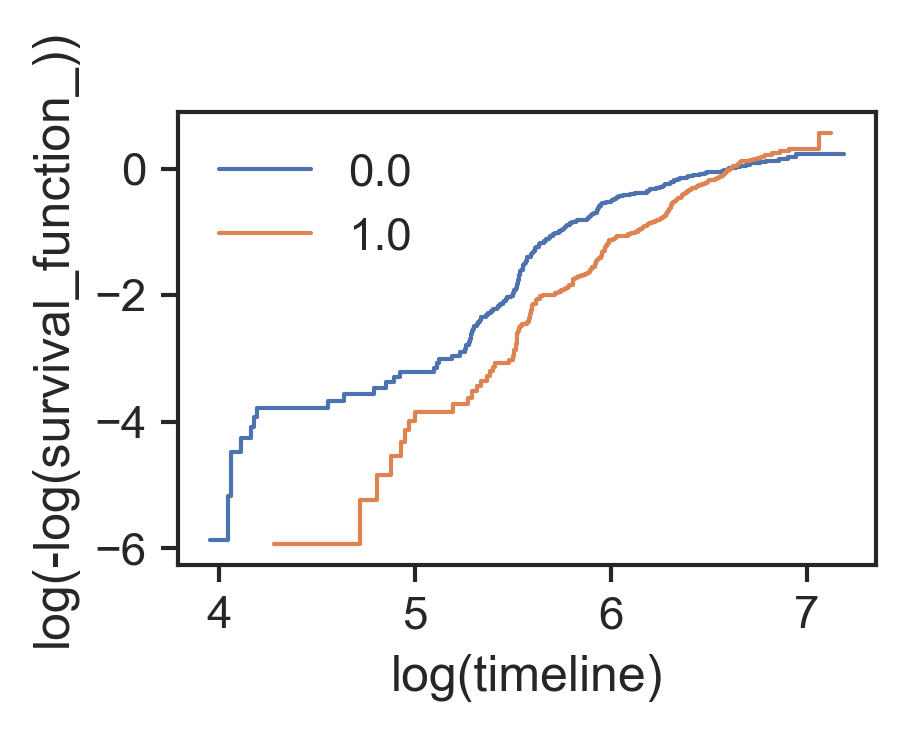

In [58]:
in_df=df
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plot_km_loglog(data=in_df,duration='PFS',event='Rec',category='Bev')

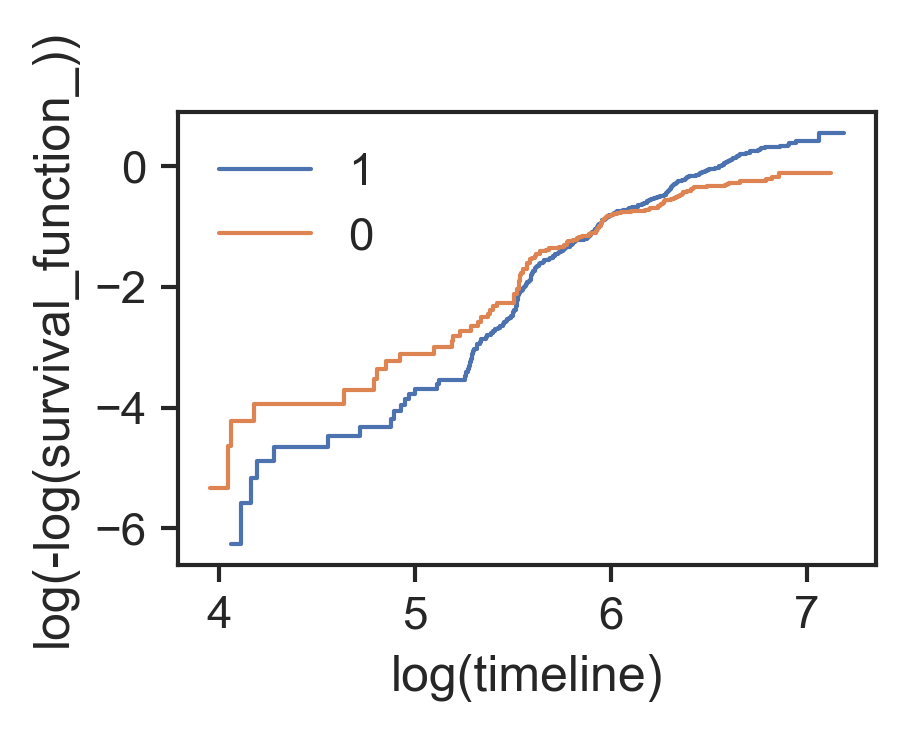

In [59]:
in_df=df
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plot_km_loglog(data=in_df,duration='PFS',event='Rec',category='Serous')

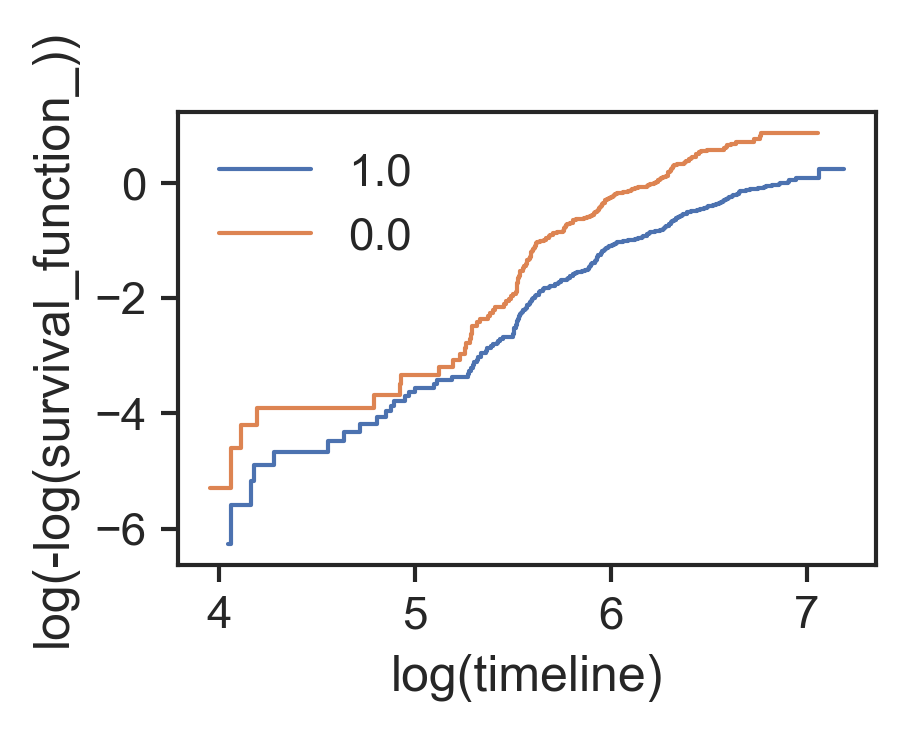

In [60]:
in_df=df[~df['Optimal'].isna()]
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plot_km_loglog(data=in_df,duration='PFS',event='Rec',category='Optimal')

In [61]:
duration="PFS"
event="Rec"
covs=["Bev","Stage_III/IV","Age_high",'Optimal','Serous']

In [62]:
# Cox multivariate analysis
cph=CoxPHFitter()
tmp_df=df.copy()
tmp_df=tmp_df[[duration,event]+covs].dropna()
tmp_df2=pd.get_dummies(tmp_df,drop_first=True)
res=cph.fit( tmp_df2, duration_col=duration, event_col=event,step_size=0.1)
results=res.summary.reindex(["exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%","p"],axis=1)
p_detail=results["p"]
results_simple=np.round( results.rename(columns={ "exp(coef)":"HR","exp(coef) lower 95%":"CI low",
                                       "exp(coef) upper 95%":"CI high" }),3)
results_simple
# for table
results_simple2=np.round(results_simple,2)
results_simple2['95%CI']=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(results_simple2['CI low'],results_simple2['CI high']) ]
results_simple2['p_detail']=['{:.2g}'.format(x) for x in p_detail]
results_simple2=results_simple2.reindex(['HR', '95%CI', 'p_detail'],axis=1)
print('Please carefully check np.round decimal !')
results_simple2

Please carefully check np.round decimal !


HR          95%CI p_detail
covariate                                 
Bev           0.82  (0.68 - 0.98)    0.034
Stage_III/IV  4.99  (3.32 - 7.52)  1.4e-14
Age_high      1.33  (1.09 - 1.63)   0.0048
Optimal       0.54  (0.44 - 0.66)    6e-10
Serous        0.93  (0.75 - 1.16)     0.53

In [63]:
from lifelines.statistics import proportional_hazard_test
ptest = proportional_hazard_test(cph, tmp_df2, time_transform='rank')
ptest.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 741 total observations, 273 right-censored observations>
         test_name = proportional_hazard_test

---
              test_statistic      p  -log2(p)
Age_high                0.01   0.94      0.08
Bev                    40.97 <0.005     32.59
Optimal                 0.28   0.60      0.74
Serous                  6.92   0.01      6.88
Stage_III/IV            0.10   0.75      0.41

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



/Users/tshiro/.pyenv/versions/miniforge3-4.10/lib/python3.8/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 741 total observations, 273 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic      p  -log2(p)
Age_high     km              0.00   0.99      0.01
             rank            0.01   0.94      0.08
Bev          km             40.88 <0.005     32.52
             rank           40.97 <0.005     32.59
Optimal      km              0.34   0.56      0.84
             rank            0.28   0.60      0.74
Serous       km              6.90   0.01      6.86
             rank            6.92   0.01      6.88
Stage_III/IV km              0.09   0.77      0.38
             rank            0.10   0.75      0.41



1. Variable 'Bev' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Bev', ...]` in the call in
`.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'Serous' failed the non-proportional test: p-value is 0.0085.

   Advice: with so few unique values (only 2), you can include `strata=['Serous', ...]` in the call
in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_note

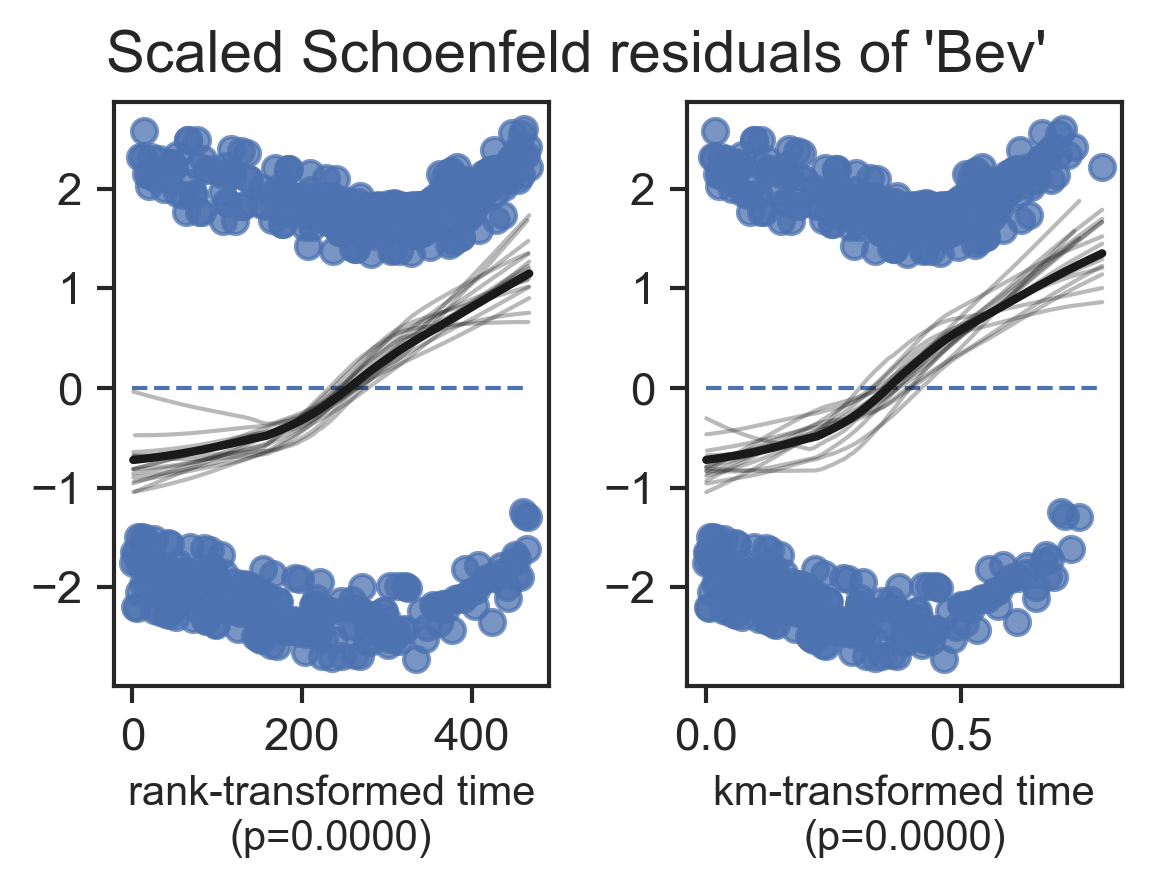

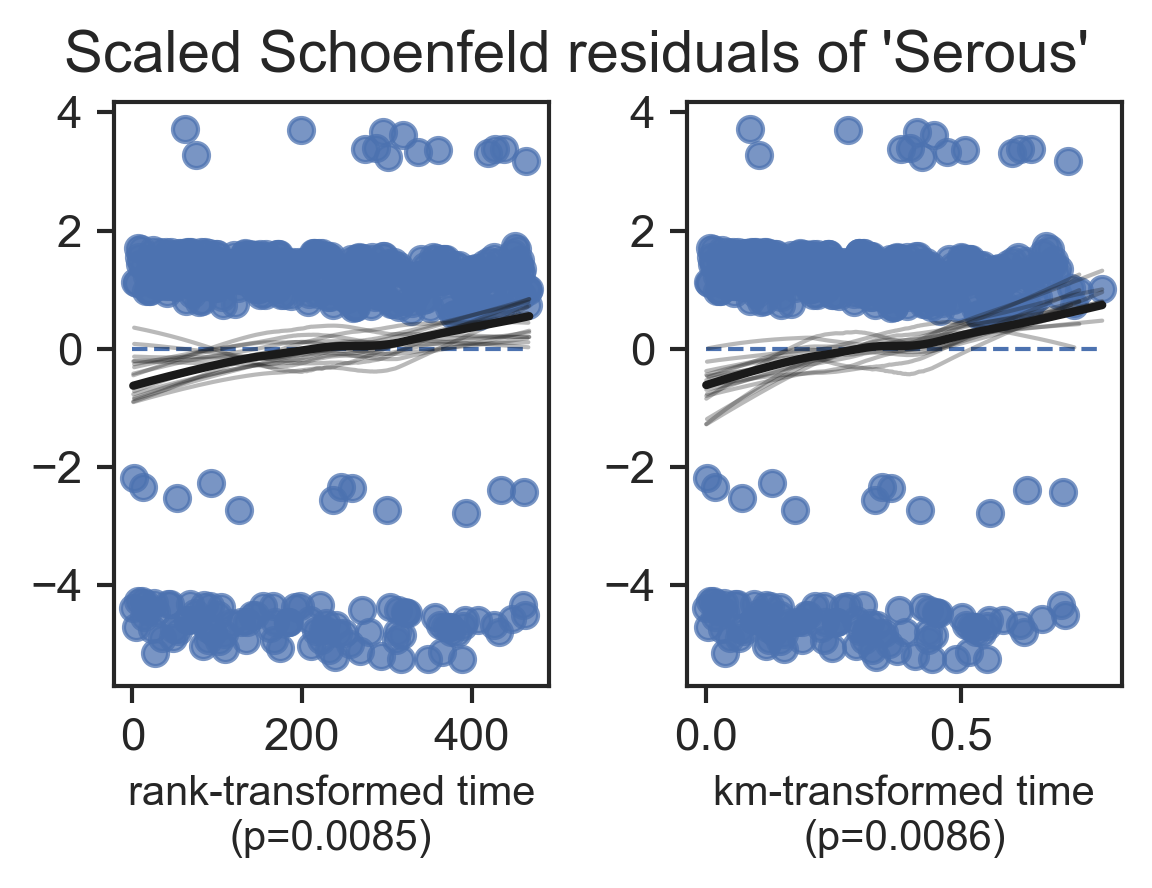

In [64]:
axes=cph.check_assumptions(tmp_df2, p_value_threshold=0.05, show_plots=True)

# Calculate progression risk at a given time

In [65]:
# Example
X=180

In [66]:
tmp_df=df[df['PFS']>=X]
t_bev=len(tmp_df[tmp_df['Bev']==1])
t_std=len(tmp_df[tmp_df['Bev']==0])

tmp_df2=tmp_df[(tmp_df['PFS']<=X+30)&(tmp_df['Rec']==1)]
n_bev=len(tmp_df2[tmp_df2['Bev']==1])
n_std=len(tmp_df2[tmp_df2['Bev']==0])

print(t_bev,n_bev,t_std,n_std)

368 5 332 14


In [67]:
rr=stats.contingency.relative_risk(n_bev,t_bev,n_std,t_std)
rr.relative_risk

0.3222049689440994

In [68]:
in_df=df.copy()
r_bevs, r_stds, r_rs=[],[],[]
window=30
for x in range(window,900+window):
    tmp_df=in_df[in_df['PFS']>=x]
    t_bev=len(tmp_df[tmp_df['Bev']==1])
    t_std=len(tmp_df[tmp_df['Bev']==0])

    tmp_df2=tmp_df[(tmp_df['PFS']<=x+window)&(tmp_df['Rec']==1)]
    n_bev=len(tmp_df2[tmp_df2['Bev']==1])
    n_std=len(tmp_df2[tmp_df2['Bev']==0])
    
    if (n_bev==0)|(n_std==0):
        r_bev, r_std, r_r, cil, cih=np.nan,np.nan,np.nan,np.nan,np.nan
    else:
        r_bev=n_bev/t_bev
        r_std=n_std/t_std
        rr=stats.contingency.relative_risk(n_bev,t_bev,n_std,t_std)
        r_r=rr.relative_risk
    r_bevs.append(r_bev)
    r_stds.append(r_std)
    r_rs.append(r_r)

In [69]:
table=pd.DataFrame({'Risk_bev':r_bevs,'Risk_std':r_stds,'Relative_risk':r_rs})
table['day']=range(window,900+window)
table.dropna()

Risk_bev  Risk_std  Relative_risk  day
12   0.002625  0.022409       0.117126   42
13   0.002625  0.022409       0.117126   43
14   0.002625  0.022409       0.117126   44
15   0.002625  0.022409       0.117126   45
16   0.002625  0.022409       0.117126   46
..        ...       ...            ...  ...
861  0.022727  0.018519       1.227273  891
862  0.022727  0.018519       1.227273  892
897  0.029412  0.027027       1.088235  927
898  0.029412  0.027027       1.088235  928
899  0.029412  0.027027       1.088235  929

[826 rows x 4 columns]

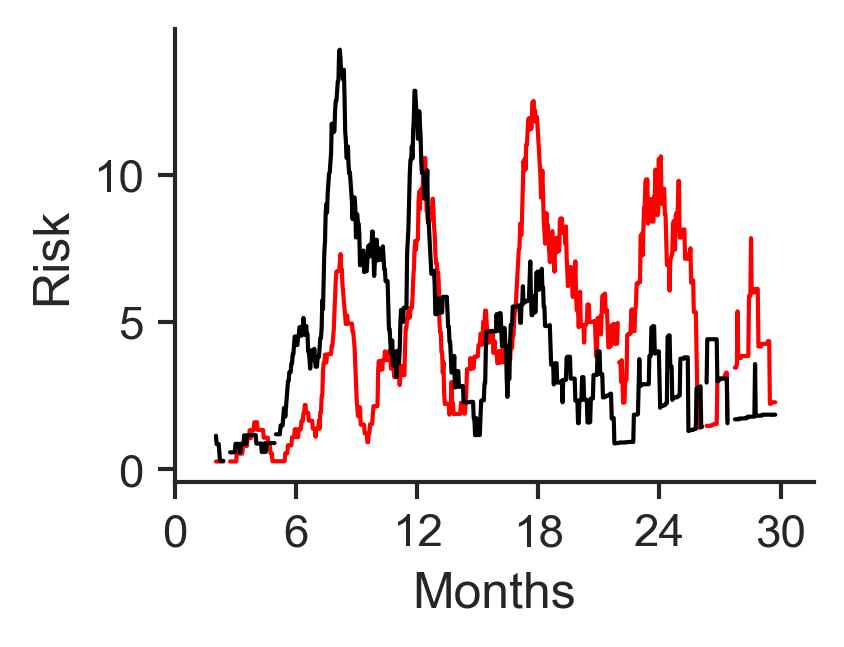

In [70]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>60)&(plt_df['day']<900)]
x=plt_df2['day']
y1=plt_df2['Risk_bev']*100
y2=plt_df2['Risk_std']*100
ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])

ax.set_xlim(0,950)
#ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0,zorder=2)
#ax.axvspan(xmin=30,xmax=12.6*30,color='lightgrey')
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

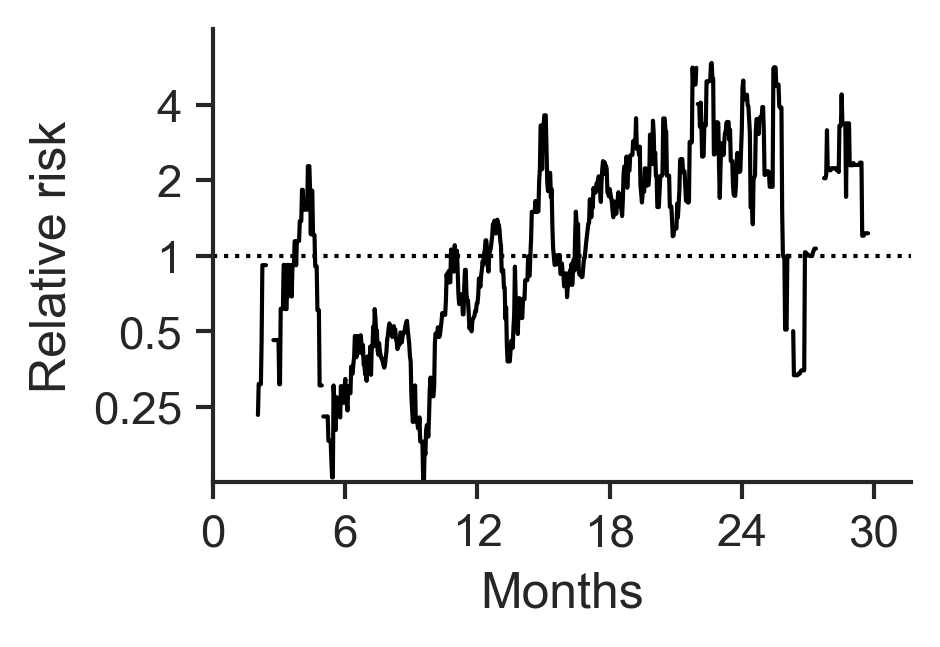

In [71]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>60)&(plt_df['day']<900)]
x=plt_df2['day']
y1=np.log2( plt_df2['Relative_risk'] )
ax.plot(x,y1,c='black')

ax.axhline(y=0,c='black',ls='dotted')

ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])
ax.set_xlim(0,950)

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_ylim(-3,3)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

In [72]:
# moving average
ma_ave=[]
ma_bevs,ma_stds=[],[]
window2=2*30
for idx in table.index:
    if idx < window2:
        ma_ave.append(np.nan)
        ma_bevs.append(np.nan)
        ma_stds.append(np.nan)
    elif idx > len(table) - window2:
        ma_ave.append(np.nan)
        ma_bevs.append(np.nan)
        ma_stds.append(np.nan)
    else:
        ave=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Relative_risk'])
        bev=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Risk_bev'])
        std=np.nanmean(table.iloc[idx-int(window2):idx+int(window2),:]['Risk_std'])

        ma_ave.append(ave)
        ma_bevs.append(bev)
        ma_stds.append(std)
        
table['Relative_risk_moving_average']=ma_ave
table['Risk_bev_moving_average']=ma_bevs
table['Risk_std_moving_average']=ma_stds

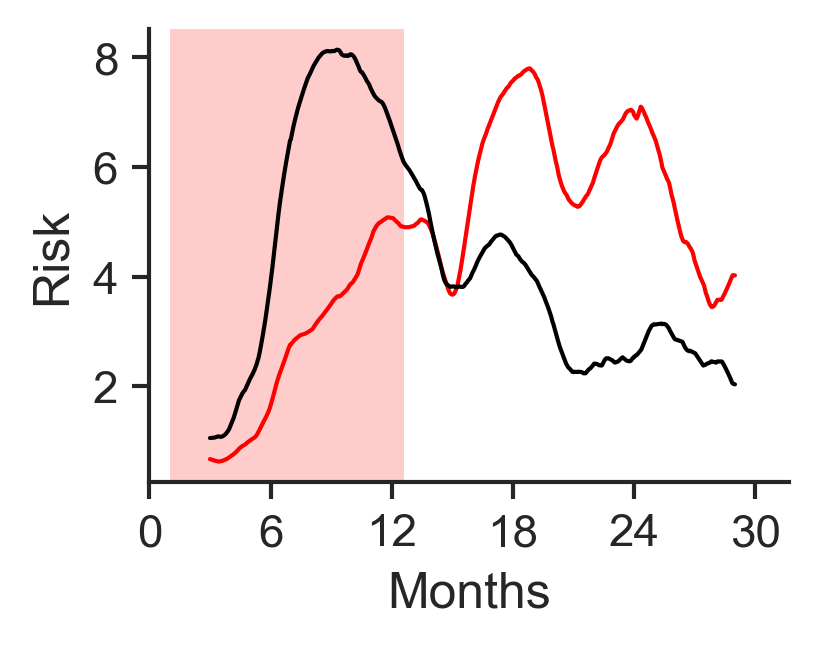

In [73]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>60)&(plt_df['day']<900)]
x=plt_df2['day']
y1=plt_df2['Risk_bev_moving_average']*100
y2=plt_df2['Risk_std_moving_average']*100
ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])

ax.set_yticks([2,4,6,8])
ax.set_xlim(0,950)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

#ax.axvline(x=54*7,color='k',ls='dotted')
ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0)

plt.savefig('../results/ICON7A_pr_moving_average_from_indivisual_patient_data.pdf')

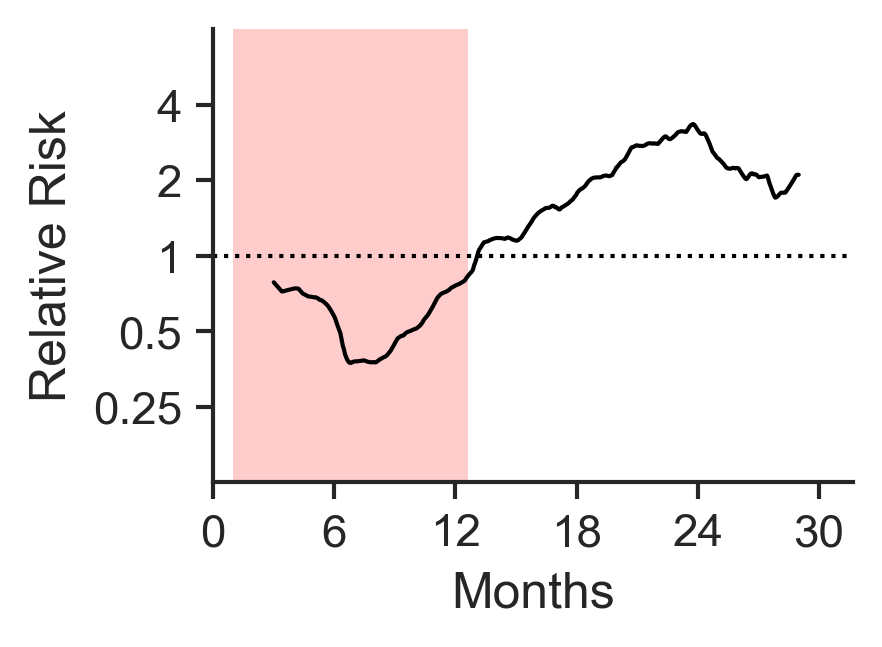

In [74]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>60)&(plt_df['day']<900)]
x=plt_df2['day']
y1=np.log2( plt_df2['Relative_risk_moving_average'] )
ax.plot(x,y1,c='black')
ax.axhline(y=0,c='black',ls='dotted')

ax.set_ylabel('Relative Risk')
ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,950)
ax.set_ylim(-3,3)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0)

plt.savefig('../results/ICON7A_rr_moving_average_from_indivisual_patient_data.pdf')

# How to estimate progression risks from published KM curves

## Make KM curve from ICON7A clinical data

[0 0 1 0 1 1 0 1 1 1] ['Bev-', 'Bev+']
Bev_anno simple log rank p= 0.061664805043830956


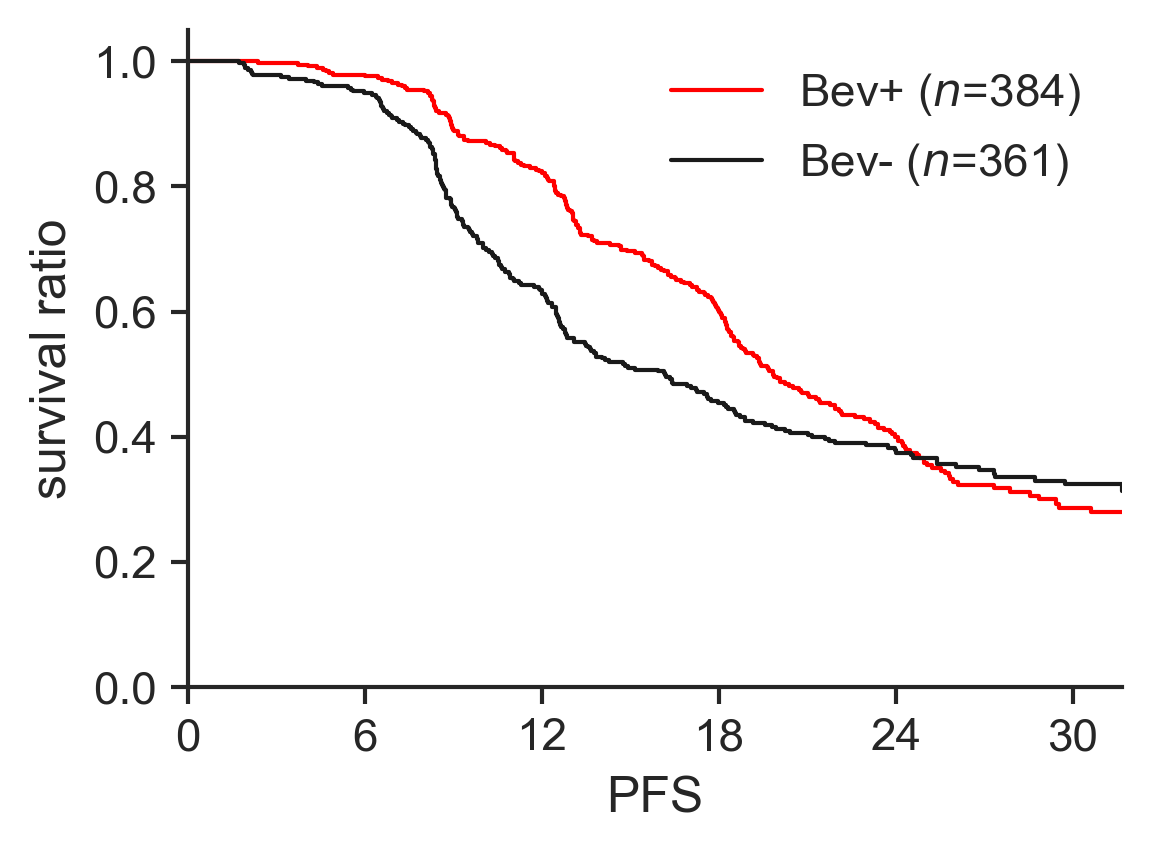

In [75]:
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(111)
KMcurve(data=df,duration='PFS',event='Rec',ax=ax,
        category='Bev_anno',linewidth=1,
       group_order=['Bev+','Bev-'],colors=['red','k']
       )
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlim(0,950)
ax.set_ylim(0,1.05)
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
plt.tight_layout()

plt.savefig('../results/ICON7_KMcurve+from_individual_patinet_data.jpg',dpi=1200)

### After extraction of cordinates using image J,
### Reconstruction of KM curve

In [76]:
df1=pd.read_csv('../data/ICON7A_reconstructed_from_KMC_bev_plus.txt',sep='\t')
df2=pd.read_csv('../data/ICON7A_reconstructed_from_KMC_bev_minus.txt',sep='\t')
df3=pd.read_csv('../data/ICON7A_reconstructed_from_KMC_axis_label.txt',sep='\t')
df3

X     Y
0       824   496
1       825   496
2       828   496
3       829   496
4       831   496
...     ...   ...
268092  851  3391
268093  852  3391
268094  853  3391
268095  854  3391
268096  855  3391

[268097 rows x 2 columns]

Text(0, 0.5, 'Y')

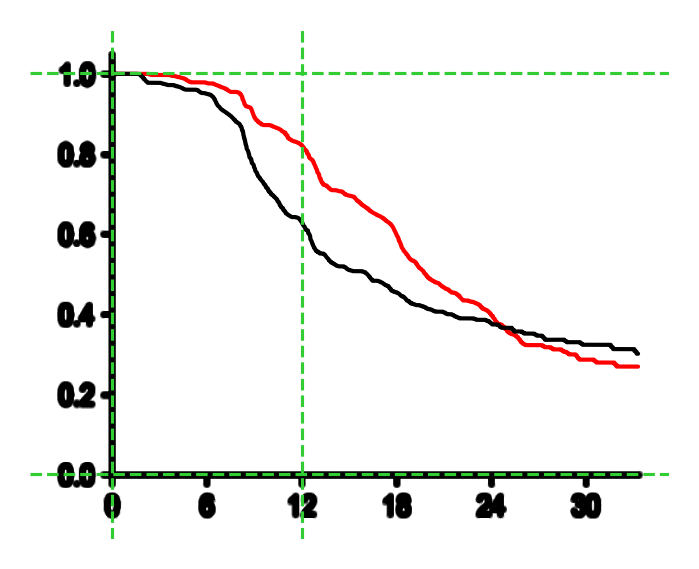

In [77]:
plt_df=df1.copy()
val1='X'
val2='Y'
fig=plt.figure(figsize=(2.75,2.25))
ax=fig.add_subplot(111)

plt_df=df1.copy()
plt_df=plt_df[['X','Y']].dropna()
x,y=plt_df['X'],plt_df['Y']
ax.plot(x,y,c='red')

plt_df=df2.copy()
plt_df=plt_df[['X','Y']].dropna()
x2,y2=plt_df['X'],plt_df['Y']
ax.plot(x2,y2,c='black')


plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.0001,c='black',marker='.')

# Check axis 
sr1=3265
sr0=755
ax.axhline(y=sr1,c='limegreen',lw=0.75,ls='dashed')
ax.axhline(y=sr0,c='limegreen',lw=0.75,ls='dashed')

m0=845
m12=2194
ax.axvline(x=m0,c='limegreen',lw=0.75,ls='dashed')
ax.axvline(x=m12,c='limegreen',lw=0.75,ls='dashed')

ax.set_axis_off()
ax.set_xlabel(val1)
ax.set_ylabel(val2)

In [78]:
m24=m0+2*(m12-m0)
m36=m0+3*(m12-m0)

In [79]:
ms=[m0+i*(m12-m0)/12 for i in range(0,36)]
rs1=[df1[df1['X']==getNearestValue(list(df1['X']),m)]['Y'].values[0] for m in ms]
rs2=[df2[df2['X']==getNearestValue(list(df2['X']),m)]['Y'].values[0] for m in ms]

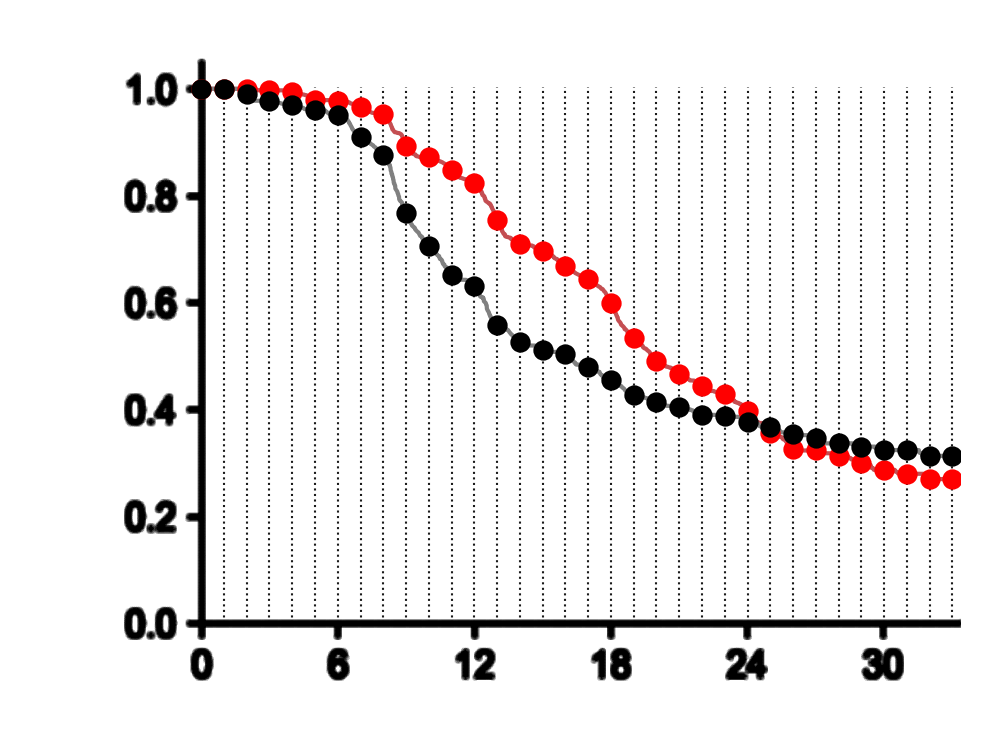

In [80]:
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(111)
ax.plot(x,y,c='r',zorder=0)
ax.plot(x2,y2,c='grey',zorder=0)
ax.scatter(x3,y3,s=0.0001,c='black',marker='.')
ax.scatter(ms,rs1,s=15,c='red',label='Bev')
ax.scatter(ms,rs2,s=15,c='black',label='Standard')

ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(0,m36-300)
ax.set_xlabel(val1)
ax.set_ylabel(val2)

#ax.legend(bbox_to_anchor=(1.1,1) )

ax.set_axis_off()

Text(0, 0.5, 'Y')

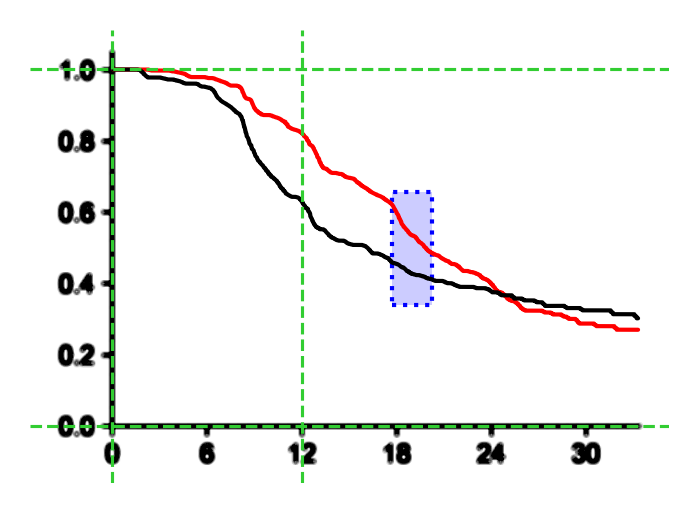

In [81]:
plt_df=df1.copy()
val1='X'
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)

plt_df=df1.copy()
plt_df=plt_df[['X','Y']].dropna()
x,y=plt_df['X'],plt_df['Y']
ax.plot(x,y,c='red')

plt_df=df2.copy()
plt_df=plt_df[['X','Y']].dropna()
x2,y2=plt_df['X'],plt_df['Y']
ax.plot(x2,y2,c='black')


plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.00001,c='black',marker='.')

# Check axis 
sr1=3265
sr0=755
ax.axhline(y=sr1,c='limegreen',lw=0.75,ls='dashed')
ax.axhline(y=sr0,c='limegreen',lw=0.75,ls='dashed')

m0=845
m12=2196
ax.axvline(x=m0,c='limegreen',lw=0.75,ls='dashed')
ax.axvline(x=m12,c='limegreen',lw=0.75,ls='dashed')

import matplotlib.patches as patches
r=patches.Rectangle(xy=(ms[18]-30,1600),
                    width=ms[2]-ms[0]+60,height=800,
                    ec='blue',fc=(0,0,1,0.2),ls='dotted')
ax.add_patch(r)

ax.set_axis_off()
ax.set_xlabel(val1)
ax.set_ylabel(val2)

In [82]:
xs=np.linspace(start=m0,stop=m36,num=1080)
ys_bev,ys_std=[],[]
for x in xs:
    y=df1[df1['X']==getNearestValue(list(df1['X']),x)]['Y'].values[0]
    ys_bev.append(y)
    
    y=df2[df2['X']==getNearestValue(list(df2['X']),x)]['Y'].values[0]
    ys_std.append(y)

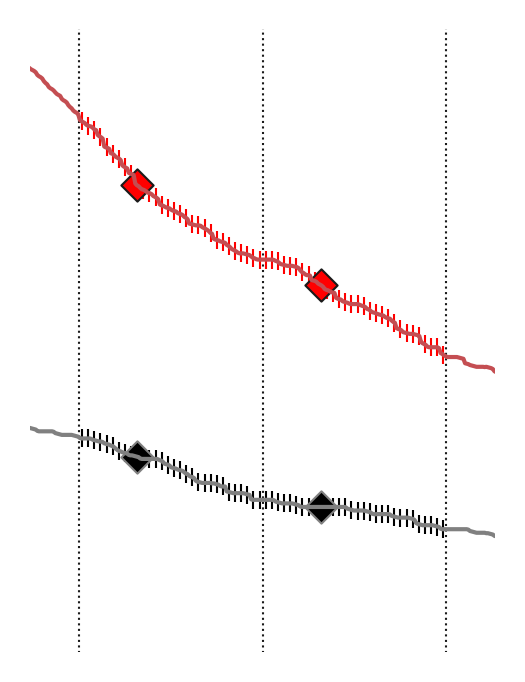

In [83]:
# Zoom
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(2,2.75))
ax=fig.add_subplot(111)
ax.plot(x,y,c='r')
ax.plot(x2,y2,c='grey')
ax.scatter(x3,y3,s=0.001,c='black')

ax.scatter(xs[18*30+9],ys_bev[18*30+9],s=30,c='red',marker='D',ec='k',linewidth=0.5,zorder=2)
ax.scatter(xs[18*30+9],ys_std[18*30+9],s=30,c='black',marker='D',ec='grey',linewidth=0.5,zorder=2)

ax.scatter(xs[19*30+9],ys_bev[19*30+9],s=30,c='red',marker='D',ec='k',linewidth=0.5,zorder=2)
ax.scatter(xs[19*30+9],ys_std[19*30+9],s=30,c='black',marker='D',ec='grey',linewidth=0.5,zorder=2)

ax.scatter(xs[18*30:20*30],ys_bev[18*30:20*30],s=20,c='red',marker='|',lw=0.5)
ax.scatter(xs[18*30:20*30],ys_std[18*30:20*30],s=20,c='black',marker='|',lw=0.5)


ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(ms[18]-30,ms[20]+30)
ax.set_ylim(1650,2350)

ax.set_axis_off()

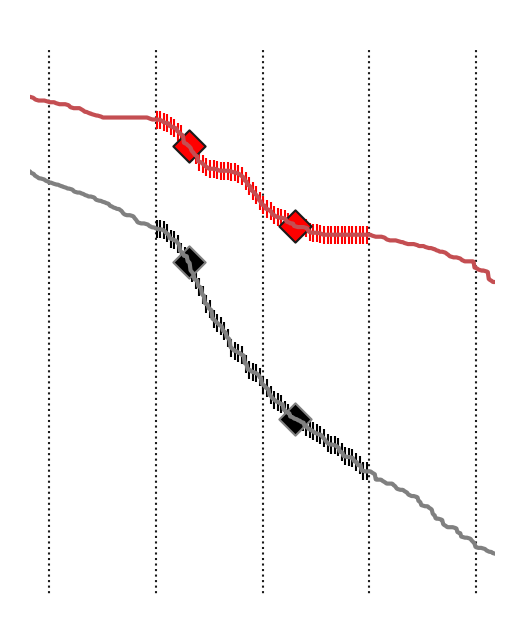

In [84]:
# Zoom
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(2,2.5))
ax=fig.add_subplot(111)
ax.plot(x,y,c='r')
ax.plot(x2,y2,c='grey')
ax.scatter(x3,y3,s=0.001,c='black')

ax.scatter(xs[8*30+9],ys_bev[8*30+9],s=30,c='red',marker='D',ec='k',linewidth=0.5,zorder=2)
ax.scatter(xs[8*30+9],ys_std[8*30+9],s=30,c='black',marker='D',ec='grey',linewidth=0.5,zorder=2)

ax.scatter(xs[9*30+9],ys_bev[9*30+9],s=30,c='red',marker='D',ec='k',linewidth=0.5,zorder=2)
ax.scatter(xs[9*30+9],ys_std[9*30+9],s=30,c='black',marker='D',ec='grey',linewidth=0.5,zorder=2)

ax.scatter(xs[8*30:10*30],ys_bev[8*30:10*30],s=20,c='red',marker='|',lw=0.5)
ax.scatter(xs[8*30:10*30],ys_std[8*30:10*30],s=20,c='black',marker='|',lw=0.5)


ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(ms[7]-20,ms[11]+20)
ax.set_ylim(2300,3300)

#ax.set_ylim(rs1[8]+20,rs2[8]-20)
#ax.set_xlabel(val1)
#ax.set_ylabel(val2)

#ax.legend(bbox_to_anchor=(1.1,1) )

ax.set_axis_off()

In [85]:
table=pd.DataFrame({'xs':xs, "ys_bev":ys_bev,'ys_std':ys_std})
table['day']=table.index

In [86]:
sr_bevs,sr_stds=[],[]
for idx in table.index:
    sr_bev=1-(sr1-table.loc[idx,'ys_bev'])/(sr1-sr0)
    sr_std=1-(sr1-table.loc[idx,'ys_std'])/(sr1-sr0)
    sr_bevs.append(sr_bev)
    sr_stds.append(sr_std)
    
table['survival_rate_bev']=sr_bevs
table['survival_rate_std']=sr_stds

In [87]:
table

xs  ys_bev  ys_std   day  survival_rate_bev  survival_rate_std
0      845.000000  3258.0  3258.0     0           0.997211           0.997211
1      848.750695  3258.0  3258.0     1           0.997211           0.997211
2      852.501390  3258.0  3258.0     2           0.997211           0.997211
3      856.252085  3258.0  3258.0     3           0.997211           0.997211
4      860.002780  3258.0  3258.0     4           0.997211           0.997211
...           ...     ...     ...   ...                ...                ...
1075  4876.997220  1428.5  1509.0  1075           0.268327           0.300398
1076  4880.747915  1428.5  1509.0  1076           0.268327           0.300398
1077  4884.498610  1428.5  1509.0  1077           0.268327           0.300398
1078  4888.249305  1428.5  1509.0  1078           0.268327           0.300398
1079  4892.000000  1428.5  1509.0  1079           0.268327           0.300398

[1080 rows x 6 columns]

In [88]:
# survival after 30 days
window=30
def_bevs=[]
def_stds=[]
risk_ratios=[]
for idx in table.index:
    if idx + window >= len(table):
        def_bevs.append(np.nan)
        def_stds.append(np.nan)
        risk_ratios.append(np.nan)
    else:
        def_bev=(table.loc[idx,'survival_rate_bev']-table.loc[idx+window,'survival_rate_bev'])/table.loc[idx,'survival_rate_bev']
        def_bevs.append(def_bev)
        def_std=(table.loc[idx,'survival_rate_std']-table.loc[idx+window,'survival_rate_std'])/table.loc[idx,'survival_rate_std']
        def_stds.append(def_std)
        
        if (def_bev==0)|(def_std==0):
            risk_ratios.append(np.nan)
        else:
            risk_ratios.append( np.log2(def_bev/def_std) )

table['prog_risk_bev']=def_bevs
table['prog_risk_std']=def_stds
table['prog_risk_ratio']=risk_ratios


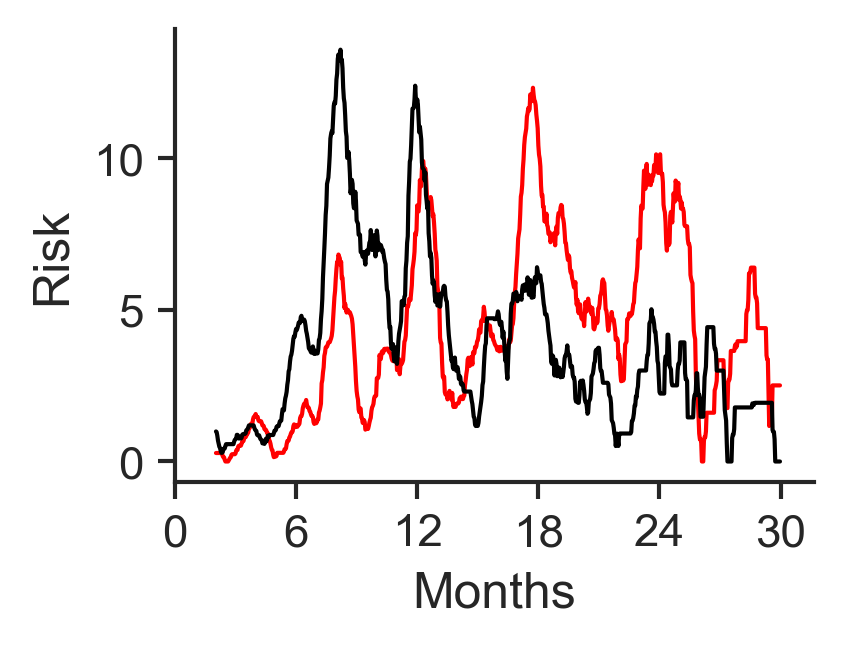

In [89]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev']*100
y2=plt_df2['prog_risk_std']*100
ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])

#ax.set_yticks([-2,-1,0,1,2])
#ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,950)
#ax.set_ylim(-3,3)

#ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0,zorder=2)

#ax.axvspan(xmin=30,xmax=12.6*30,color='lightgrey')
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

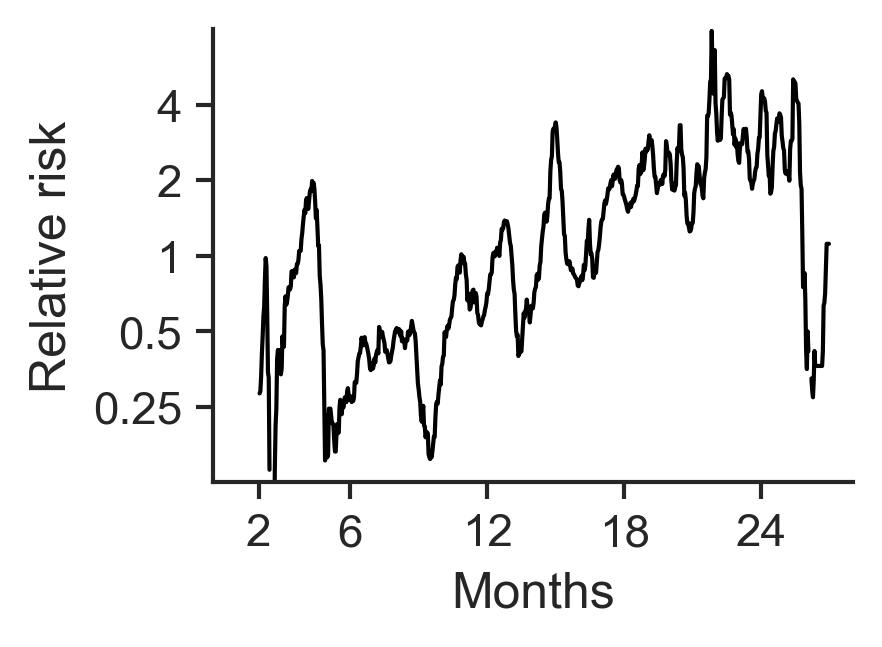

In [90]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio']
ax.plot(x,y,c='black',zorder=2)
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([60,180,360,540,720])
ax.set_xticklabels([2,6,12,18,24])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,840)
ax.set_ylim(-3,3)

#ax.axvspan(xmin=30,xmax=12.6*30,color='lightgrey')
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

In [91]:
# Moving avarage
window2=2*30
ratio_aves=[]
ratio_bevs=[]
ratio_stds=[]

for idx in table.index:
    if idx < window2:
        ratio_aves.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    elif idx > len(table.index)-window2:
        ratio_aves.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    else:
        ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
        ratio_bevs.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_bev'] ) )
        ratio_stds.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_std'] ) )

In [92]:
table['prog_risk_ratio_moving_average']=ratio_aves
table['prog_risk_bev_moving_average']=ratio_bevs
table['prog_risk_std_moving_average']=ratio_stds

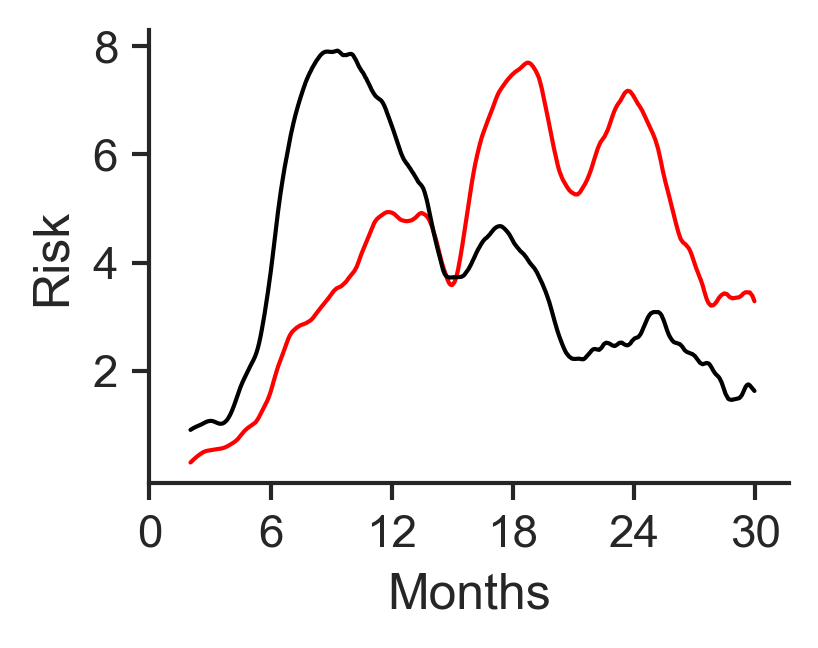

In [93]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev_moving_average']*100
y2=plt_df2['prog_risk_std_moving_average']*100

ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])
ax.set_yticks([2,4,6,8])

ax.set_xlim(0,950)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig('../results/ICON7A_pr_moving_average_from_reconstructed_KMC.pdf')

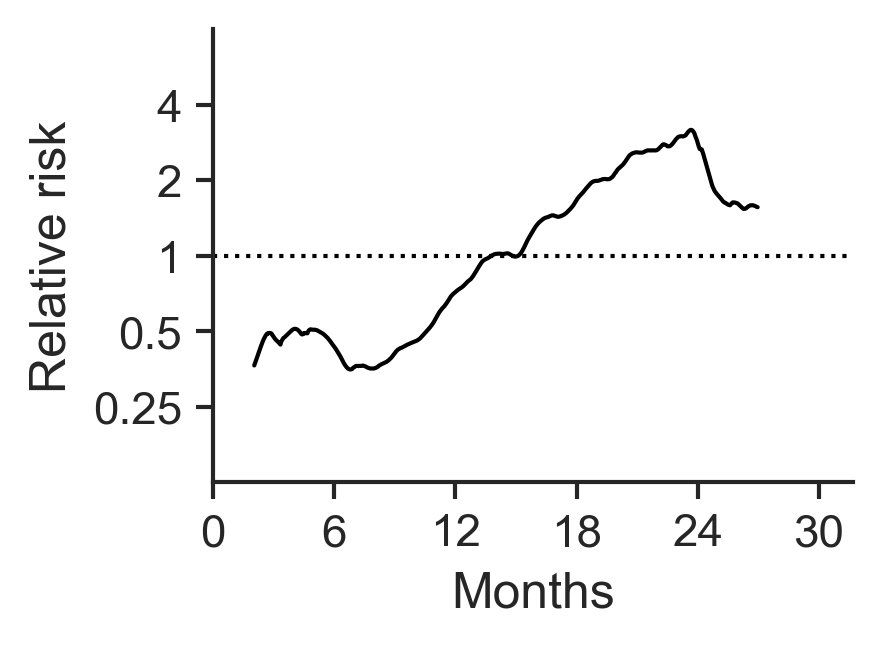

In [94]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio_moving_average']

ax.plot(plt_df2['day'],y,c='black',zorder=2)
ax.axhline(y=0,c='black',ls='dotted')
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])
ax.set_xlim(0,950)

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_ylim(-3,3)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig('../results/ICON7A_rr_moving_average_from_reconstructed_KMC.pdf')

* These results are almost the same as those from individual patient data.

# NEJM ICON7 NEJM2011

In [95]:
df1=pd.read_csv(input_dir+'ICON7_all_bev_plus.tsv',sep='\t')
df1.head()

X       Y
0  257  1866.5
1  258  1867.5
2  259  1868.0
3  260  1868.0
4  261  1868.5

In [96]:
df2=pd.read_csv(input_dir+'ICON7_all_bev_minus.tsv',sep='\t')
df2.head()

X       Y
0  280  1875.5
1  281  1873.0
2  282  1875.0
3  283  1875.0
4  284  1874.5

In [97]:
df3=pd.read_csv(input_dir+'ICON7_all_axis_label.tsv',sep='\t')
df3.head()

X   Y
0  1634  55
1  1635  55
2  1636  55
3  1637  55
4  1638  55

Text(0.5, 0, 'X')

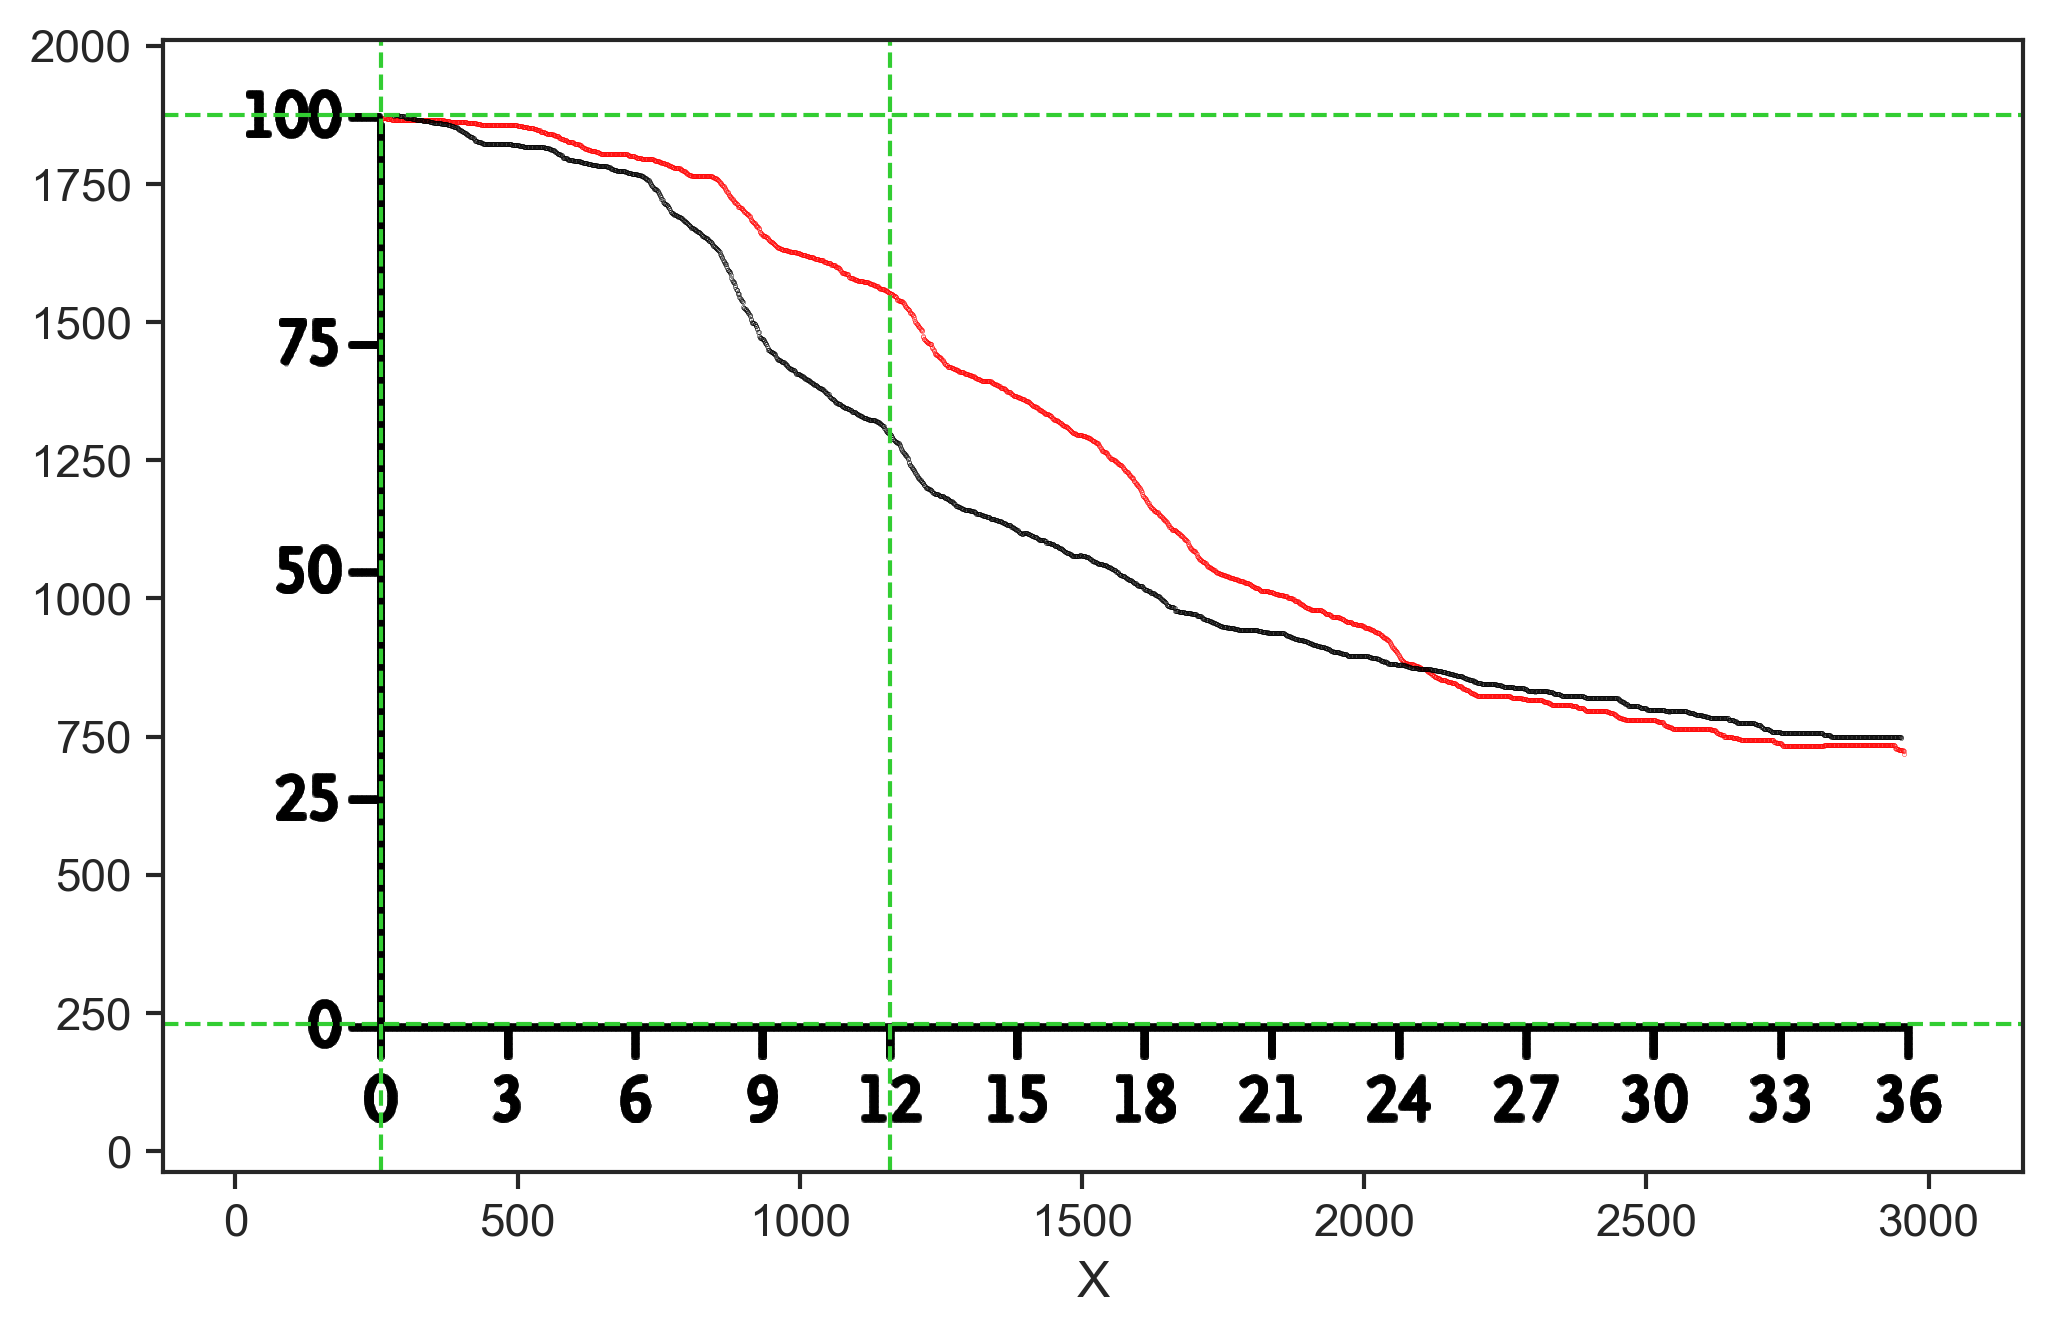

In [98]:
plt_df=df1.copy()
val1='X'
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(111)

plt_df=df1.copy()
plt_df=plt_df[['X','Y']].dropna()
x,y=plt_df['X'],plt_df['Y']
ax.scatter(x,y,s=0.01,c='red')

plt_df=df2.copy()
plt_df=plt_df[['X','Y']].dropna()
x2,y2=plt_df['X'],plt_df['Y']
ax.scatter(x2,y2,s=0.01,c='black')
plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

# Check axis 
sr1=1875
sr0=230
ax.axhline(y=sr1,c='limegreen',lw=1,ls='dashed')
ax.axhline(y=sr0,c='limegreen',lw=1,ls='dashed')

m0=258
m12=1160
ax.axvline(x=m0,c='limegreen',lw=1,ls='dashed')
ax.axvline(x=m12,c='limegreen',lw=1,ls='dashed')

plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

ax.set_xlabel(val1)
#ax.set_ylabel(val2)

In [99]:
m24=m0+2*(m12-m0)
m36=m0+3*(m12-m0)

In [100]:
ms=[m0+i*(m12-m0)/12 for i in range(0,36)]
rs1=[df1[df1['X']==getNearestValue(list(df1['X']),m)]['Y'].values[0] for m in ms]
rs2=[df2[df2['X']==getNearestValue(list(df2['X']),m)]['Y'].values[0] for m in ms]

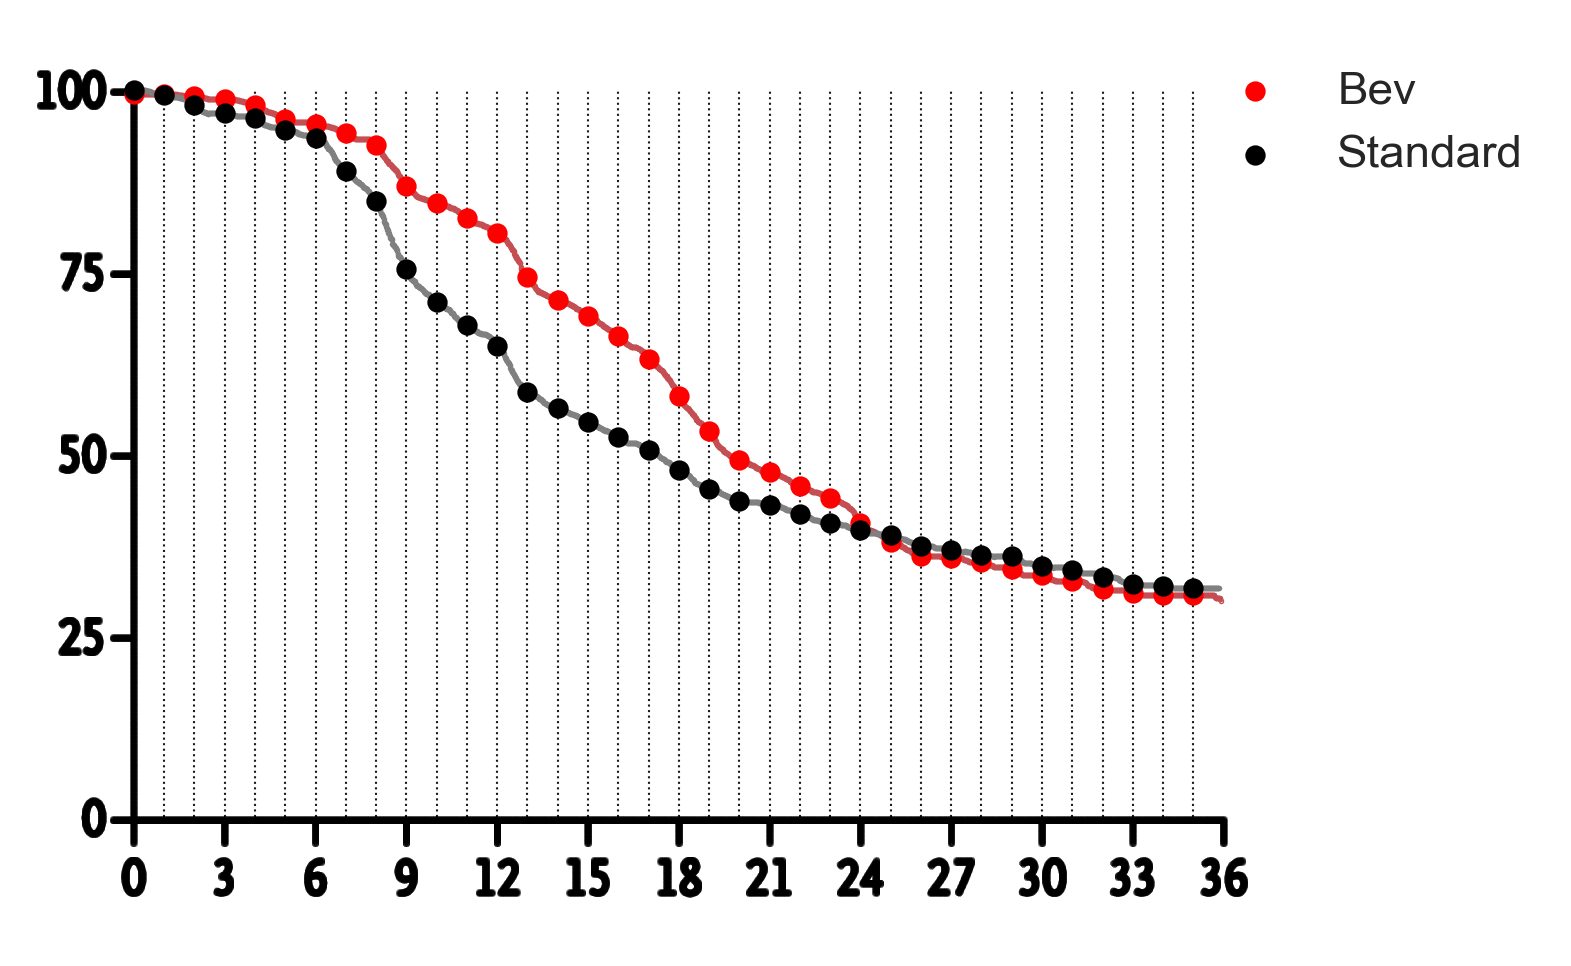

In [101]:
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=0.1,c='r')
ax.scatter(x2,y2,s=0.1,c='grey')
ax.scatter(x3,y3,s=0.001,c='black')
ax.scatter(ms,rs1,s=15,c='red',label='Bev')
ax.scatter(ms,rs2,s=15,c='black',label='Standard')

ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(0,m36+500)
ax.set_xlabel(val1)
ax.set_ylabel(val2)

ax.legend(bbox_to_anchor=(1.1,1) )

ax.set_axis_off()

In [102]:
xs=np.linspace(start=m0,stop=m36,num=1080)
ys_bev,ys_std=[],[]
for x in xs:
    y=df1[df1['X']==getNearestValue(list(df1['X']),x)]['Y'].values[0]
    ys_bev.append(y)
    
    y=df2[df2['X']==getNearestValue(list(df2['X']),x)]['Y'].values[0]
    ys_std.append(y)

In [103]:
table=pd.DataFrame({'xs':xs, "ys_bev":ys_bev,'ys_std':ys_std})
table['day']=table.index
table

xs  ys_bev  ys_std   day
0      258.000000  1867.5  1875.5     0
1      260.507878  1868.5  1875.5     1
2      263.015755  1868.5  1875.5     2
3      265.523633  1868.5  1875.5     3
4      268.031511  1868.0  1875.5     4
...           ...     ...     ...   ...
1075  2953.968489   725.5   748.0  1075
1076  2956.476367   724.0   748.0  1076
1077  2958.984245   719.0   748.0  1077
1078  2961.492122   719.0   748.0  1078
1079  2964.000000   719.0   748.0  1079

[1080 rows x 4 columns]

In [104]:
sr_bevs,sr_stds=[],[]
for idx in table.index:
    sr_bev=1-(sr1-table.loc[idx,'ys_bev'])/(sr1-sr0)
    sr_std=1-(sr1-table.loc[idx,'ys_std'])/(sr1-sr0)
    sr_bevs.append(sr_bev)
    sr_stds.append(sr_std)
    
table['survival_rate_bev']=sr_bevs
table['survival_rate_std']=sr_stds

In [105]:
# survival after 30 days
window=30
def_bevs=[]
def_stds=[]
risk_ratios=[]
for idx in table.index:
    if idx + window >= len(table):
        def_bevs.append(np.nan)
        def_stds.append(np.nan)
        risk_ratios.append(np.nan)
    else:
        def_bev=(table.loc[idx,'survival_rate_bev']-table.loc[idx+window,'survival_rate_bev'])/table.loc[idx,'survival_rate_bev']
        def_bevs.append(def_bev)
        def_std=(table.loc[idx,'survival_rate_std']-table.loc[idx+window,'survival_rate_std'])/table.loc[idx,'survival_rate_std']
        def_stds.append(def_std)
        
        if (def_bev==0)|(def_std==0):
            risk_ratios.append(np.nan)
        else:
            risk_ratios.append( np.log2(def_bev/def_std) )

table['prog_risk_bev']=def_bevs
table['prog_risk_std']=def_stds
table['prog_risk_ratio']=risk_ratios

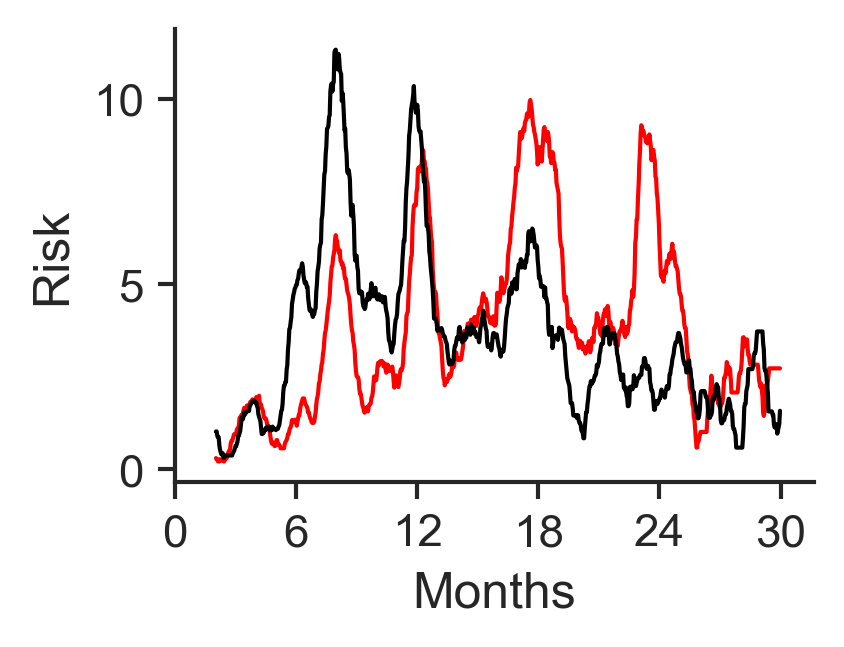

In [106]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.75,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>60)&(plt_df['day']<900)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev']*100
y2=plt_df2['prog_risk_std']*100
ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])

ax.set_xlim(0,950)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig(output_dir+'ICON7_progression_risk.pdf')

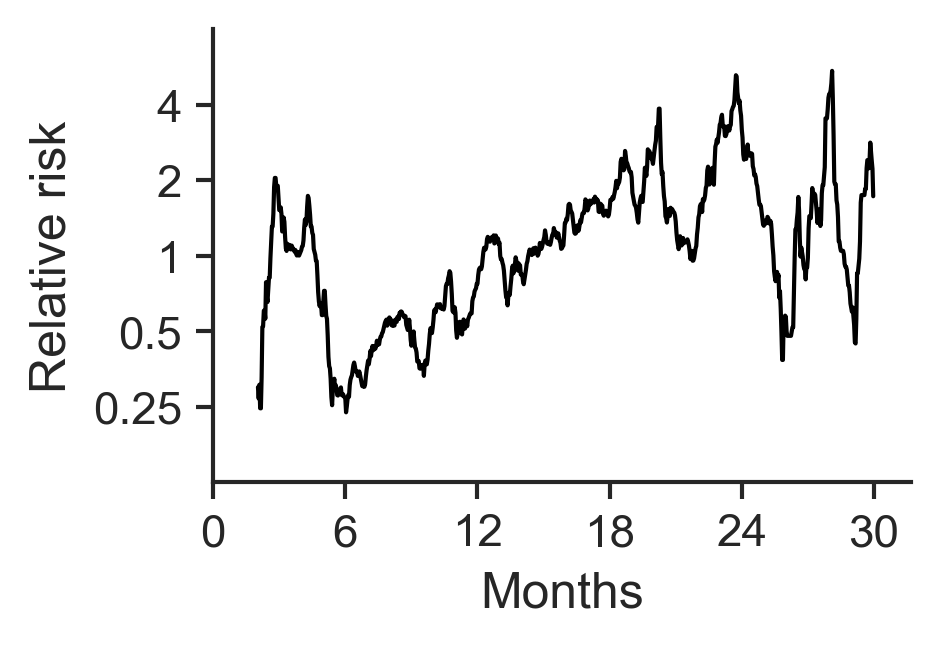

In [107]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>60)&(plt_df['day']<900)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio']
ax.plot(x,y,c='black',zorder=2)
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,950)
ax.set_ylim(-3,3)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)


plt.savefig(output_dir+'ICON7_relarive_risk.pdf')

In [108]:
# Moving avarage
window2=2*30
ratio_aves=[]
ratio_sds=[]
ratio_bevs=[]
ratio_stds=[]

for idx in table.index:
    if idx < window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    elif idx > len(table.index)-window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    else:
        ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
        ratio_sds.append( np.nanstd( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) ) 
        ratio_bevs.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_bev'] ) )
        ratio_stds.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_std'] ) )

In [109]:
table['prog_risk_ratio_moving_average']=ratio_aves
table['prog_risk_bev_moving_average']=ratio_bevs
table['prog_risk_std_moving_average']=ratio_stds

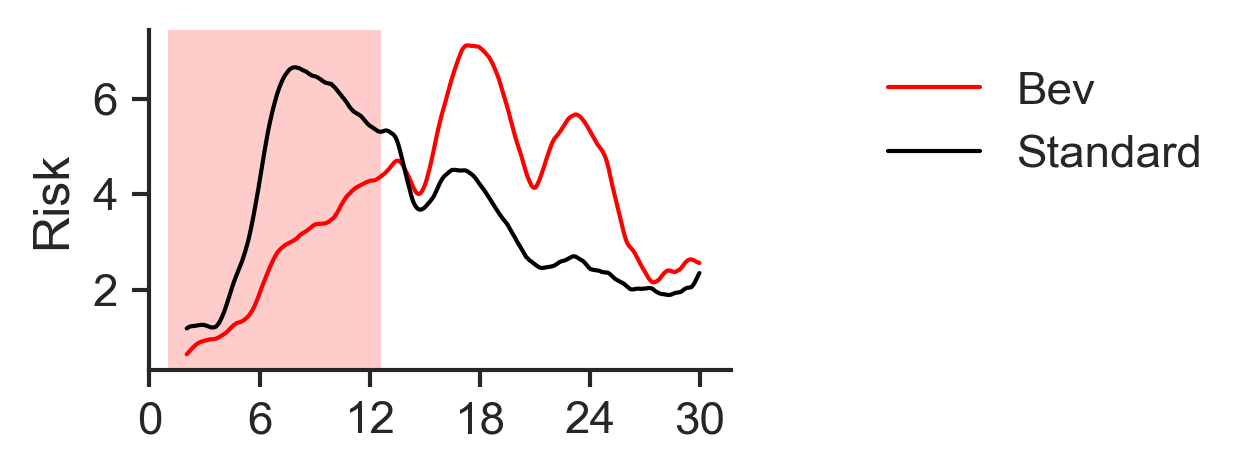

In [110]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.5,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev_moving_average']*100
y2=plt_df2['prog_risk_std_moving_average']*100

ax.plot(x,y1,c='red',zorder=2,label='Bev')
ax.plot(x,y2,c='black',zorder=2,label='Standard')

ax.set_ylabel('Risk')
ax.set_xlabel('')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])
ax.set_xlim(0,950)
ax.set_yticks([2,4,6])

ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0,zorder=2)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

ax.legend(bbox_to_anchor=(1.2,1))
plt.savefig(output_dir+'ICON7_pr_moving_average.pdf')

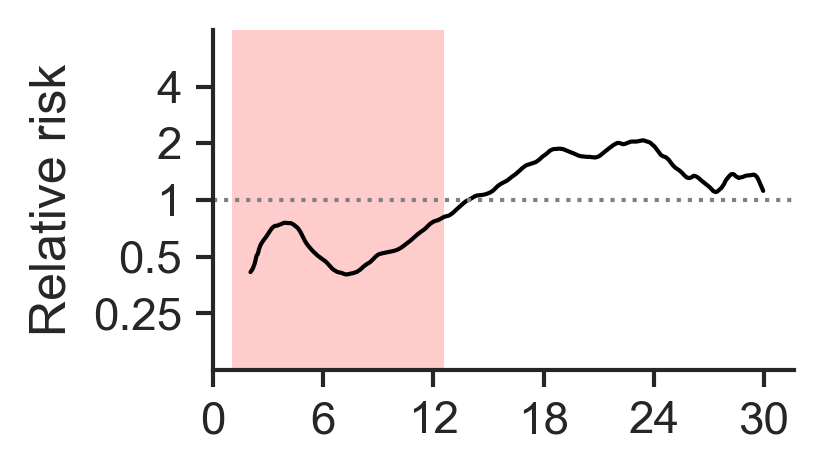

In [111]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.5,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio_moving_average']

ax.plot(plt_df2['day'],y,c='black',zorder=2)
ax.axhline(y=0,c='grey',ls='dotted')
ax.set_ylabel('Relative risk')
ax.set_xlabel('')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])
ax.set_xlim(0,950)

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_ylim(-3,3)

ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0,zorder=2)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig(output_dir+'ICON7_rr_moving_average')

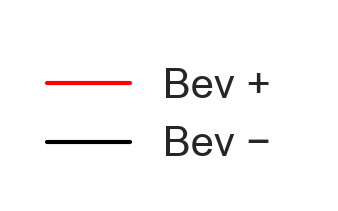

In [112]:
# legend
fig=plt.figure(figsize=(1,0.5))
ax=fig.add_subplot(111)

labels = ["Bev +", "Bev −"]
colors = ["red", "black"]
for i,label in enumerate(labels):
    ax.plot([], [], marker="", color=colors[i], label=label)
    ax.legend(frameon=False, fontsize=10,
                   ncol=1, columnspacing=1)
ax.set_axis_off()
plt.savefig(output_dir+'Bev_label.pdf')

In [113]:
dict_rename={'xs':'X', 'ys_bev':'Y_bev', 'ys_std':'Y_std', 'prog_risk_ratio': 'log2_risk_ratio',
       'prog_risk_ratio_moving_average':'log2_risk_ratio_ma', 'prog_risk_bev_moving_average':'prog_risk_bev_ma',
       'prog_risk_std_moving_average':'prog_risk_std_ma'}

In [114]:
table_w=table.dropna(subset=['prog_risk_bev_moving_average','prog_risk_std_moving_average'])
table_w=table_w.set_index('day')
table_w=table_w.rename(columns=dict_rename)
table_w.to_csv(output_dir+'ICON7_all_table.tsv',sep='\t')

## ICON7 high risk

In [115]:
df1=pd.read_csv(input_dir+'ICON7_highrisk_bev_plus.tsv',sep='\t')
df1.head()

X       Y
0  146  1754.0
1  147  1754.5
2  148  1755.0
3  149  1755.5
4  150  1757.5

In [116]:
df2=pd.read_csv(input_dir+'ICON7_highrisk_bev_minus.tsv',sep='\t')
df2.head()

X       Y
0  177  1738.0
1  178  1738.0
2  179  1738.0
3  180  1738.0
4  181  1738.0

In [117]:
df3=pd.read_csv(input_dir+'ICON7_highrisk_axis_label.tsv',sep='\t')
df3.head()

X   Y
0  139  56
1  140  56
2  141  56
3  142  56
4  143  56

Text(0, 0.5, 'Y')

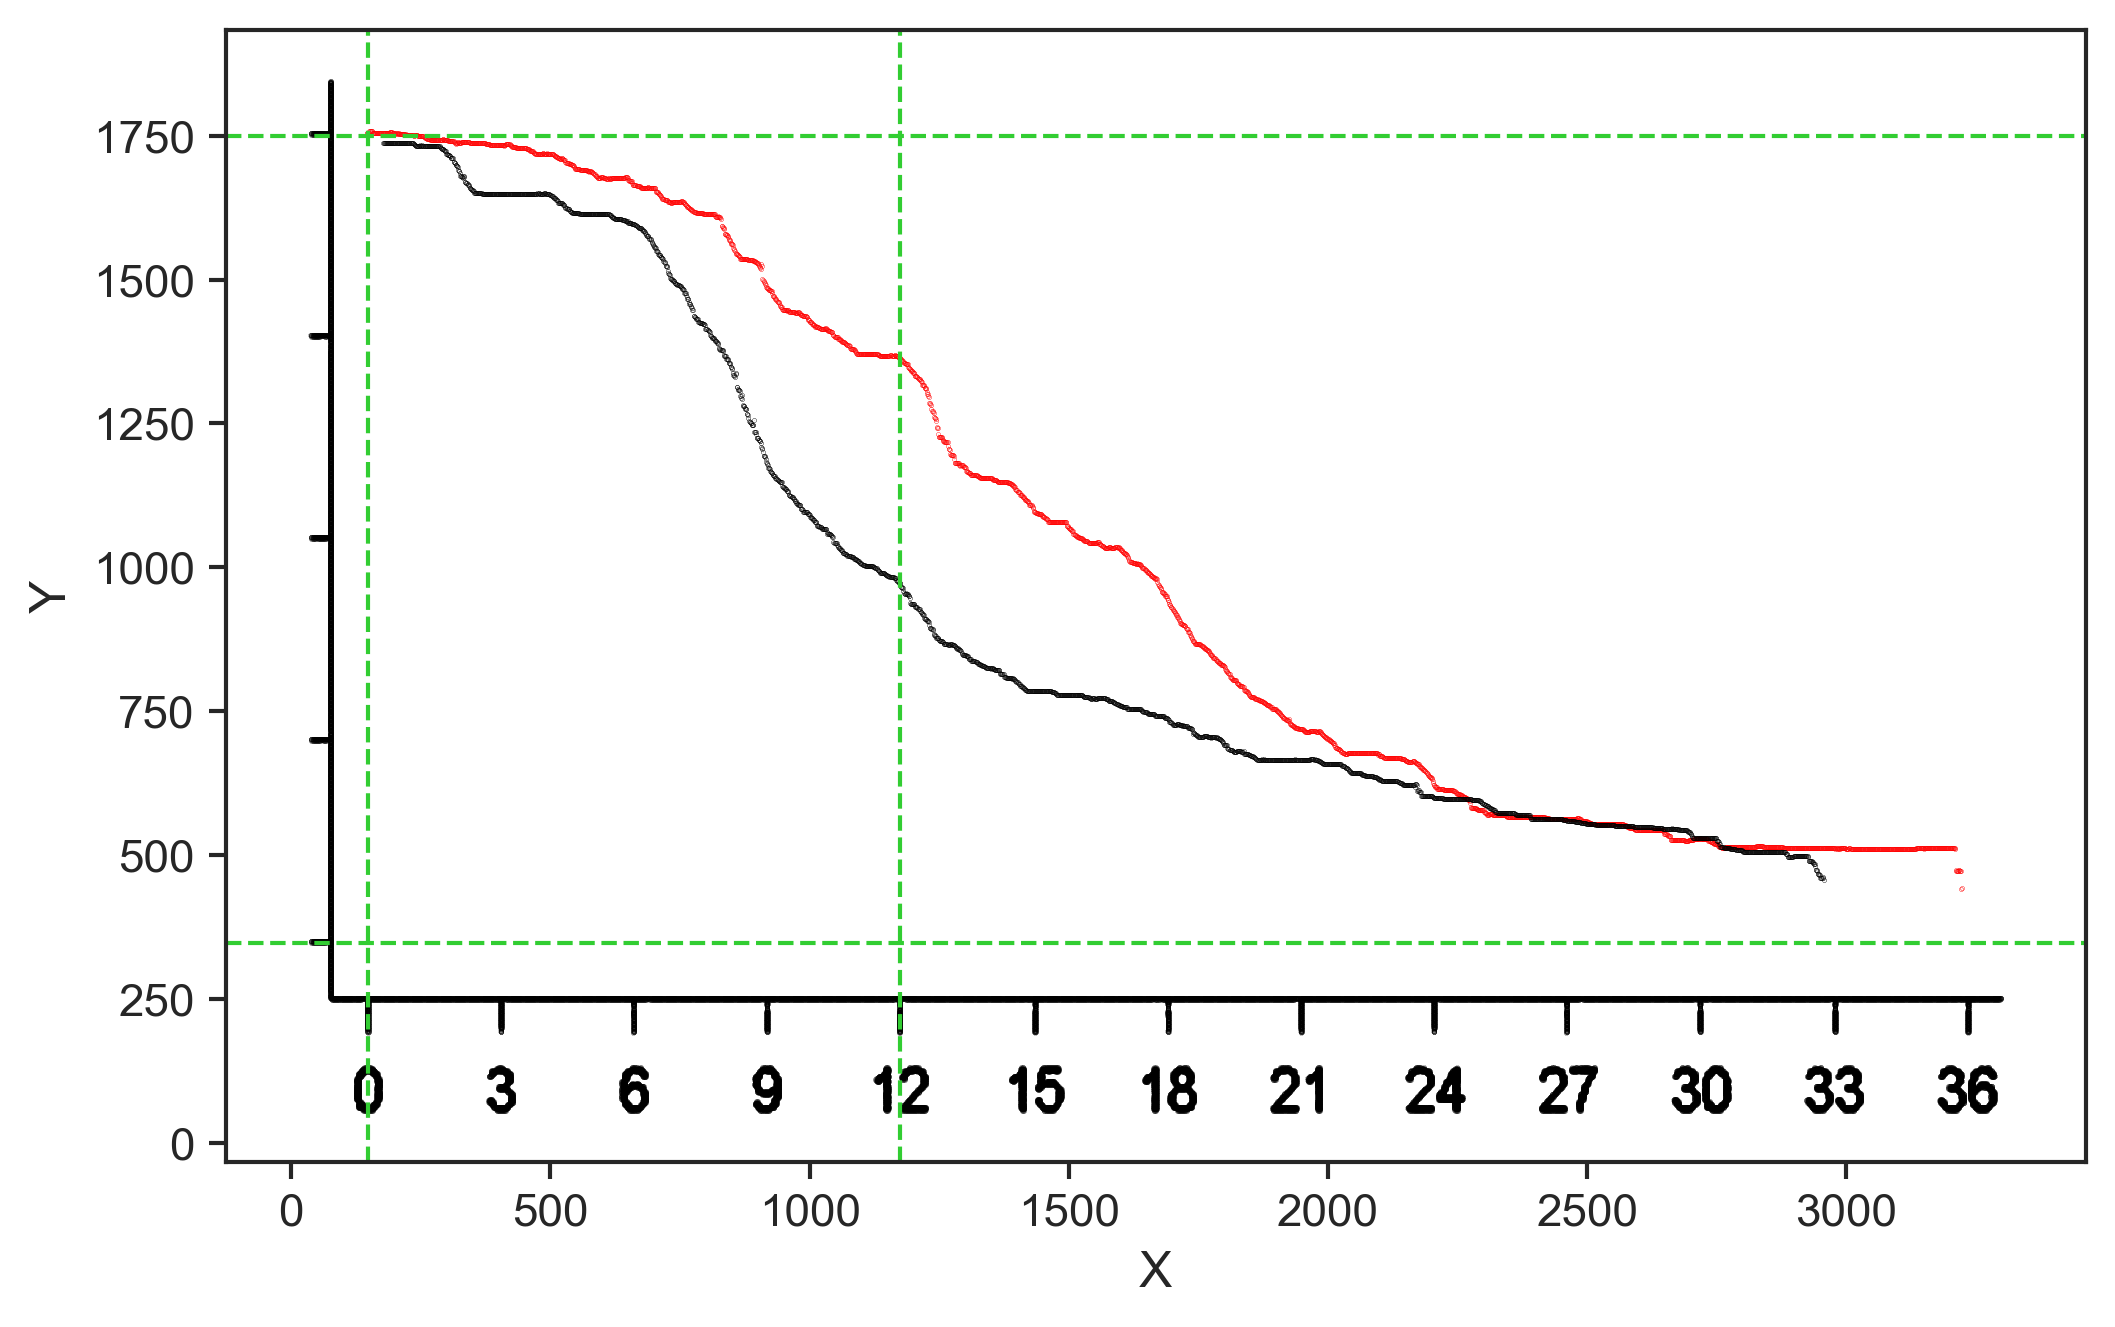

In [118]:
plt_df=df1.copy()
val1='X'
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(111)

plt_df=df1.copy()
plt_df=plt_df[['X','Y']].dropna()
x,y=plt_df['X'],plt_df['Y']
ax.scatter(x,y,s=0.01,c='red')

plt_df=df2.copy()
plt_df=plt_df[['X','Y']].dropna()
x2,y2=plt_df['X'],plt_df['Y']
ax.scatter(x2,y2,s=0.01,c='black')
plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

# Check axis 
sr1=1750
sr0=348
ax.axhline(y=sr1,c='limegreen',lw=1,ls='dashed')
ax.axhline(y=sr0,c='limegreen',lw=1,ls='dashed')

m0=148
m12=1175
ax.axvline(x=m0,c='limegreen',lw=1,ls='dashed')
ax.axvline(x=m12,c='limegreen',lw=1,ls='dashed')

plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

ax.set_xlabel(val1)
ax.set_ylabel(val2)

In [119]:
m24=m0+2*(m12-m0)
m36=m0+3*(m12-m0)

In [120]:
ms=[m0+i*(m12-m0)/12 for i in range(0,25)]
rs1=[df1[df1['X']==getNearestValue(list(df1['X']),m)]['Y'].values[0] for m in ms]
rs2=[df2[df2['X']==getNearestValue(list(df2['X']),m)]['Y'].values[0] for m in ms]

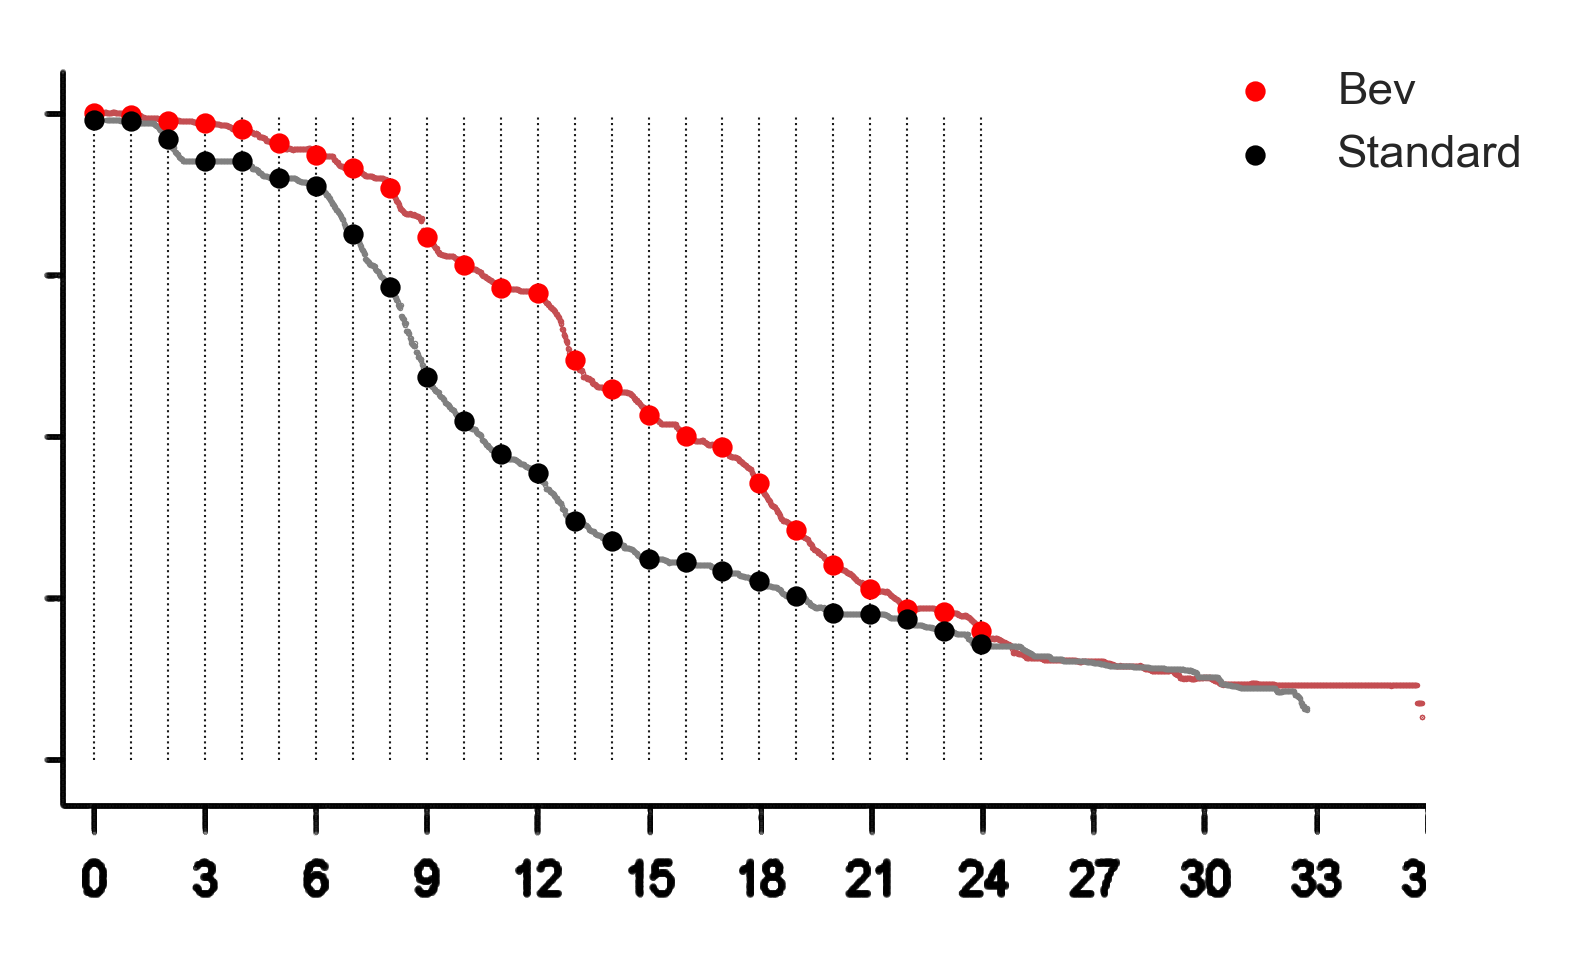

In [121]:
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=0.1,c='r')
ax.scatter(x2,y2,s=0.1,c='grey')
ax.scatter(x3,y3,s=0.001,c='black')
ax.scatter(ms,rs1,s=15,c='red',label='Bev')
ax.scatter(ms,rs2,s=15,c='black',label='Standard')

ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(0,m36)
ax.set_xlabel(val1)
ax.set_ylabel(val2)

ax.legend(bbox_to_anchor=(1.1,1) )

ax.set_axis_off()

In [122]:
xs=np.linspace(start=m0,stop=m36,num=1080)
ys_bev,ys_std=[],[]
for x in xs:
    y=df1[df1['X']==getNearestValue(list(df1['X']),x)]['Y'].values[0]
    ys_bev.append(y)
    
    y=df2[df2['X']==getNearestValue(list(df2['X']),x)]['Y'].values[0]
    ys_std.append(y)

In [123]:
table=pd.DataFrame({'xs':xs, "ys_bev":ys_bev,'ys_std':ys_std})
table['day']=table.index
table

xs  ys_bev  ys_std   day
0      148.000000  1755.0  1738.0     0
1      150.855422  1758.0  1738.0     1
2      153.710843  1758.0  1738.0     2
3      156.566265  1755.5  1738.0     3
4      159.421687  1755.0  1738.0     4
...           ...     ...     ...   ...
1075  3217.578313   473.5   457.0  1075
1076  3220.433735   472.5   457.0  1076
1077  3223.289157   442.0   457.0  1077
1078  3226.144578   442.0   457.0  1078
1079  3229.000000   442.0   457.0  1079

[1080 rows x 4 columns]

In [124]:
sr_bevs,sr_stds=[],[]
for idx in table.index:
    sr_bev=1-(sr1-table.loc[idx,'ys_bev'])/(sr1-sr0)
    sr_std=1-(sr1-table.loc[idx,'ys_std'])/(sr1-sr0)
    sr_bevs.append(sr_bev)
    sr_stds.append(sr_std)
    
table['survival_rate_bev']=sr_bevs
table['survival_rate_std']=sr_stds

In [125]:
# survival after 30 days
window=30
def_bevs=[]
def_stds=[]
risk_ratios=[]
for idx in table.index:
    if idx + window >= len(table):
        def_bevs.append(np.nan)
        def_stds.append(np.nan)
        risk_ratios.append(np.nan)
    else:
        def_bev=(table.loc[idx,'survival_rate_bev']-table.loc[idx+window,'survival_rate_bev'])/table.loc[idx,'survival_rate_bev']
        def_bevs.append(def_bev)
        def_std=(table.loc[idx,'survival_rate_std']-table.loc[idx+window,'survival_rate_std'])/table.loc[idx,'survival_rate_std']
        def_stds.append(def_std)
        
        if (def_bev==0)|(def_std==0):
            risk_ratios.append(np.nan)
        else:
            risk_ratios.append( np.log2(def_bev/def_std) )

table['prog_risk_bev']=def_bevs
table['prog_risk_std']=def_stds
table['prog_risk_ratio']=risk_ratios


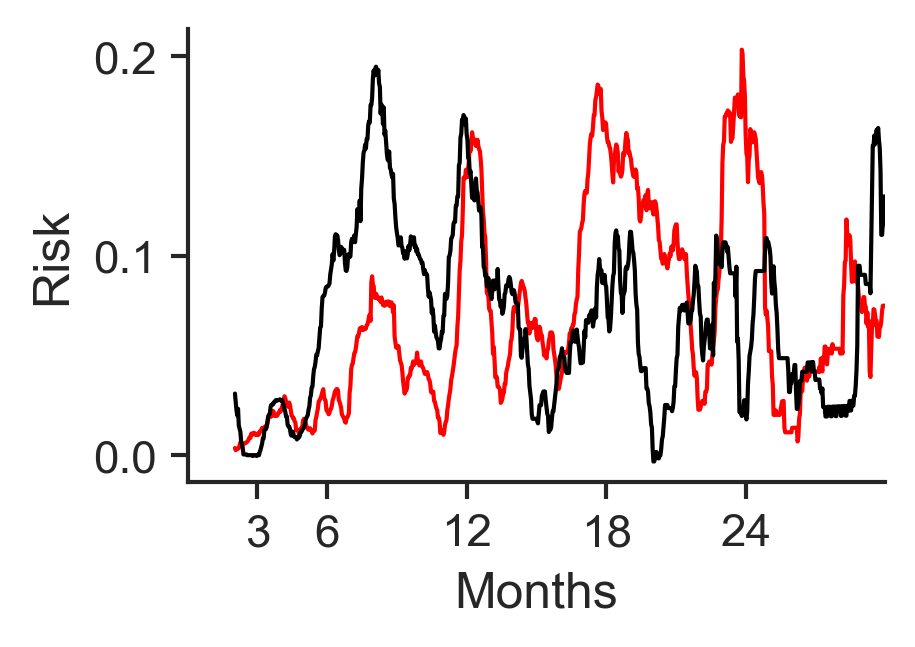

In [126]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev']
y2=plt_df2['prog_risk_std']
ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540,720])
ax.set_xticklabels([3,6,12,18,24])

ax.set_xlim(0,900)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

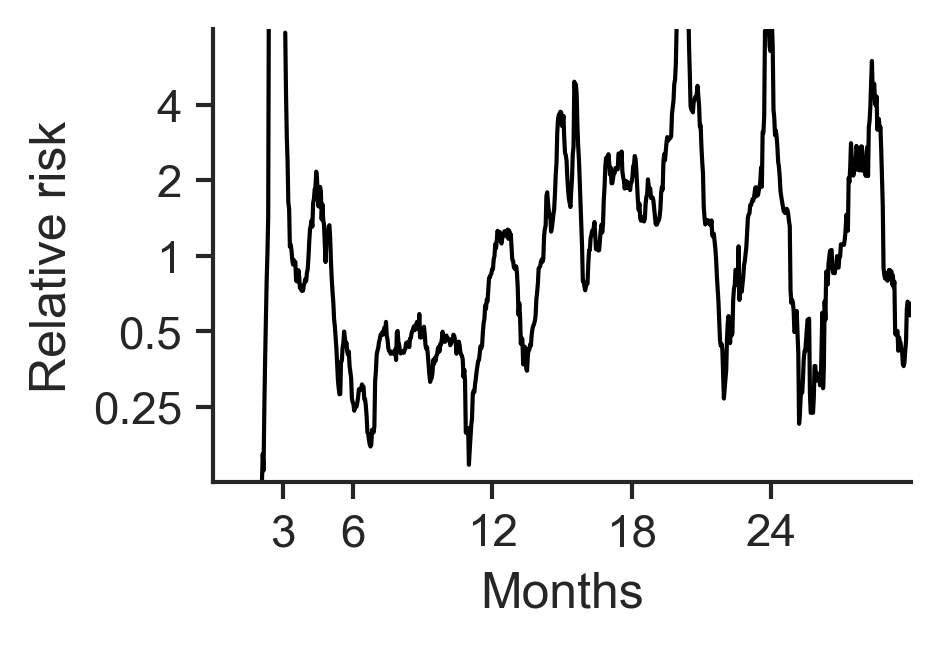

In [127]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio']
ax.plot(x,y,c='black',zorder=2)
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540,720])
ax.set_xticklabels([3,6,12,18,24])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,900)
ax.set_ylim(-3,3)

#ax.axvspan(xmin=30,xmax=12.6*30,color='lightgrey')
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

In [128]:
# Moving avarage
window2=2*30
ratio_aves=[]
ratio_sds=[]
ratio_bevs=[]
ratio_stds=[]

for idx in table.index:
    if idx < window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    elif idx > len(table.index)-window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    else:
        ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
        ratio_sds.append( np.nanstd( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) ) 
        ratio_bevs.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_bev'] ) )
        ratio_stds.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_std'] ) )

In [129]:
table['prog_risk_ratio_moving_average']=ratio_aves
table['prog_risk_bev_moving_average']=ratio_bevs
table['prog_risk_std_moving_average']=ratio_stds

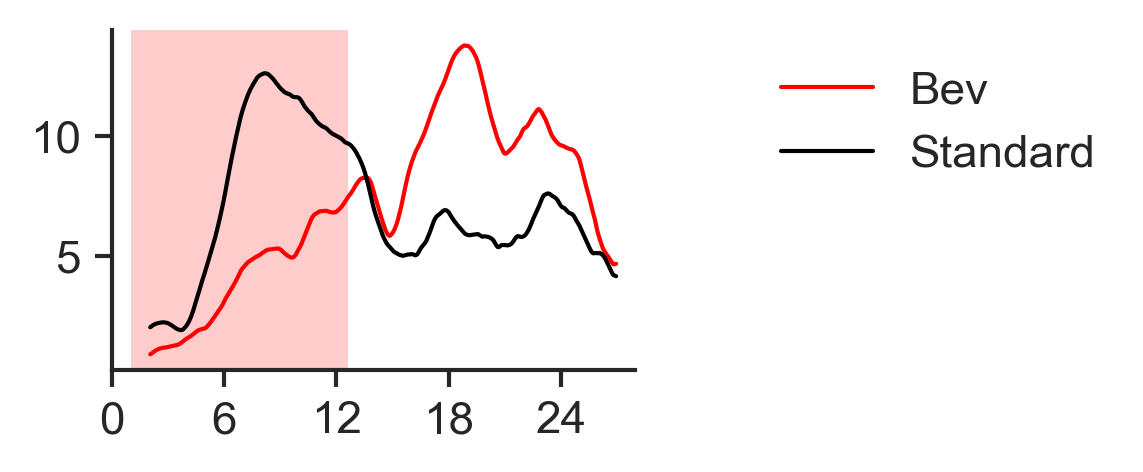

In [130]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.25,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev_moving_average']*100
y2=plt_df2['prog_risk_std_moving_average']*100

ax.plot(x,y1,c='red',zorder=2,label='Bev')
ax.plot(x,y2,c='black',zorder=2,label='Standard')

#ax.set_ylabel('Risk')
#ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])
ax.set_xlim(0,840)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0)
ax.legend(bbox_to_anchor=(1.2,1))
plt.savefig('../results/ICON7_highrisk_pr_moving_average.pdf')

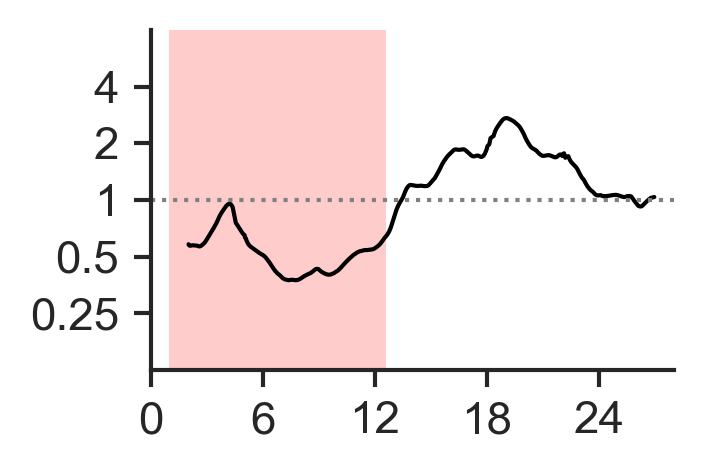

In [131]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.25,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio_moving_average']

ax.plot(plt_df2['day'],y,c='black',zorder=2)
ax.axhline(y=0,c='grey',ls='dotted')
#ax.set_ylabel('Relative risk')
#ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])
ax.set_xlim(0,840)

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_ylim(-3,3)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0)
plt.savefig('../results/ICON7_highrisk_rr_moving_average.pdf')

In [132]:
dict_rename={'xs':'X', 'ys_bev':'Y_bev', 'ys_std':'Y_std', 'prog_risk_ratio': 'log2_risk_ratio',
       'prog_risk_ratio_moving_average':'log2_risk_ratio_ma', 'prog_risk_bev_moving_average':'prog_risk_bev_ma',
       'prog_risk_std_moving_average':'prog_risk_std_ma'}

In [133]:
out_prefix='ICON7_highrisk'

In [134]:
table_w=table.dropna(subset=['prog_risk_bev_moving_average','prog_risk_std_moving_average'])
table_w=table_w.set_index('day')
table_w=table_w.rename(columns=dict_rename)
table_w.to_csv('../results/'+out_prefix+'_table.tsv',sep='\t')

## ICON7 low risk

In [135]:
df1=pd.read_csv('../data/ICON7_lowrisk_bev_plus.tsv',sep='\t')
df1.head()

X       Y
0  146  1752.0
1  147  1752.5
2  148  1752.5
3  149  1753.0
4  150  1749.5

In [136]:
df2=pd.read_csv('../data/ICON7_lowrisk_bev_minus.tsv',sep='\t')
df2.head()

X       Y
0  159  1745.0
1  160  1747.0
2  161  1747.0
3  162  1747.0
4  163  1747.0

In [137]:
df3=pd.read_csv('../data/ICON7_lowrisk_axis_label.tsv',sep='\t')
df3.head()

X   Y
0  139  56
1  140  56
2  141  56
3  142  56
4  143  56

Text(0, 0.5, 'Y')

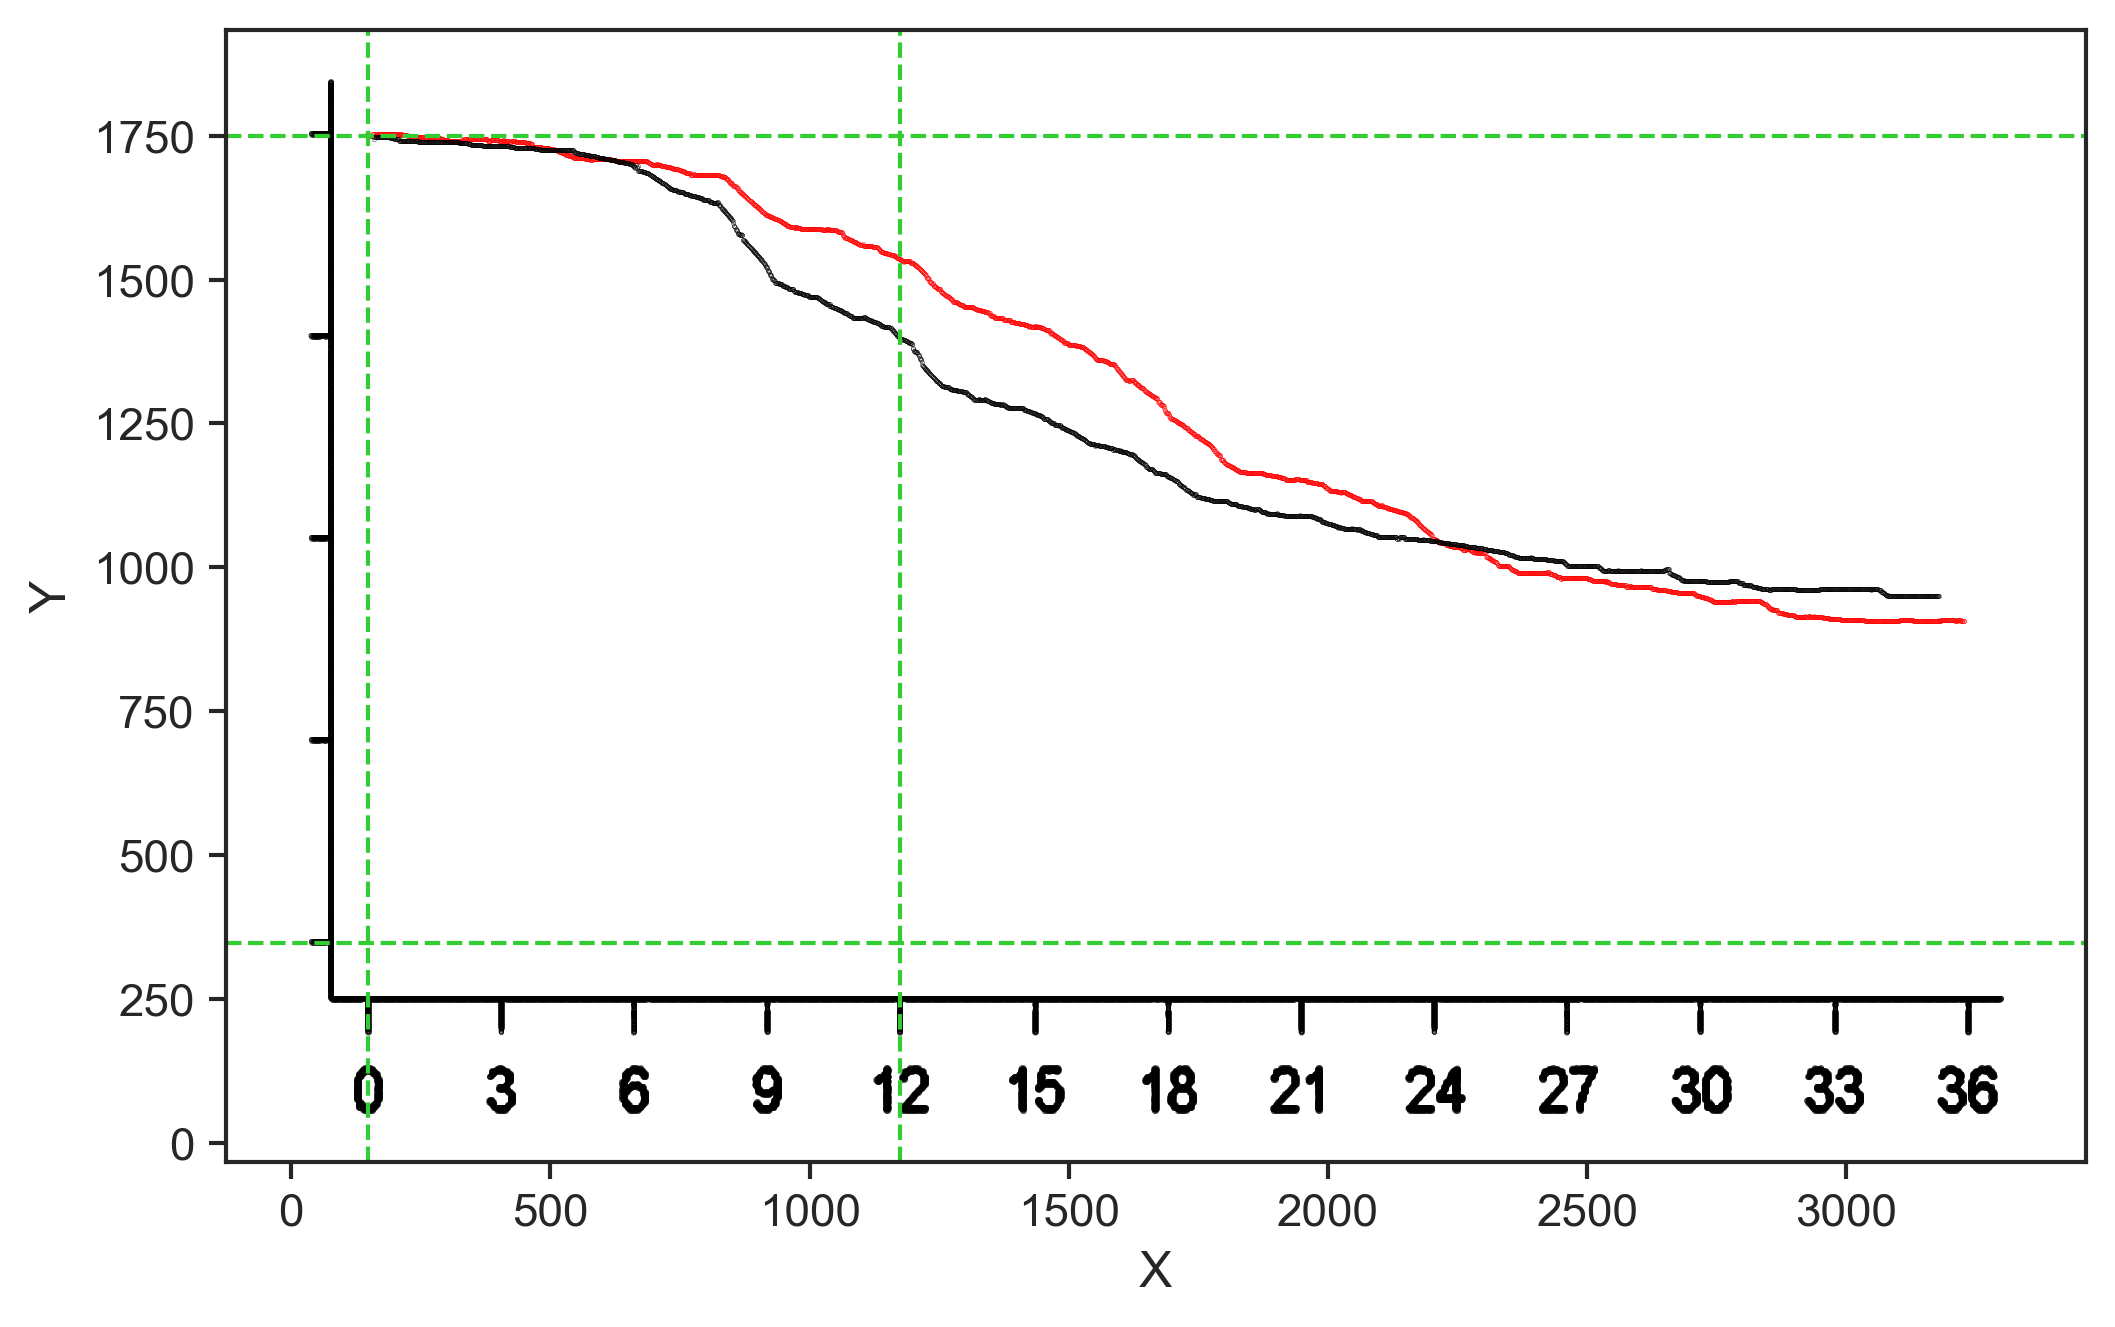

In [138]:
plt_df=df1.copy()
val1='X'
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(111)

plt_df=df1.copy()
plt_df=plt_df[['X','Y']].dropna()
x,y=plt_df['X'],plt_df['Y']
ax.scatter(x,y,s=0.01,c='red')

plt_df=df2.copy()
plt_df=plt_df[['X','Y']].dropna()
x2,y2=plt_df['X'],plt_df['Y']
ax.scatter(x2,y2,s=0.01,c='black')
plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

# Check axis 
sr1=1750
sr0=348
ax.axhline(y=sr1,c='limegreen',lw=1,ls='dashed')
ax.axhline(y=sr0,c='limegreen',lw=1,ls='dashed')

m0=148
m12=1175
ax.axvline(x=m0,c='limegreen',lw=1,ls='dashed')
ax.axvline(x=m12,c='limegreen',lw=1,ls='dashed')

plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

ax.set_xlabel(val1)
ax.set_ylabel(val2)

In [139]:
m24=m0+2*(m12-m0)
m36=m0+3*(m12-m0)

In [140]:
ms=[m0+i*(m12-m0)/12 for i in range(0,25)]
rs1=[df1[df1['X']==getNearestValue(list(df1['X']),m)]['Y'].values[0] for m in ms]
rs2=[df2[df2['X']==getNearestValue(list(df2['X']),m)]['Y'].values[0] for m in ms]

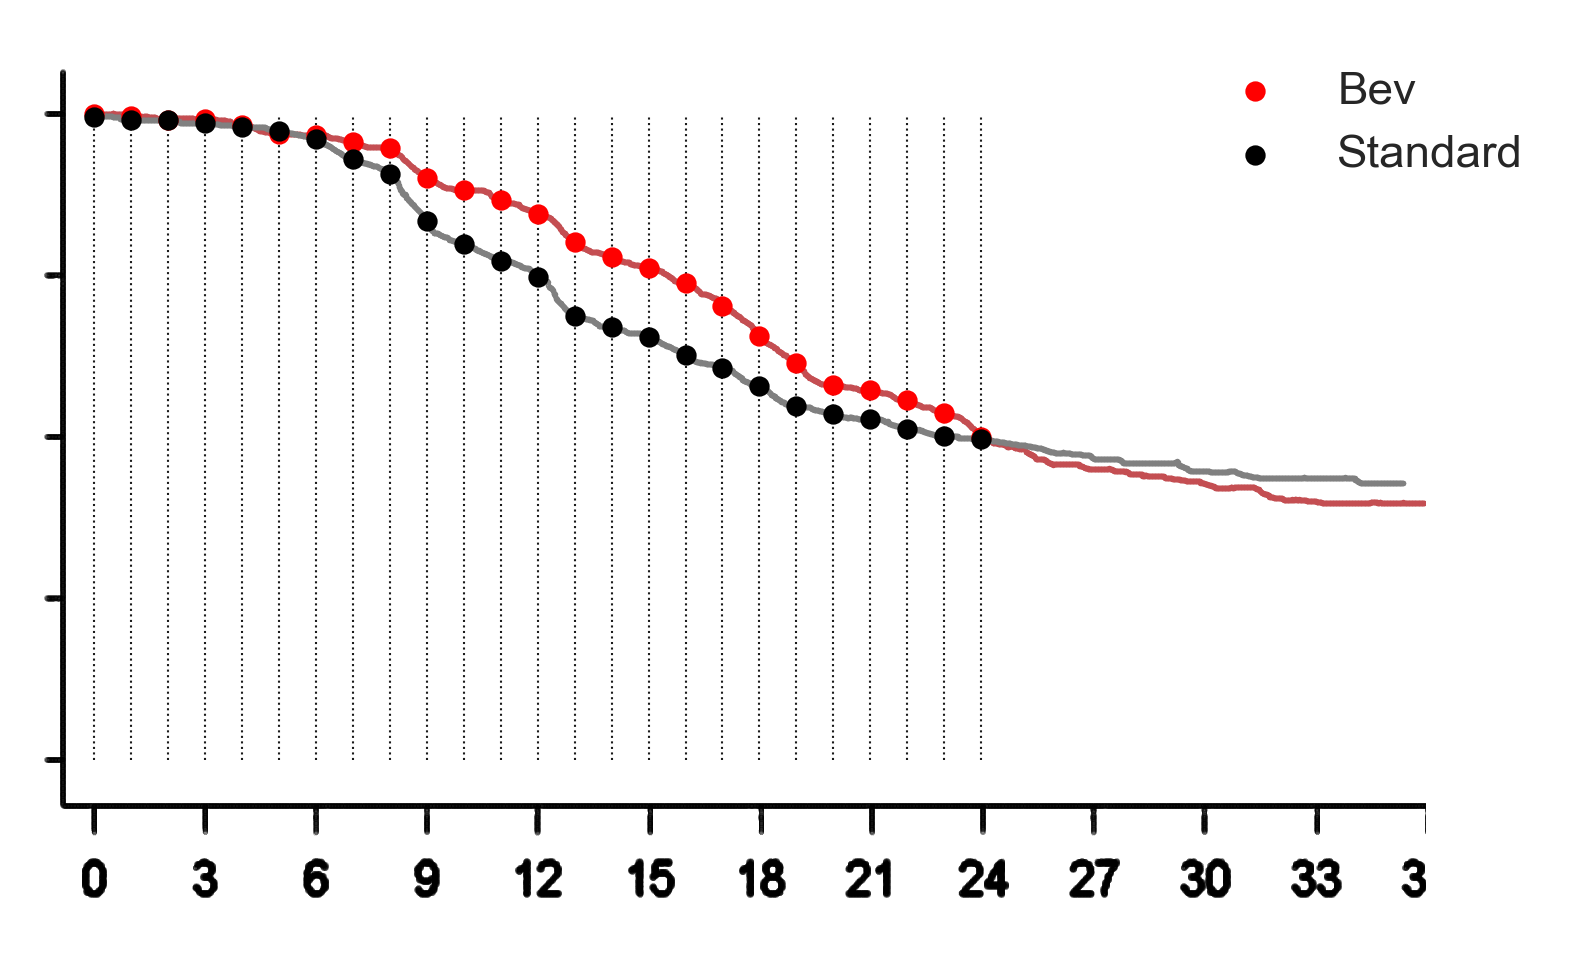

In [141]:
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=0.1,c='r')
ax.scatter(x2,y2,s=0.1,c='grey')
ax.scatter(x3,y3,s=0.001,c='black')
ax.scatter(ms,rs1,s=15,c='red',label='Bev')
ax.scatter(ms,rs2,s=15,c='black',label='Standard')

ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(0,m36)
ax.set_xlabel(val1)
ax.set_ylabel(val2)

ax.legend(bbox_to_anchor=(1.1,1) )

ax.set_axis_off()

In [142]:
xs=np.linspace(start=m0,stop=m36,num=1080)
ys_bev,ys_std=[],[]
for x in xs:
    y=df1[df1['X']==getNearestValue(list(df1['X']),x)]['Y'].values[0]
    ys_bev.append(y)
    
    y=df2[df2['X']==getNearestValue(list(df2['X']),x)]['Y'].values[0]
    ys_std.append(y)

In [143]:
table=pd.DataFrame({'xs':xs, "ys_bev":ys_bev,'ys_std':ys_std})
table['day']=table.index
table

xs  ys_bev  ys_std   day
0      148.000000  1752.5  1745.0     0
1      150.855422  1749.0  1745.0     1
2      153.710843  1749.5  1745.0     2
3      156.566265  1753.0  1745.0     3
4      159.421687  1752.5  1745.0     4
...           ...     ...     ...   ...
1075  3217.578313   908.0   950.0  1075
1076  3220.433735   907.5   950.0  1076
1077  3223.289157   907.0   950.0  1077
1078  3226.144578   907.0   950.0  1078
1079  3229.000000   907.0   950.0  1079

[1080 rows x 4 columns]

In [144]:
sr_bevs,sr_stds=[],[]
for idx in table.index:
    sr_bev=1-(sr1-table.loc[idx,'ys_bev'])/(sr1-sr0)
    sr_std=1-(sr1-table.loc[idx,'ys_std'])/(sr1-sr0)
    sr_bevs.append(sr_bev)
    sr_stds.append(sr_std)
    
table['survival_rate_bev']=sr_bevs
table['survival_rate_std']=sr_stds

In [145]:
# survival after 30 days
window=30
def_bevs=[]
def_stds=[]
risk_ratios=[]
for idx in table.index:
    if idx + window >= len(table):
        def_bevs.append(np.nan)
        def_stds.append(np.nan)
        risk_ratios.append(np.nan)
    else:
        def_bev=(table.loc[idx,'survival_rate_bev']-table.loc[idx+window,'survival_rate_bev'])/table.loc[idx,'survival_rate_bev']
        def_bevs.append(def_bev)
        def_std=(table.loc[idx,'survival_rate_std']-table.loc[idx+window,'survival_rate_std'])/table.loc[idx,'survival_rate_std']
        def_stds.append(def_std)
        
        if (def_bev==0)|(def_std==0):
            risk_ratios.append(np.nan)
        else:
            risk_ratios.append( np.log2(def_bev/def_std) )

table['prog_risk_bev']=def_bevs
table['prog_risk_std']=def_stds
table['prog_risk_ratio']=risk_ratios


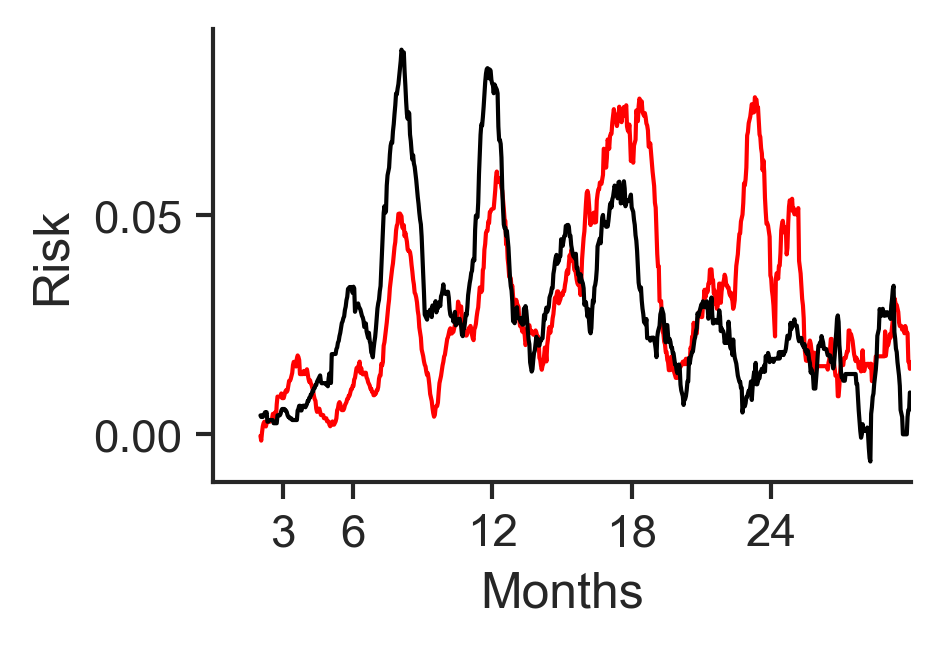

In [146]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev']
y2=plt_df2['prog_risk_std']
ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540,720])
ax.set_xticklabels([3,6,12,18,24])

ax.set_xlim(0,900)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

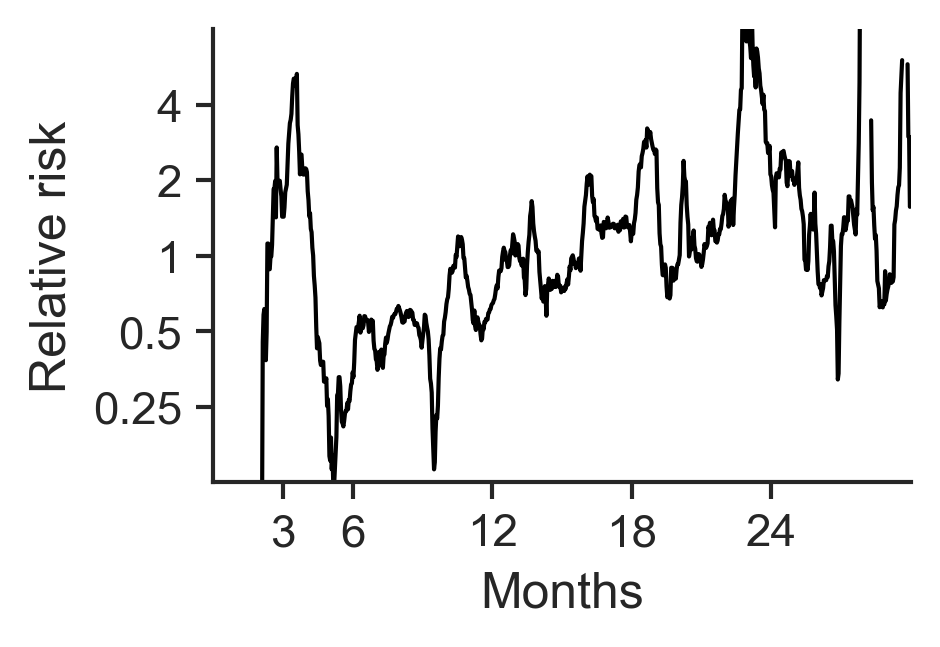

In [147]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio']
ax.plot(x,y,c='black',zorder=2)
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540,720])
ax.set_xticklabels([3,6,12,18,24])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,900)
ax.set_ylim(-3,3)

#ax.axvspan(xmin=30,xmax=12.6*30,color='lightgrey')
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

In [148]:
# Moving avarage
window2=2*30
ratio_aves=[]
ratio_sds=[]
ratio_bevs=[]
ratio_stds=[]

for idx in table.index:
    if idx < window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    elif idx > len(table.index)-window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    else:
        ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
        ratio_sds.append( np.nanstd( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) ) 
        ratio_bevs.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_bev'] ) )
        ratio_stds.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_std'] ) )

In [149]:
table['prog_risk_ratio_moving_average']=ratio_aves
table['prog_risk_bev_moving_average']=ratio_bevs
table['prog_risk_std_moving_average']=ratio_stds

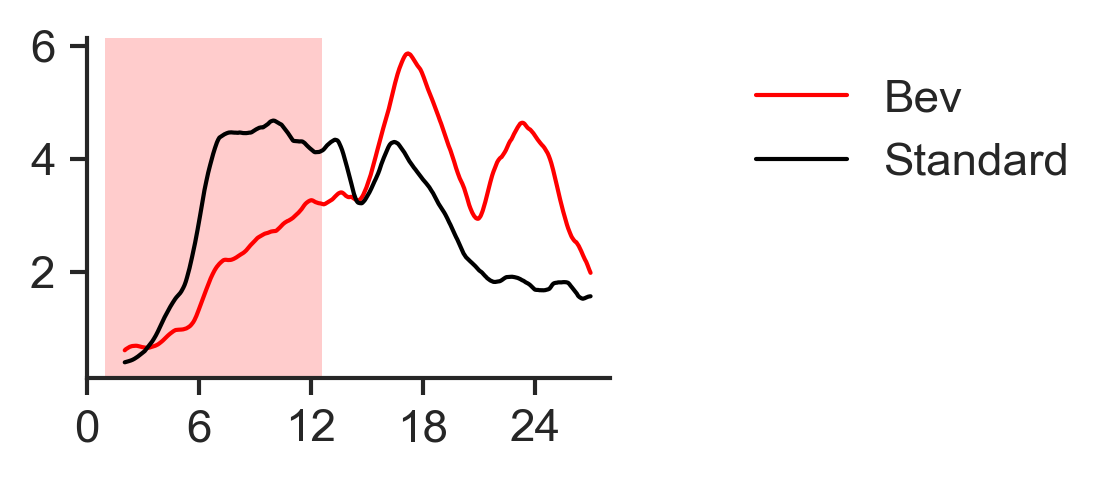

In [150]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.25,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev_moving_average']*100
y2=plt_df2['prog_risk_std_moving_average']*100

ax.plot(x,y1,c='red',zorder=2,label='Bev')
ax.plot(x,y2,c='black',zorder=2,label='Standard')

#ax.set_ylabel('Risk')
#ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])
ax.set_xlim(0,840)

#ax.set_ylim(0,840)
ax.set_yticks([2,4,6])

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0)
ax.legend(bbox_to_anchor=(1.2,1))
plt.savefig('../results/ICON7_lowrisk_pr_moving_average.pdf')

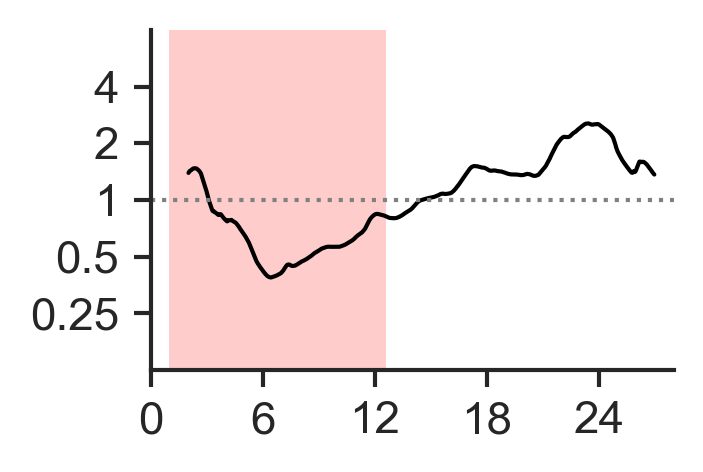

In [151]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.25,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio_moving_average']

ax.plot(plt_df2['day'],y,c='black',zorder=2)
ax.axhline(y=0,c='grey',ls='dotted')
#ax.set_ylabel('Relative risk')
#ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])
ax.set_xlim(0,840)

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_ylim(-3,3)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

ax.axvspan(xmin=30,xmax=12.6*30,color=(1,0,0,0.2),linewidth=0)
plt.savefig('../results/ICON7_lowrisk_rr_moving_average.pdf')

In [152]:
out_prefix='ICON7_lowrisk'

In [153]:
dict_rename={'xs':'X', 'ys_bev':'Y_bev', 'ys_std':'Y_std', 'prog_risk_ratio': 'log2_risk_ratio',
       'prog_risk_ratio_moving_average':'log2_risk_ratio_ma', 'prog_risk_bev_moving_average':'prog_risk_bev_ma',
       'prog_risk_std_moving_average':'prog_risk_std_ma'}

In [154]:
table_w=table.dropna(subset=['prog_risk_bev_moving_average','prog_risk_std_moving_average'])
table_w=table_w.set_index('day')
table_w=table_w.rename(columns=dict_rename)
table_w.to_csv('../results/'+out_prefix+'_table.tsv',sep='\t')

# GOG0218 NEJM

In [155]:
df1=pd.read_csv('../data/GOG218_all_bev_plus.tsv',sep='\t')
df1.head()

X       Y
0  190  2848.0
1  191  2848.5
2  192  2848.0
3  193  2848.5
4  194  2848.0

In [156]:
df2=pd.read_csv('../data/GOG218_all_bev_minus.tsv',sep='\t')
df2.head()

X       Y
0  281  2824.0
1  282  2823.0
2  283  2822.5
3  284  2822.0
4  285  2822.0

In [157]:
df3=pd.read_csv('../data/GOG218_all_axis_label.tsv',sep='\t')
df3.head()

X   Y
0  176  36
1  177  36
2  180  36
3  181  36
4  182  36

Text(0, 0.5, 'Y')

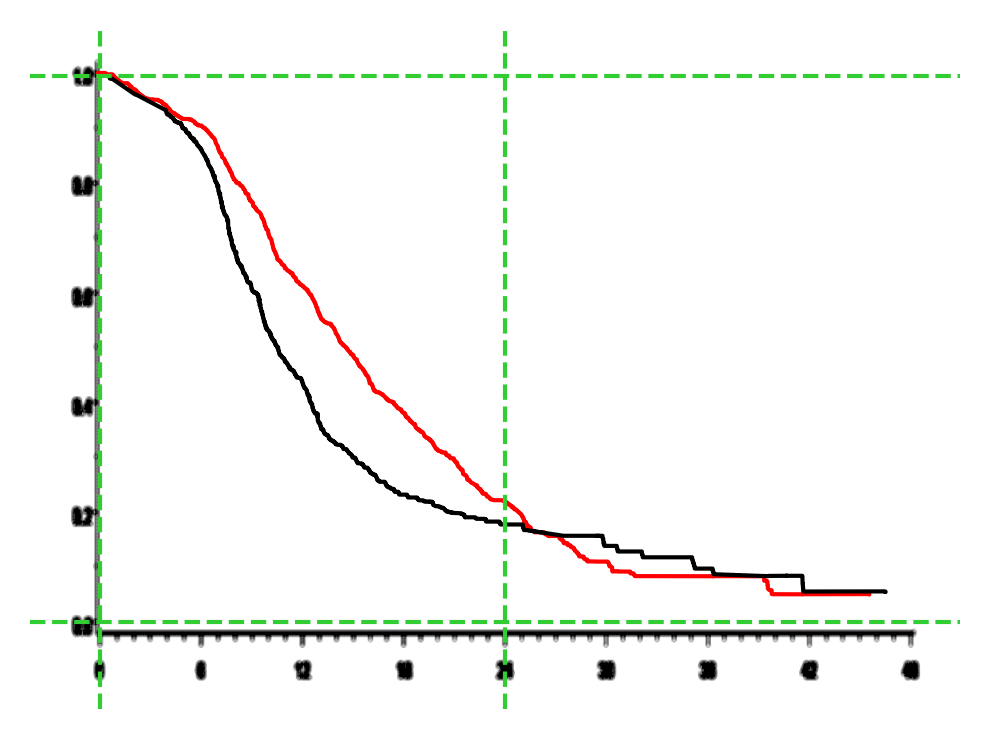

In [158]:
plt_df=df1.copy()
val1='X'
val2='Y'
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(111)

plt_df=df1.copy()
plt_df=plt_df[['X','Y']].dropna()
x,y=plt_df['X'],plt_df['Y']
ax.plot(x,y,c='red')

plt_df=df2.copy()
plt_df=plt_df[['X','Y']].dropna()
x2,y2=plt_df['X'],plt_df['Y']
ax.plot(x2,y2,c='black')


plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=1/100000,c='black',marker='.')

# Check axis 
sr1=2835
sr0=295
ax.axhline(y=sr1,c='limegreen',lw=1,ls='dashed')
ax.axhline(y=sr0,c='limegreen',lw=1,ls='dashed')

m0=205
m24=3245
ax.axvline(x=m0,c='limegreen',lw=1,ls='dashed')
ax.axvline(x=m24,c='limegreen',lw=1,ls='dashed')

ax.set_axis_off()
ax.set_xlabel(val1)
ax.set_ylabel(val2)

In [159]:
m12=m0+(m24-m0)/2
m36=m0+3*(m24-m0)/2

In [160]:
ms=[m0+i*(m12-m0)/12 for i in range(0,36)]
rs1=[df1[df1['X']==getNearestValue(list(df1['X']),m)]['Y'].values[0] for m in ms]
rs2=[df2[df2['X']==getNearestValue(list(df2['X']),m)]['Y'].values[0] for m in ms]

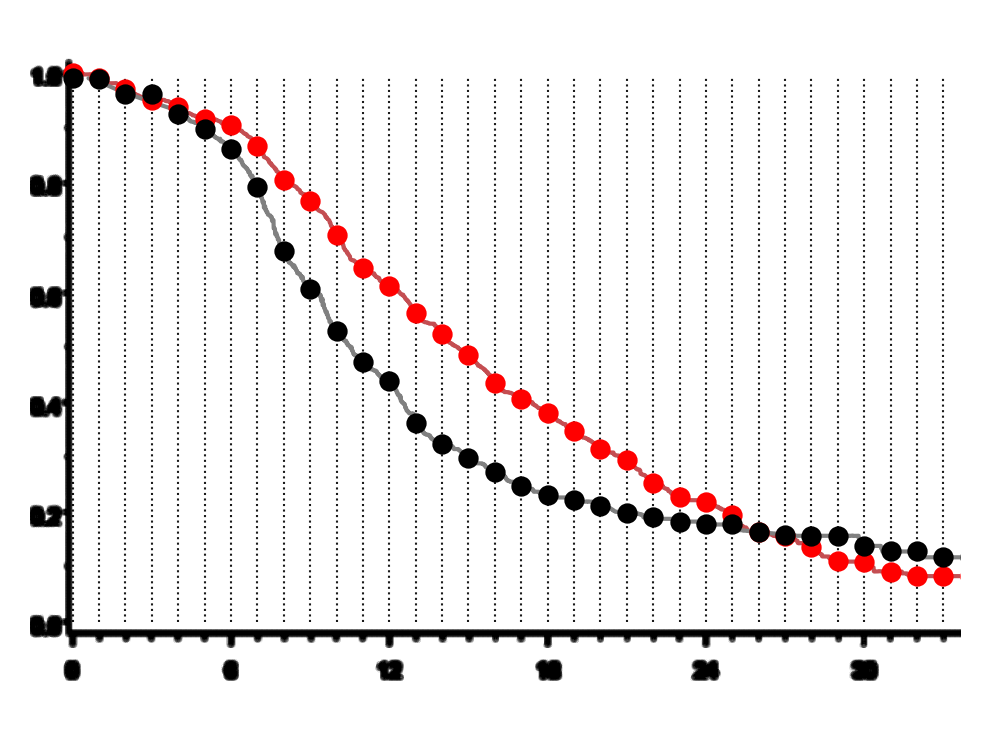

In [161]:
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(111)
ax.plot(x,y,c='r',zorder=0)
ax.plot(x2,y2,c='grey',zorder=0)
ax.scatter(x3,y3,s=0.0001,c='black',marker='.')
ax.scatter(ms,rs1,s=15,c='red',label='Bev')
ax.scatter(ms,rs2,s=15,c='black',label='Standard')

ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(0,m36-300)
ax.set_xlabel(val1)
ax.set_ylabel(val2)

#ax.legend(bbox_to_anchor=(1.1,1) )

ax.set_axis_off()

In [162]:
xs=np.linspace(start=m0,stop=m36,num=1080)
ys_bev,ys_std=[],[]
for x in xs:
    y=df1[df1['X']==getNearestValue(list(df1['X']),x)]['Y'].values[0]
    ys_bev.append(y)
    
    y=df2[df2['X']==getNearestValue(list(df2['X']),x)]['Y'].values[0]
    ys_std.append(y)

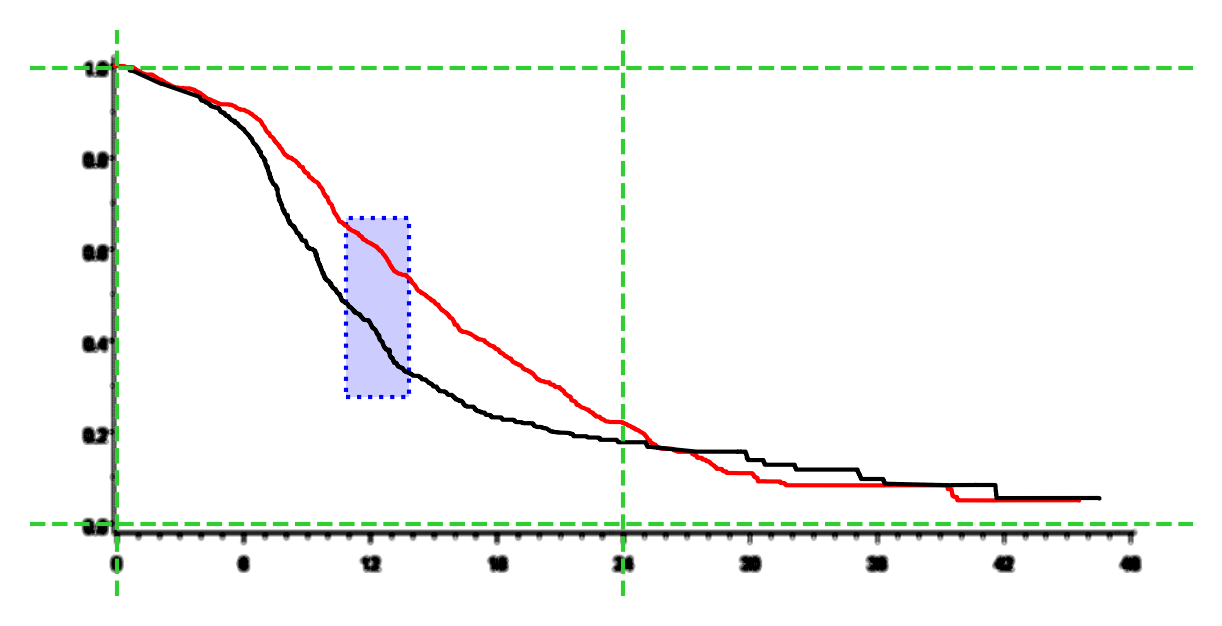

In [163]:
plt_df=df1.copy()
val1='X'
val2='Y'
fig=plt.figure(figsize=(5,2.5))
ax=fig.add_subplot(111)

plt_df=df1.copy()
plt_df=plt_df[['X','Y']].dropna()
x,y=plt_df['X'],plt_df['Y']
ax.plot(x,y,c='red')

plt_df=df2.copy()
plt_df=plt_df[['X','Y']].dropna()
x2,y2=plt_df['X'],plt_df['Y']
ax.plot(x2,y2,c='black')


plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=1/100000,c='black',marker='.')

# Check axis 
sr1=2835
sr0=295
ax.axhline(y=sr1,c='limegreen',lw=1,ls='dashed')
ax.axhline(y=sr0,c='limegreen',lw=1,ls='dashed')

m0=205
m24=3245
ax.axvline(x=m0,c='limegreen',lw=1,ls='dashed')
ax.axvline(x=m24,c='limegreen',lw=1,ls='dashed')

ax.set_axis_off()
ax.set_xlabel(val1)
ax.set_ylabel(val2)

import matplotlib.patches as patches
r=patches.Rectangle(xy=(ms[11]-20,1000),
                    width=ms[14]-ms[11],height=1000,
                    ec='blue',fc=(0,0,1,0.2),ls='dotted')
ax.add_patch(r)

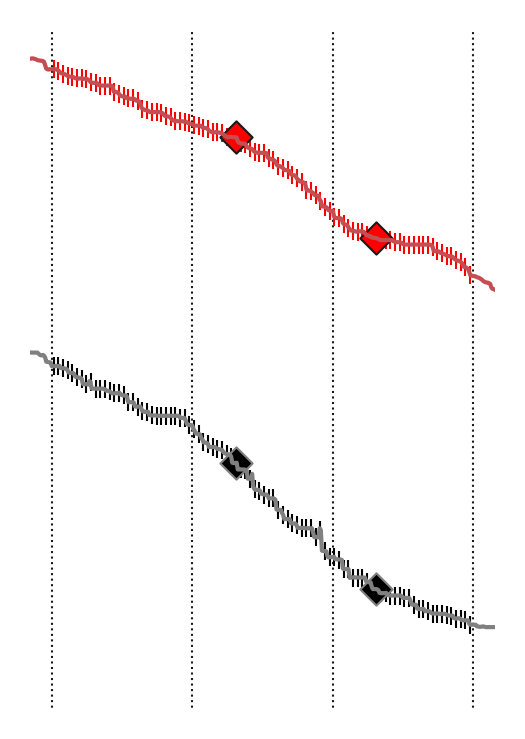

In [164]:
# Zoom
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(2,3))
ax=fig.add_subplot(111)
ax.plot(x,y,c='r')
ax.plot(x2,y2,c='grey')
ax.scatter(x3,y3,s=0.001,c='black')

ax.scatter(xs[12*30+9],ys_bev[12*30+9],s=30,c='red',marker='D',ec='k',linewidth=0.5,zorder=2)
ax.scatter(xs[12*30+9],ys_std[12*30+9],s=30,c='black',marker='D',ec='grey',linewidth=0.5,zorder=2)

ax.scatter(xs[13*30+9],ys_bev[13*30+9],s=30,c='red',marker='D',ec='k',linewidth=0.5,zorder=2)
ax.scatter(xs[13*30+9],ys_std[13*30+9],s=30,c='black',marker='D',ec='grey',linewidth=0.5,zorder=2)

ax.scatter(xs[11*30:14*30],ys_bev[11*30:14*30],s=20,c='red',marker='|',lw=0.5)
ax.scatter(xs[11*30:14*30],ys_std[11*30:14*30],s=20,c='black',marker='|',lw=0.5)


ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(ms[11]-20,ms[14]+20)
ax.set_ylim(1000,2000)

ax.set_axis_off()

In [165]:
table=pd.DataFrame({'xs':xs, "ys_bev":ys_bev,'ys_std':ys_std})
table['day']=table.index
table

xs  ys_bev  ys_std   day
0      205.000000  2848.0  2824.0     0
1      209.226135  2847.5  2824.0     1
2      213.452271  2847.5  2824.0     2
3      217.678406  2847.5  2824.0     3
4      221.904541  2847.5  2824.0     4
...           ...     ...     ...   ...
1075  4748.095459   510.0   545.0  1075
1076  4752.321594   510.0   545.0  1076
1077  4756.547729   510.0   545.0  1077
1078  4760.773865   510.0   545.0  1078
1079  4765.000000   510.0   545.0  1079

[1080 rows x 4 columns]

In [166]:
sr_bevs,sr_stds=[],[]
for idx in table.index:
    sr_bev=1-(sr1-table.loc[idx,'ys_bev'])/(sr1-sr0)
    sr_std=1-(sr1-table.loc[idx,'ys_std'])/(sr1-sr0)
    sr_bevs.append(sr_bev)
    sr_stds.append(sr_std)
    
table['survival_rate_bev']=sr_bevs
table['survival_rate_std']=sr_stds

In [167]:
# survival after 30 days
window=30
def_bevs=[]
def_stds=[]
risk_ratios=[]
for idx in table.index:
    if idx + window >= len(table):
        def_bevs.append(np.nan)
        def_stds.append(np.nan)
        risk_ratios.append(np.nan)
    else:
        def_bev=(table.loc[idx,'survival_rate_bev']-table.loc[idx+window,'survival_rate_bev'])/table.loc[idx,'survival_rate_bev']
        def_bevs.append(def_bev)
        def_std=(table.loc[idx,'survival_rate_std']-table.loc[idx+window,'survival_rate_std'])/table.loc[idx,'survival_rate_std']
        def_stds.append(def_std)
        
        if (def_bev==0)|(def_std==0):
            risk_ratios.append(np.nan)
        else:
            risk_ratios.append( np.log2(def_bev/def_std) )

table['prog_risk_bev']=def_bevs
table['prog_risk_std']=def_stds
table['prog_risk_ratio']=risk_ratios


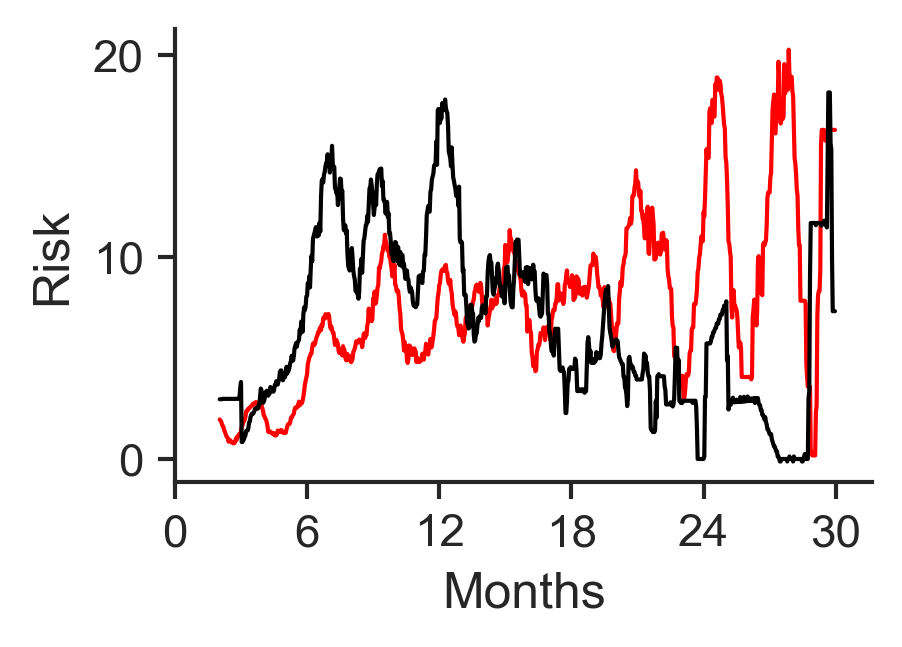

In [168]:
window2=60
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev']*100
y2=plt_df2['prog_risk_std']*100
ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])

ax.set_xlim(0,950)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

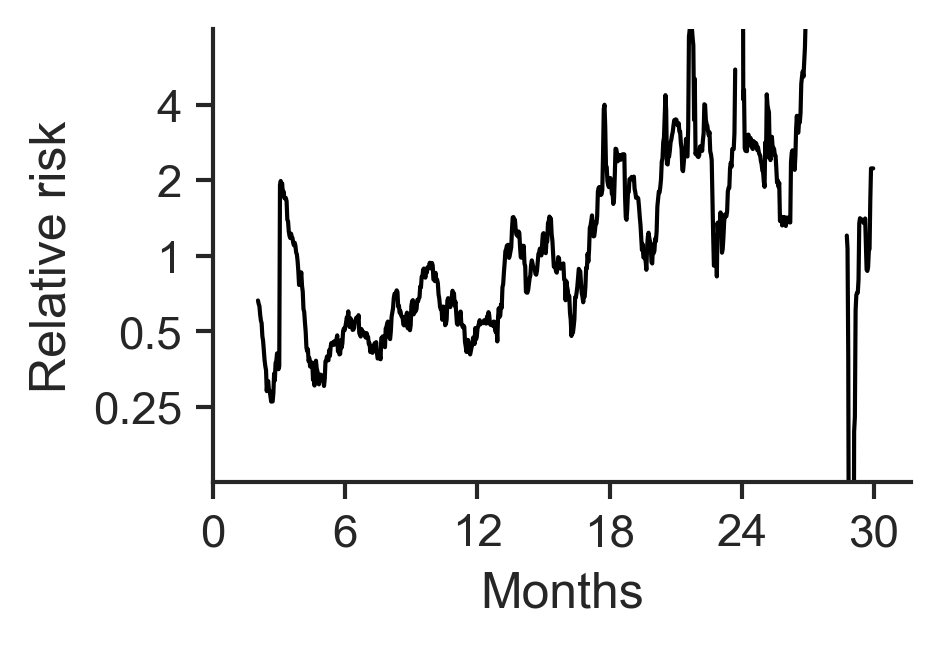

In [169]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio']
ax.plot(x,y,c='black',zorder=2)
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,950)
ax.set_ylim(-3,3)

#ax.axvspan(xmin=30,xmax=12.6*30,color='lightgrey')
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

In [170]:
# Moving avarage
window2=2*30
ratio_aves=[]
ratio_sds=[]
ratio_bevs=[]
ratio_stds=[]

for idx in table.index:
    if idx < window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    elif idx > len(table.index)-window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    else:
        ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
        ratio_sds.append( np.nanstd( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) ) 
        ratio_bevs.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_bev'] ) )
        ratio_stds.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_std'] ) )

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_28788/3803783179.py:20: RuntimeWarning: Mean of empty slice
  ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
/Users/tshiro/.pyenv/versions/miniforge3-4.10/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [171]:
table['prog_risk_ratio_moving_average']=ratio_aves
table['prog_risk_ratio_moving_average_SD']=ratio_sds
table['prog_risk_bev_moving_average']=ratio_bevs
table['prog_risk_std_moving_average']=ratio_stds

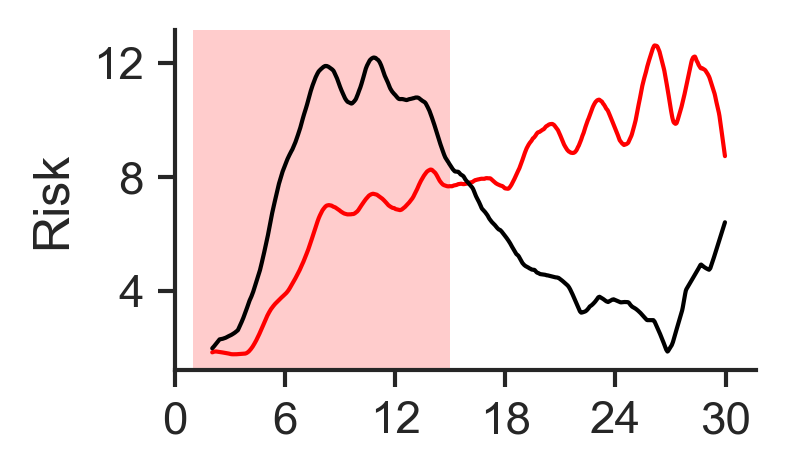

In [172]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.5,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev_moving_average']*100
y2=plt_df2['prog_risk_std_moving_average']*100

ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])
ax.set_yticks([4,8,12])
ax.set_xlim(0,950)

ax.axvspan(xmin=30,xmax=15*30,color=(1,0,0,0.2),linewidth=0,zorder=2)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)
plt.savefig('../results/GOG218_pr_moving_average.pdf')

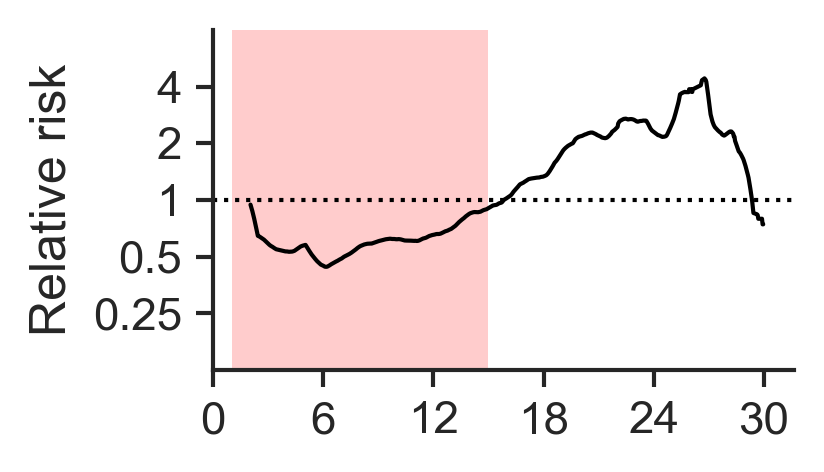

In [173]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.5,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio_moving_average']

ax.plot(plt_df2['day'],y,c='black',zorder=2)
ax.axhline(y=0,c='black',ls='dotted')
ax.set_ylabel('Relative risk')
ax.set_xlabel('')
ax.set_xticks([0,180,360,540,720,900])
ax.set_xticklabels([0,6,12,18,24,30])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,950)
ax.set_ylim(-3,3)

ax.axvspan(xmin=30,xmax=15*30,color=(1,0,0,0.2),linewidth=0,zorder=2)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)
plt.savefig('../results/GOG218_rr_moving_average.pdf')

In [174]:
out_prefix='GOG218'

In [175]:
dict_rename={'xs':'X', 'ys_bev':'Y_bev', 'ys_std':'Y_std', 'prog_risk_ratio': 'log2_risk_ratio',
       'prog_risk_ratio_moving_average':'log2_risk_ratio_ma', 'prog_risk_bev_moving_average':'prog_risk_bev_ma',
       'prog_risk_std_moving_average':'prog_risk_std_ma'}

In [176]:
table_w=table.dropna(subset=['prog_risk_bev_moving_average','prog_risk_std_moving_average'])
table_w=table_w.set_index('day')
table_w=table_w.rename(columns=dict_rename)
table_w.to_csv('../results/'+out_prefix+'_table.tsv',sep='\t')

# GOG218 subgroup

### HRD mutations

In [177]:
df1=pd.read_csv('../data/GOG218_withHRD_bev_plus.tsv',sep='\t')
df1.head()

X       Y
0  357  1630.0
1  358  1630.5
2  359  1630.5
3  360  1630.5
4  361  1631.0

In [178]:
df2=pd.read_csv('../data/GOG218_withHRD_bev_minus.tsv',sep='\t')
df2.head()

X       Y
0  364  1629.5
1  365  1630.0
2  366  1630.0
3  367  1630.0
4  368  1631.0

In [179]:
df3=pd.read_csv('../data/GOG218_withHRD_axis_label.tsv',sep='\t')
df3.head()

X   Y
0  354  29
1  355  29
2  356  29
3  357  29
4  358  29

Text(0, 0.5, 'Y')

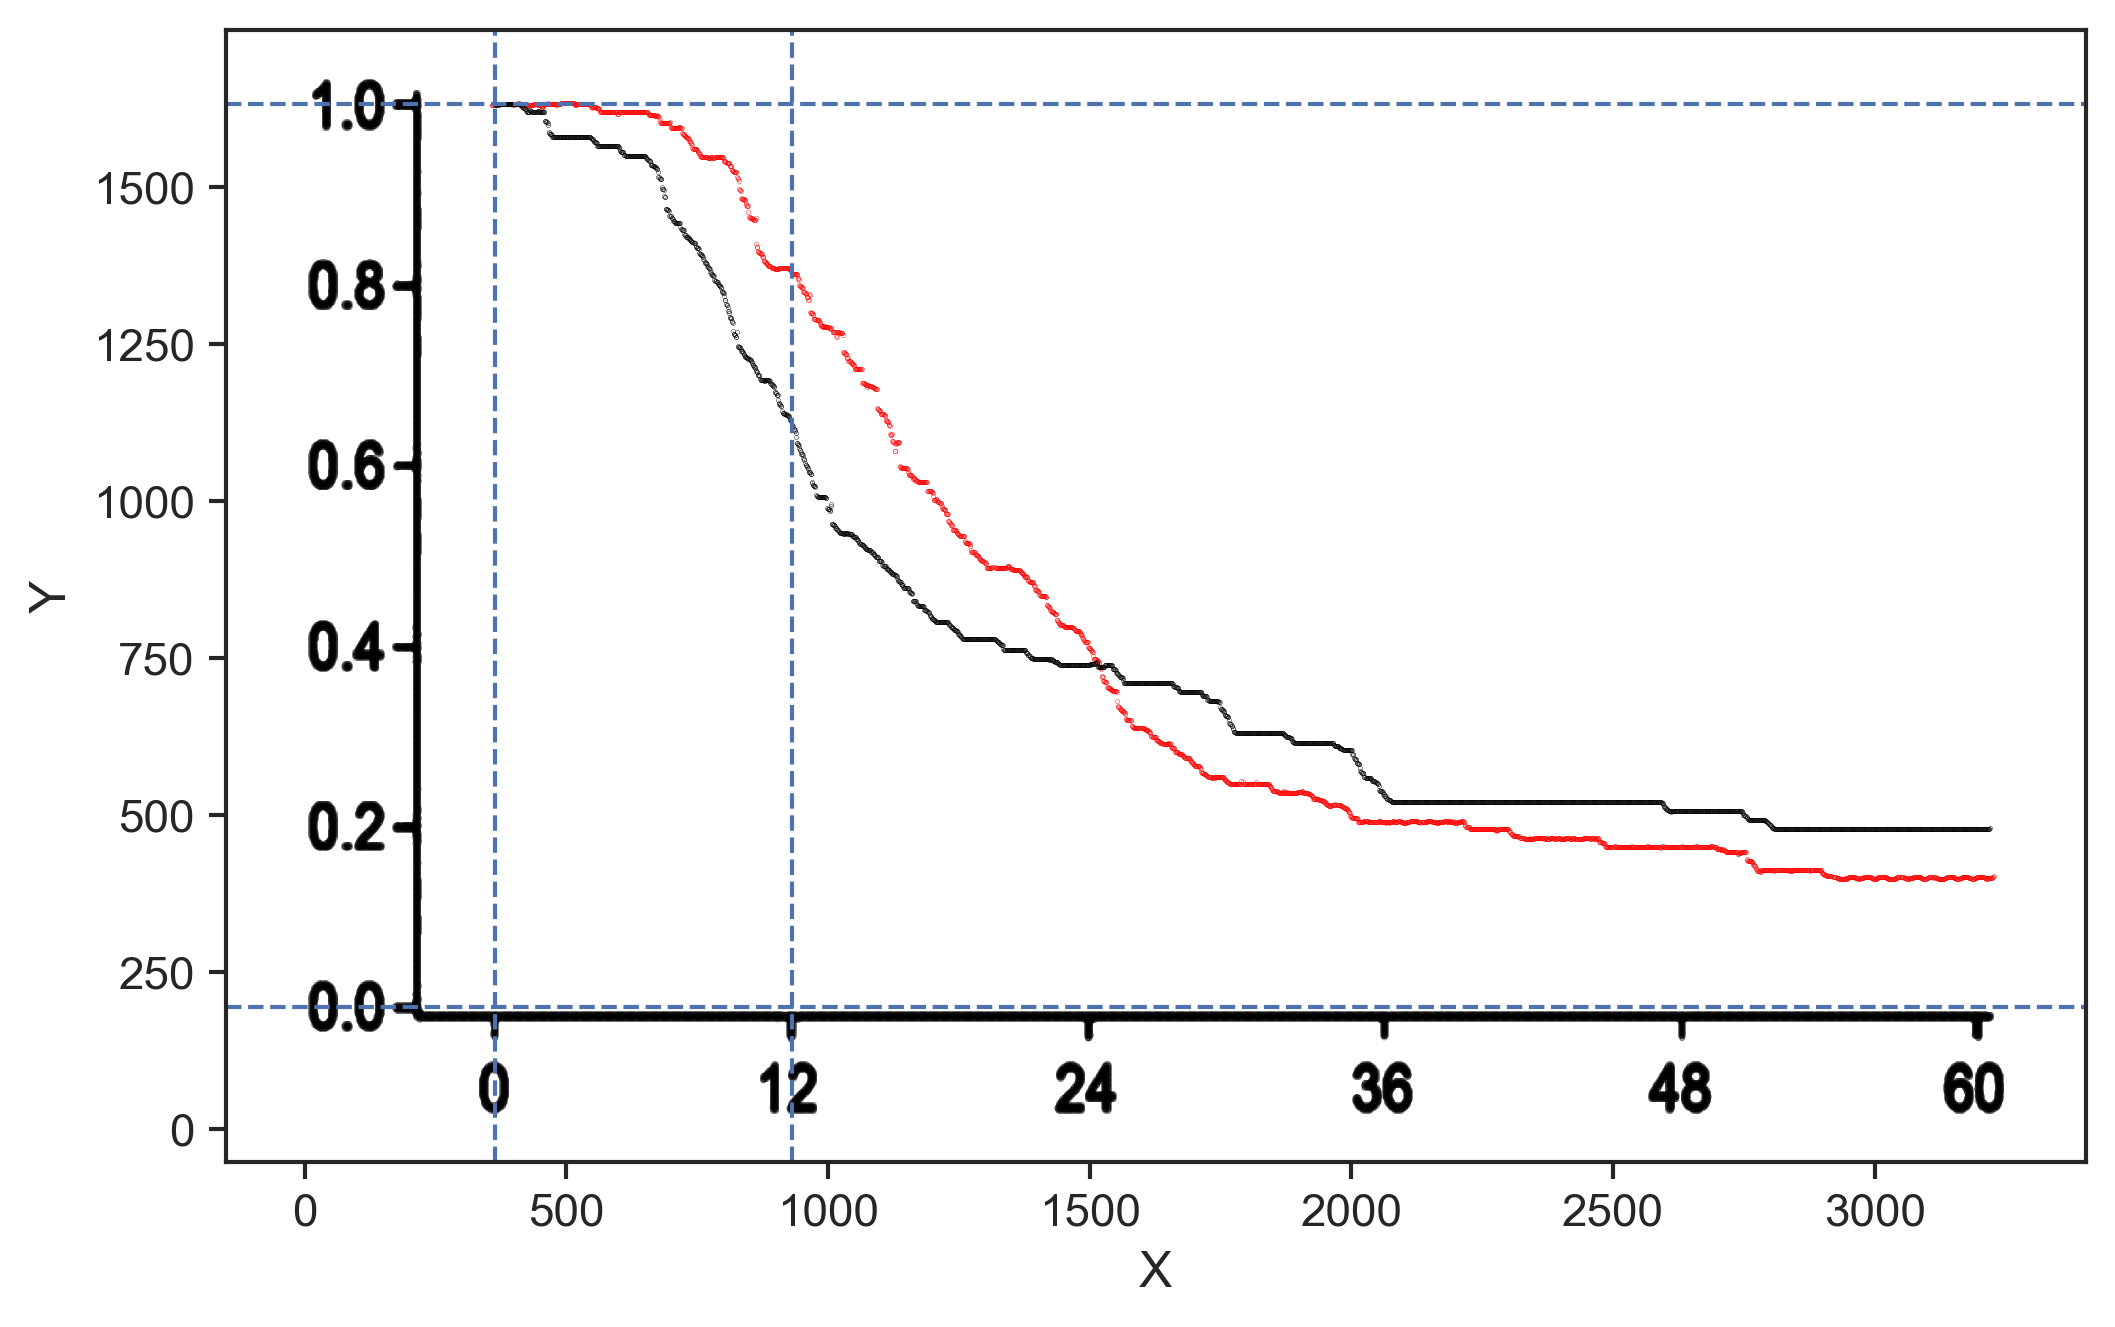

In [180]:
plt_df=df1.copy()
val1='X'
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(111)

plt_df=df1.copy()
plt_df=plt_df[['X','Y']].dropna()
x,y=plt_df['X'],plt_df['Y']
ax.scatter(x,y,s=0.01,c='red')

plt_df=df2.copy()
plt_df=plt_df[['X','Y']].dropna()
x2,y2=plt_df['X'],plt_df['Y']
ax.scatter(x2,y2,s=0.01,c='black')


plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

# Check axis 
sr1=1631
sr0=194
ax.axhline(y=sr1,ls='dashed')
ax.axhline(y=sr0,ls='dashed')

m0=363
m12=931
ax.axvline(x=m0,ls='dashed')
ax.axvline(x=m12,ls='dashed')

ax.set_xlabel(val1)
ax.set_ylabel(val2)

In [181]:
m24=m0+2*(m12-m0)
m36=m0+3*(m12-m0)

In [182]:
ms=[m0+i*(m12-m0)/12 for i in range(0,37)]
rs1=[df1[df1['X']==getNearestValue(list(df1['X']),m)]['Y'].values[0] for m in ms]
rs2=[df2[df2['X']==getNearestValue(list(df2['X']),m)]['Y'].values[0] for m in ms]

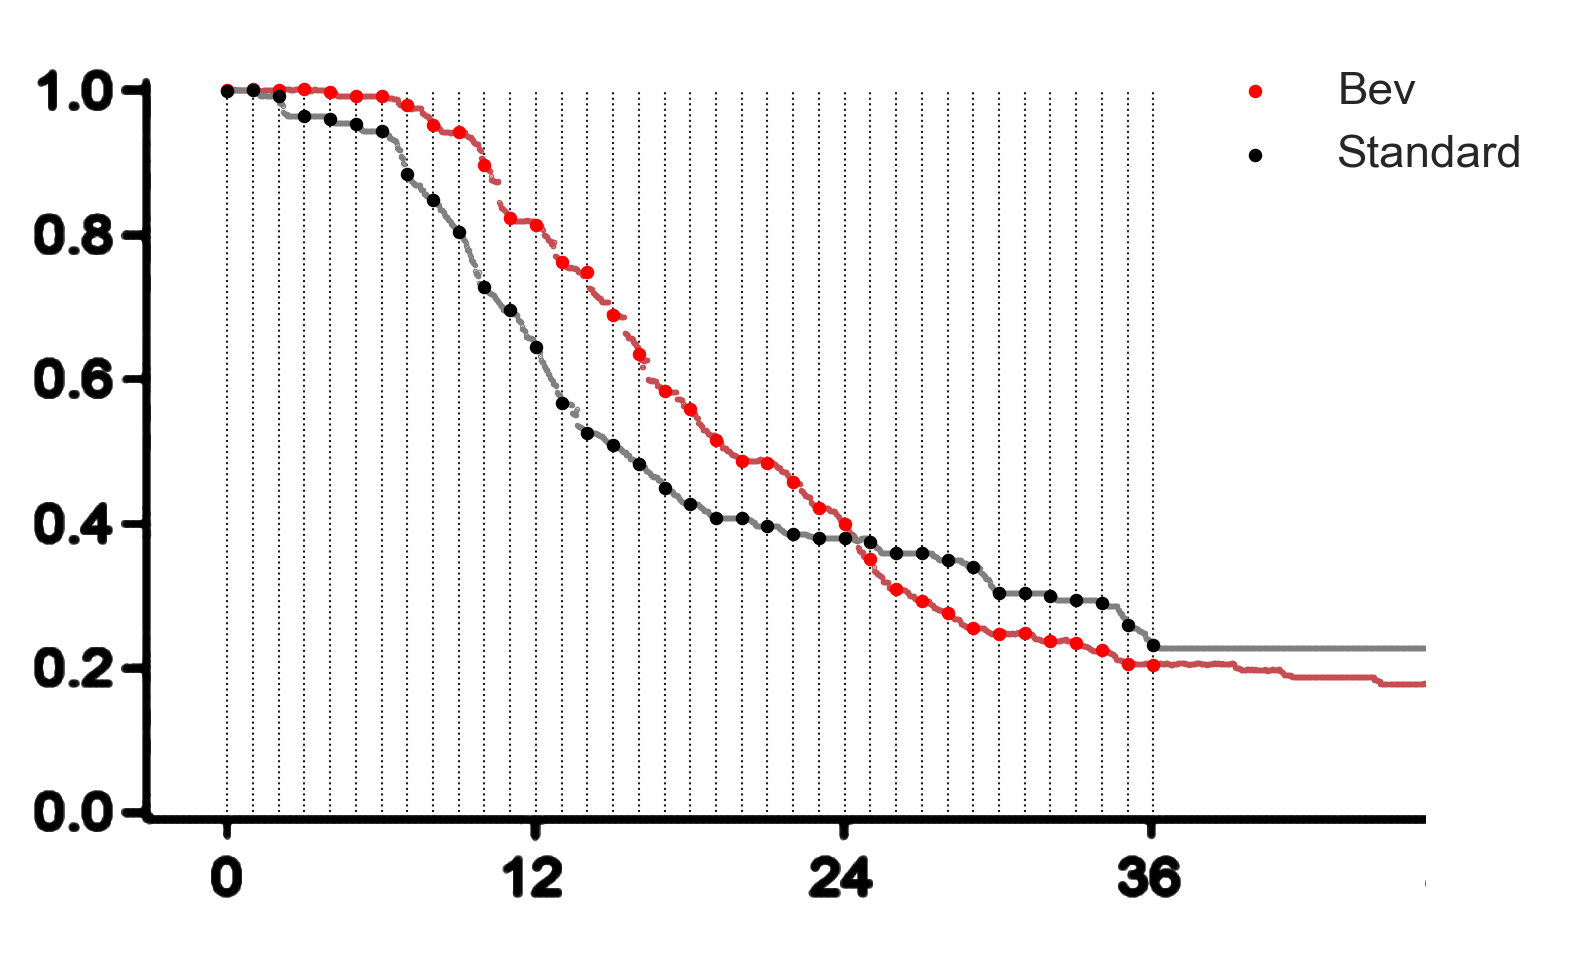

In [183]:
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=0.1,c='r')
ax.scatter(x2,y2,s=0.1,c='grey')
ax.scatter(x3,y3,s=0.001,c='black')
ax.scatter(ms,rs1,s=5,c='red',label='Bev')
ax.scatter(ms,rs2,s=5,c='black',label='Standard')

ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(0,m36+500)
ax.set_xlabel(val1)
ax.set_ylabel(val2)

ax.legend(bbox_to_anchor=(1.1,1) )

ax.set_axis_off()

In [184]:
xs=np.linspace(start=m0,stop=m36,num=1080)

In [185]:
ys_bev,ys_std=[],[]
for x in xs:
    y=df1[df1['X']==getNearestValue(list(df1['X']),x)]['Y'].values[0]
    ys_bev.append(y)
    
    y=df2[df2['X']==getNearestValue(list(df2['X']),x)]['Y'].values[0]
    ys_std.append(y)

In [186]:
table=pd.DataFrame({'xs':xs, "ys_bev":ys_bev,'ys_std':ys_std})
table['day']=table.index
table

xs  ys_bev  ys_std   day
0      363.00000  1631.5  1629.5     0
1      364.57924  1631.5  1630.0     1
2      366.15848  1631.5  1630.0     2
3      367.73772  1631.5  1631.0     3
4      369.31696  1631.5  1631.0     4
...          ...     ...     ...   ...
1075  2060.68304   488.5   533.5  1075
1076  2062.26228   488.5   532.5  1076
1077  2063.84152   488.5   530.5  1077
1078  2065.42076   488.5   530.5  1078
1079  2067.00000   487.0   526.0  1079

[1080 rows x 4 columns]

In [187]:
sr_bevs,sr_stds=[],[]
for idx in table.index:
    sr_bev=1-(sr1-table.loc[idx,'ys_bev'])/(sr1-sr0)
    sr_std=1-(sr1-table.loc[idx,'ys_std'])/(sr1-sr0)
    sr_bevs.append(sr_bev)
    sr_stds.append(sr_std)
    
table['survival_rate_bev']=sr_bevs
table['survival_rate_std']=sr_stds

In [188]:
# survival after 30 days
window=30
def_bevs=[]
def_stds=[]
risk_ratios=[]
for idx in table.index:
    if idx + window >= len(table):
        def_bevs.append(np.nan)
        def_stds.append(np.nan)
        risk_ratios.append(np.nan)
    else:
        def_bev=(table.loc[idx,'survival_rate_bev']-table.loc[idx+window,'survival_rate_bev'])/table.loc[idx,'survival_rate_bev']
        def_bevs.append(def_bev)
        def_std=(table.loc[idx,'survival_rate_std']-table.loc[idx+window,'survival_rate_std'])/table.loc[idx,'survival_rate_std']
        def_stds.append(def_std)
        
        if (def_bev==0)|(def_std==0):
            risk_ratios.append(np.nan)
        else:
            risk_ratios.append( np.log2(def_bev/def_std) )

table['prog_risk_bev']=def_bevs
table['prog_risk_std']=def_stds
table['prog_risk_ratio']=risk_ratios

In [189]:
# Moving avarage
window2=2*30
ratio_aves=[]
ratio_bevs=[]
ratio_stds=[]

for idx in table.index:
    if idx < window2:
        ratio_aves.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    elif idx > len(table.index)-window2:
        ratio_aves.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    else:
        ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
        ratio_bevs.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_bev'] ) )
        ratio_stds.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_std'] ) )

In [190]:
table['prog_risk_ratio_moving_average']=ratio_aves
table['prog_risk_bev_moving_average']=ratio_bevs
table['prog_risk_std_moving_average']=ratio_stds

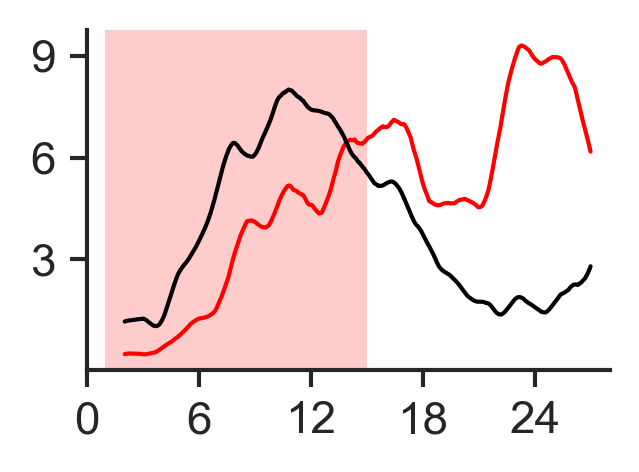

In [191]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.25,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev_moving_average']*100
y2=plt_df2['prog_risk_std_moving_average']*100

ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

#ax.set_ylabel('Risk')
#ax.set_xlabel('')
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])
ax.set_xlim(0,840)

ax.set_yticks([3,6,9])

ax.axvspan(xmin=30,xmax=15*30,color=(1,0,0,0.2),linewidth=0,zorder=2)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)
plt.savefig('../results/GOG218_withHRD_pr_moving_average.pdf')

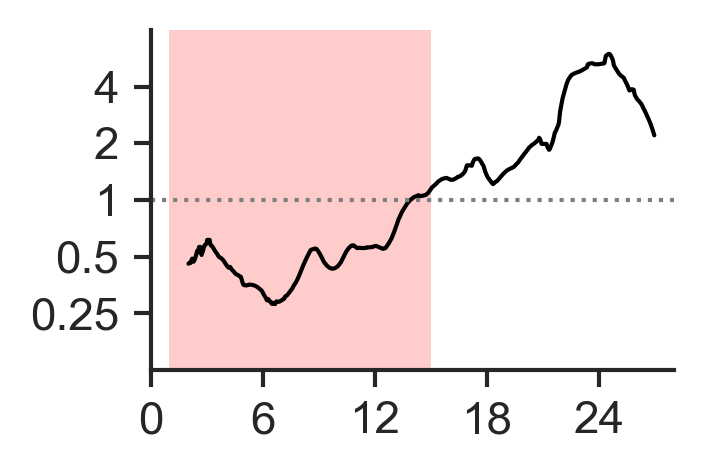

In [192]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.25,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio_moving_average']

ax.plot(plt_df2['day'],y,c='black',zorder=2)
ax.axhline(y=0,c='grey',ls='dotted')
#ax.set_ylabel('Relative risk')
#ax.set_xlabel('')
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,840)
ax.set_ylim(-3,3)

ax.axvspan(xmin=30,xmax=15*30,color=(1,0,0,0.2),linewidth=0,zorder=2)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)
plt.savefig('../results/GOG218_withHRD_rr_moving_average.pdf')

In [193]:
out_prefix='GOG218_withHRD'

In [194]:
dict_rename={'xs':'X', 'ys_bev':'Y_bev', 'ys_std':'Y_std', 'prog_risk_ratio': 'log2_risk_ratio',
       'prog_risk_ratio_moving_average':'log2_risk_ratio_ma', 'prog_risk_bev_moving_average':'prog_risk_bev_ma',
       'prog_risk_std_moving_average':'prog_risk_std_ma'}

In [195]:
table_w=table.dropna(subset=['prog_risk_bev_moving_average','prog_risk_std_moving_average'])
table_w=table_w.set_index('day')
table_w=table_w.rename(columns=dict_rename)
table_w.to_csv('../results/'+out_prefix+'_table.tsv',sep='\t')

### nonHRD mutations

In [196]:
df1=pd.read_csv('../data/GOG218_withoutHRD_bev_plus.tsv',sep='\t')
df1.head()

X       Y
0  358  1651.5
1  359  1652.5
2  360  1652.5
3  361  1652.0
4  362  1651.5

In [197]:
df2=pd.read_csv('../data/GOG218_withoutHRD_bev_minus.tsv',sep='\t')
df2.head()

X       Y
0  363  1651.5
1  364  1651.5
2  365  1651.5
3  366  1651.5
4  367  1651.5

In [198]:
df3=pd.read_csv('../data/GOG218_withoutHRD_axis_label.tsv',sep='\t')
df3.head()

X   Y
0  348  24
1  349  24
2  350  24
3  351  24
4  352  24

Text(0, 0.5, 'Y')

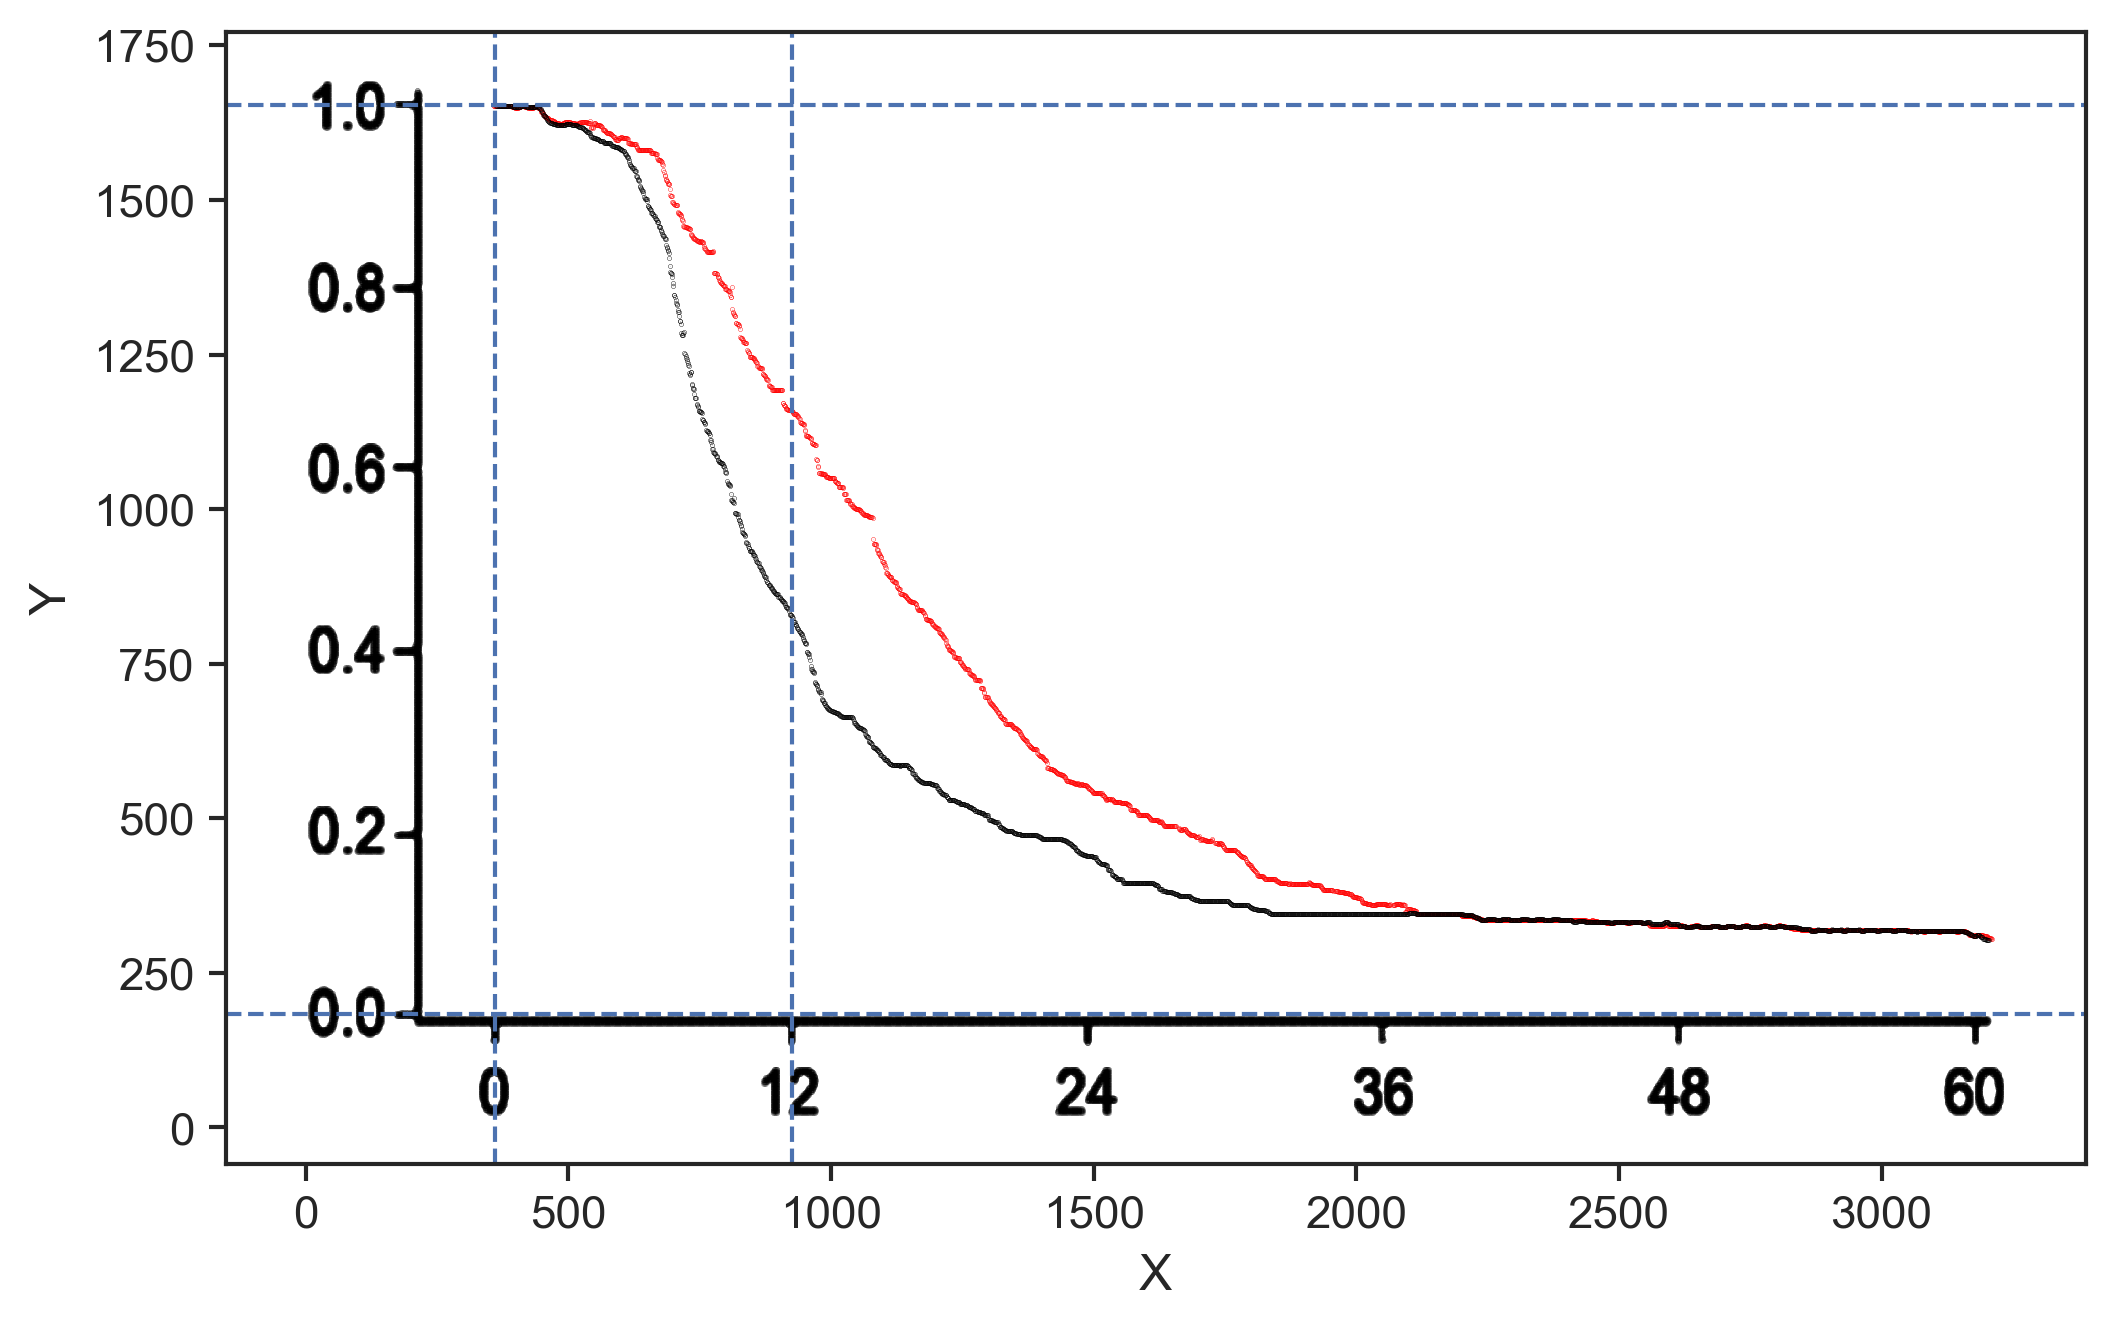

In [199]:
plt_df=df1.copy()
val1='X'
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(111)

plt_df=df1.copy()
plt_df=plt_df[['X','Y']].dropna()
x,y=plt_df['X'],plt_df['Y']
ax.scatter(x,y,s=0.01,c='red')

plt_df=df2.copy()
plt_df=plt_df[['X','Y']].dropna()
x2,y2=plt_df['X'],plt_df['Y']
ax.scatter(x2,y2,s=0.01,c='black')


plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

# Check axis 
sr1=1654
sr0=183
ax.axhline(y=sr1,ls='dashed')
ax.axhline(y=sr0,ls='dashed')

m0=360
m12=925
ax.axvline(x=m0,ls='dashed')
ax.axvline(x=m12,ls='dashed')

ax.set_xlabel(val1)
ax.set_ylabel(val2)

In [200]:
m24=m0+2*(m12-m0)
m36=m0+3*(m12-m0)

In [201]:
ms=[m0+i*(m12-m0)/12 for i in range(0,36)]
rs1=[df1[df1['X']==getNearestValue(list(df1['X']),m)]['Y'].values[0] for m in ms]
rs2=[df2[df2['X']==getNearestValue(list(df2['X']),m)]['Y'].values[0] for m in ms]

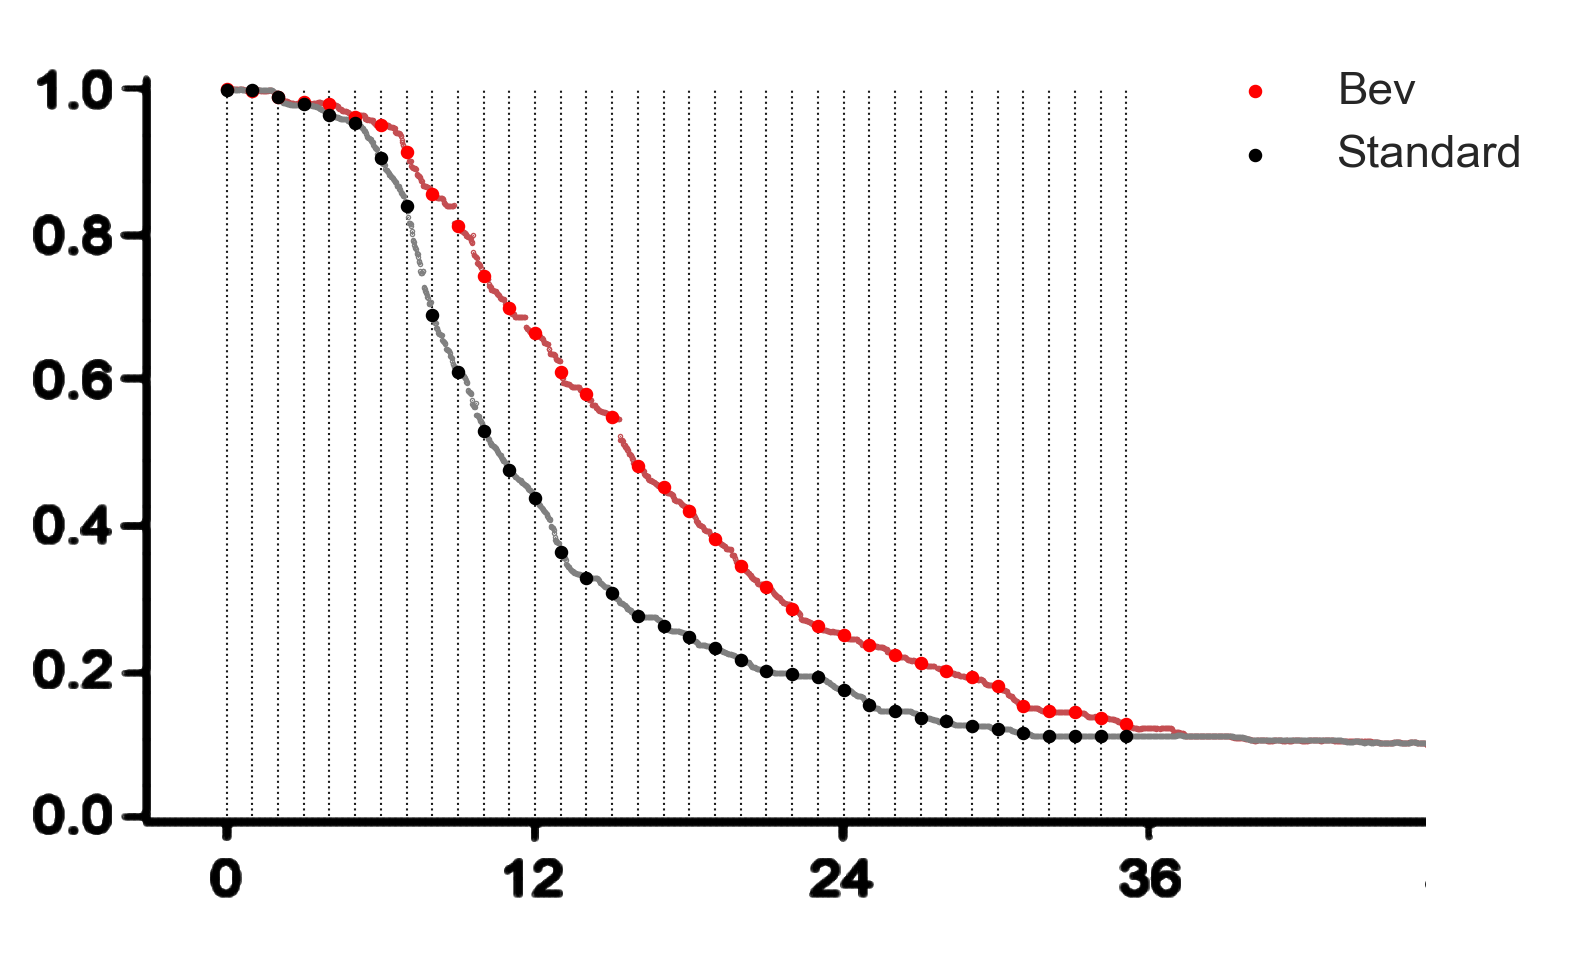

In [202]:
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=0.1,c='r')
ax.scatter(x2,y2,s=0.1,c='grey')
ax.scatter(x3,y3,s=0.001,c='black')
ax.scatter(ms,rs1,s=5,c='red',label='Bev')
ax.scatter(ms,rs2,s=5,c='black',label='Standard')

ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(0,m36+500)
ax.set_xlabel(val1)
ax.set_ylabel(val2)

ax.legend(bbox_to_anchor=(1.1,1) )

ax.set_axis_off()

In [203]:
xs=np.linspace(start=m0,stop=m36,num=1080)

In [204]:
ys_bev,ys_std=[],[]
for x in xs:
    y=df1[df1['X']==getNearestValue(list(df1['X']),x)]['Y'].values[0]
    ys_bev.append(y)
    
    y=df2[df2['X']==getNearestValue(list(df2['X']),x)]['Y'].values[0]
    ys_std.append(y)

In [205]:
table=pd.DataFrame({'xs':xs, "ys_bev":ys_bev,'ys_std':ys_std})
table['day']=table.index
table

xs  ys_bev  ys_std   day
0      360.000000  1652.5  1651.5     0
1      361.570899  1651.5  1651.5     1
2      363.141798  1652.0  1651.5     2
3      364.712697  1652.0  1651.5     3
4      366.283596  1652.0  1651.5     4
...           ...     ...     ...   ...
1075  2048.716404   361.0   344.5  1075
1076  2050.287303   361.0   345.0  1076
1077  2051.858202   361.0   344.5  1077
1078  2053.429101   361.0   344.5  1078
1079  2055.000000   361.0   345.0  1079

[1080 rows x 4 columns]

In [206]:
sr_bevs,sr_stds=[],[]
for idx in table.index:
    sr_bev=1-(sr1-table.loc[idx,'ys_bev'])/(sr1-sr0)
    sr_std=1-(sr1-table.loc[idx,'ys_std'])/(sr1-sr0)
    sr_bevs.append(sr_bev)
    sr_stds.append(sr_std)
    
table['survival_rate_bev']=sr_bevs
table['survival_rate_std']=sr_stds

In [207]:
# survival after 30 days
window=30
def_bevs=[]
def_stds=[]
risk_ratios=[]
for idx in table.index:
    if idx + window >= len(table):
        def_bevs.append(np.nan)
        def_stds.append(np.nan)
        risk_ratios.append(np.nan)
    else:
        def_bev=(table.loc[idx,'survival_rate_bev']-table.loc[idx+window,'survival_rate_bev'])/table.loc[idx,'survival_rate_bev']
        def_bevs.append(def_bev)
        def_std=(table.loc[idx,'survival_rate_std']-table.loc[idx+window,'survival_rate_std'])/table.loc[idx,'survival_rate_std']
        def_stds.append(def_std)
        
        if (def_bev==0)|(def_std==0):
            risk_ratios.append(np.nan)
        else:
            risk_ratios.append( np.log2(def_bev/def_std) )

table['prog_risk_bev']=def_bevs
table['prog_risk_std']=def_stds
table['prog_risk_ratio']=risk_ratios

In [208]:
# Moving avarage
window2=2*30
ratio_aves=[]
ratio_bevs=[]
ratio_stds=[]

for idx in table.index:
    if idx < window2:
        ratio_aves.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    elif idx > len(table.index)-window2:
        ratio_aves.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    else:
        ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
        ratio_bevs.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_bev'] ) )
        ratio_stds.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_std'] ) )
        
table['prog_risk_ratio_moving_average']=ratio_aves
table['prog_risk_bev_moving_average']=ratio_bevs
table['prog_risk_std_moving_average']=ratio_stds

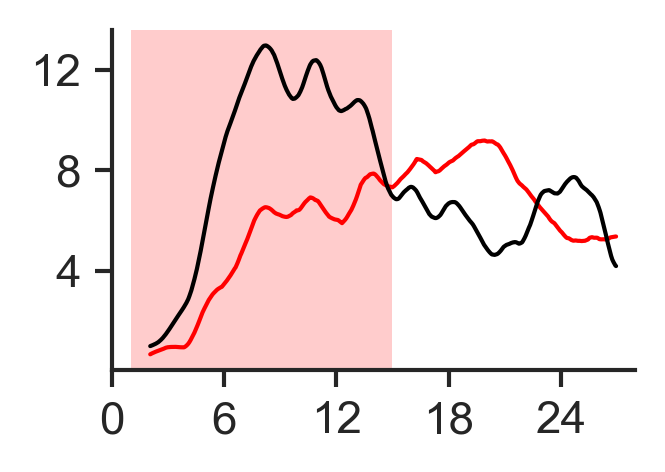

In [209]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.25,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev_moving_average']*100
y2=plt_df2['prog_risk_std_moving_average']*100

ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

#ax.set_ylabel('Risk')
#ax.set_xlabel('')
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])
ax.set_xlim(0,840)
ax.set_yticks([4,8,12])

ax.axvspan(xmin=30,xmax=15*30,color=(1,0,0,0.2),linewidth=0,zorder=2)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)
plt.savefig('../results/GOG218_withoutHRD_pr_moving_average.pdf')

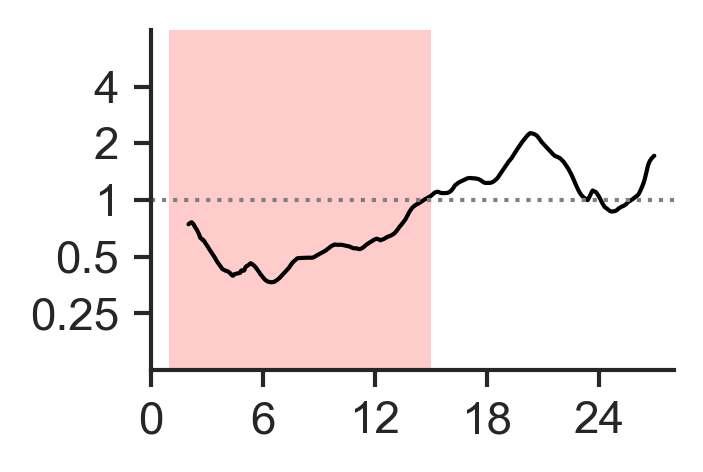

In [210]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.25,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio_moving_average']

ax.plot(plt_df2['day'],y,c='black',zorder=2)
ax.axhline(y=0,c='grey',ls='dotted')
#ax.set_ylabel('Relative risk')
#ax.set_xlabel('')
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,840)
ax.set_ylim(-3,3)

ax.axvspan(xmin=30,xmax=15*30,color=(1,0,0,0.2),linewidth=0,zorder=2)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)
plt.savefig('../results/GOG218_withoutHRD_rr_moving_average.pdf')

In [211]:
out_prefix='GOG218_withoutHRD'

In [212]:
dict_rename={'xs':'X', 'ys_bev':'Y_bev', 'ys_std':'Y_std', 'prog_risk_ratio': 'log2_risk_ratio',
       'prog_risk_ratio_moving_average':'log2_risk_ratio_ma', 'prog_risk_bev_moving_average':'prog_risk_bev_ma',
       'prog_risk_std_moving_average':'prog_risk_std_ma'}

In [213]:
table_w=table.dropna(subset=['prog_risk_bev_moving_average','prog_risk_std_moving_average'])
table_w=table_w.set_index('day')
table_w=table_w.rename(columns=dict_rename)
table_w.to_csv('../results/'+out_prefix+'_table.tsv',sep='\t')

### KELIM high

In [214]:
df1=pd.read_csv('../data/GOG218_KELIMhigh_bev_plus.tsv',sep='\t')
df1.head()

X            Y
0  328  2409.285714
1  329  2398.861111
2  330  2408.731707
3  331  2414.166667
4  332  2409.404762

In [215]:
df2=pd.read_csv('../data/GOG218_KELIMhigh_bev_minus.tsv',sep='\t')
df2.head()

X       Y
0  328  2410.0
1  329  2410.0
2  330  2410.0
3  331  2409.5
4  332  2409.0

In [216]:
df3=pd.read_csv('../data/GOG218_KELIMhigh_axis_label.tsv',sep='\t')
df3.head()

X   Y
0  317  64
1  318  64
2  319  64
3  320  64
4  321  64

Text(0, 0.5, 'Y')

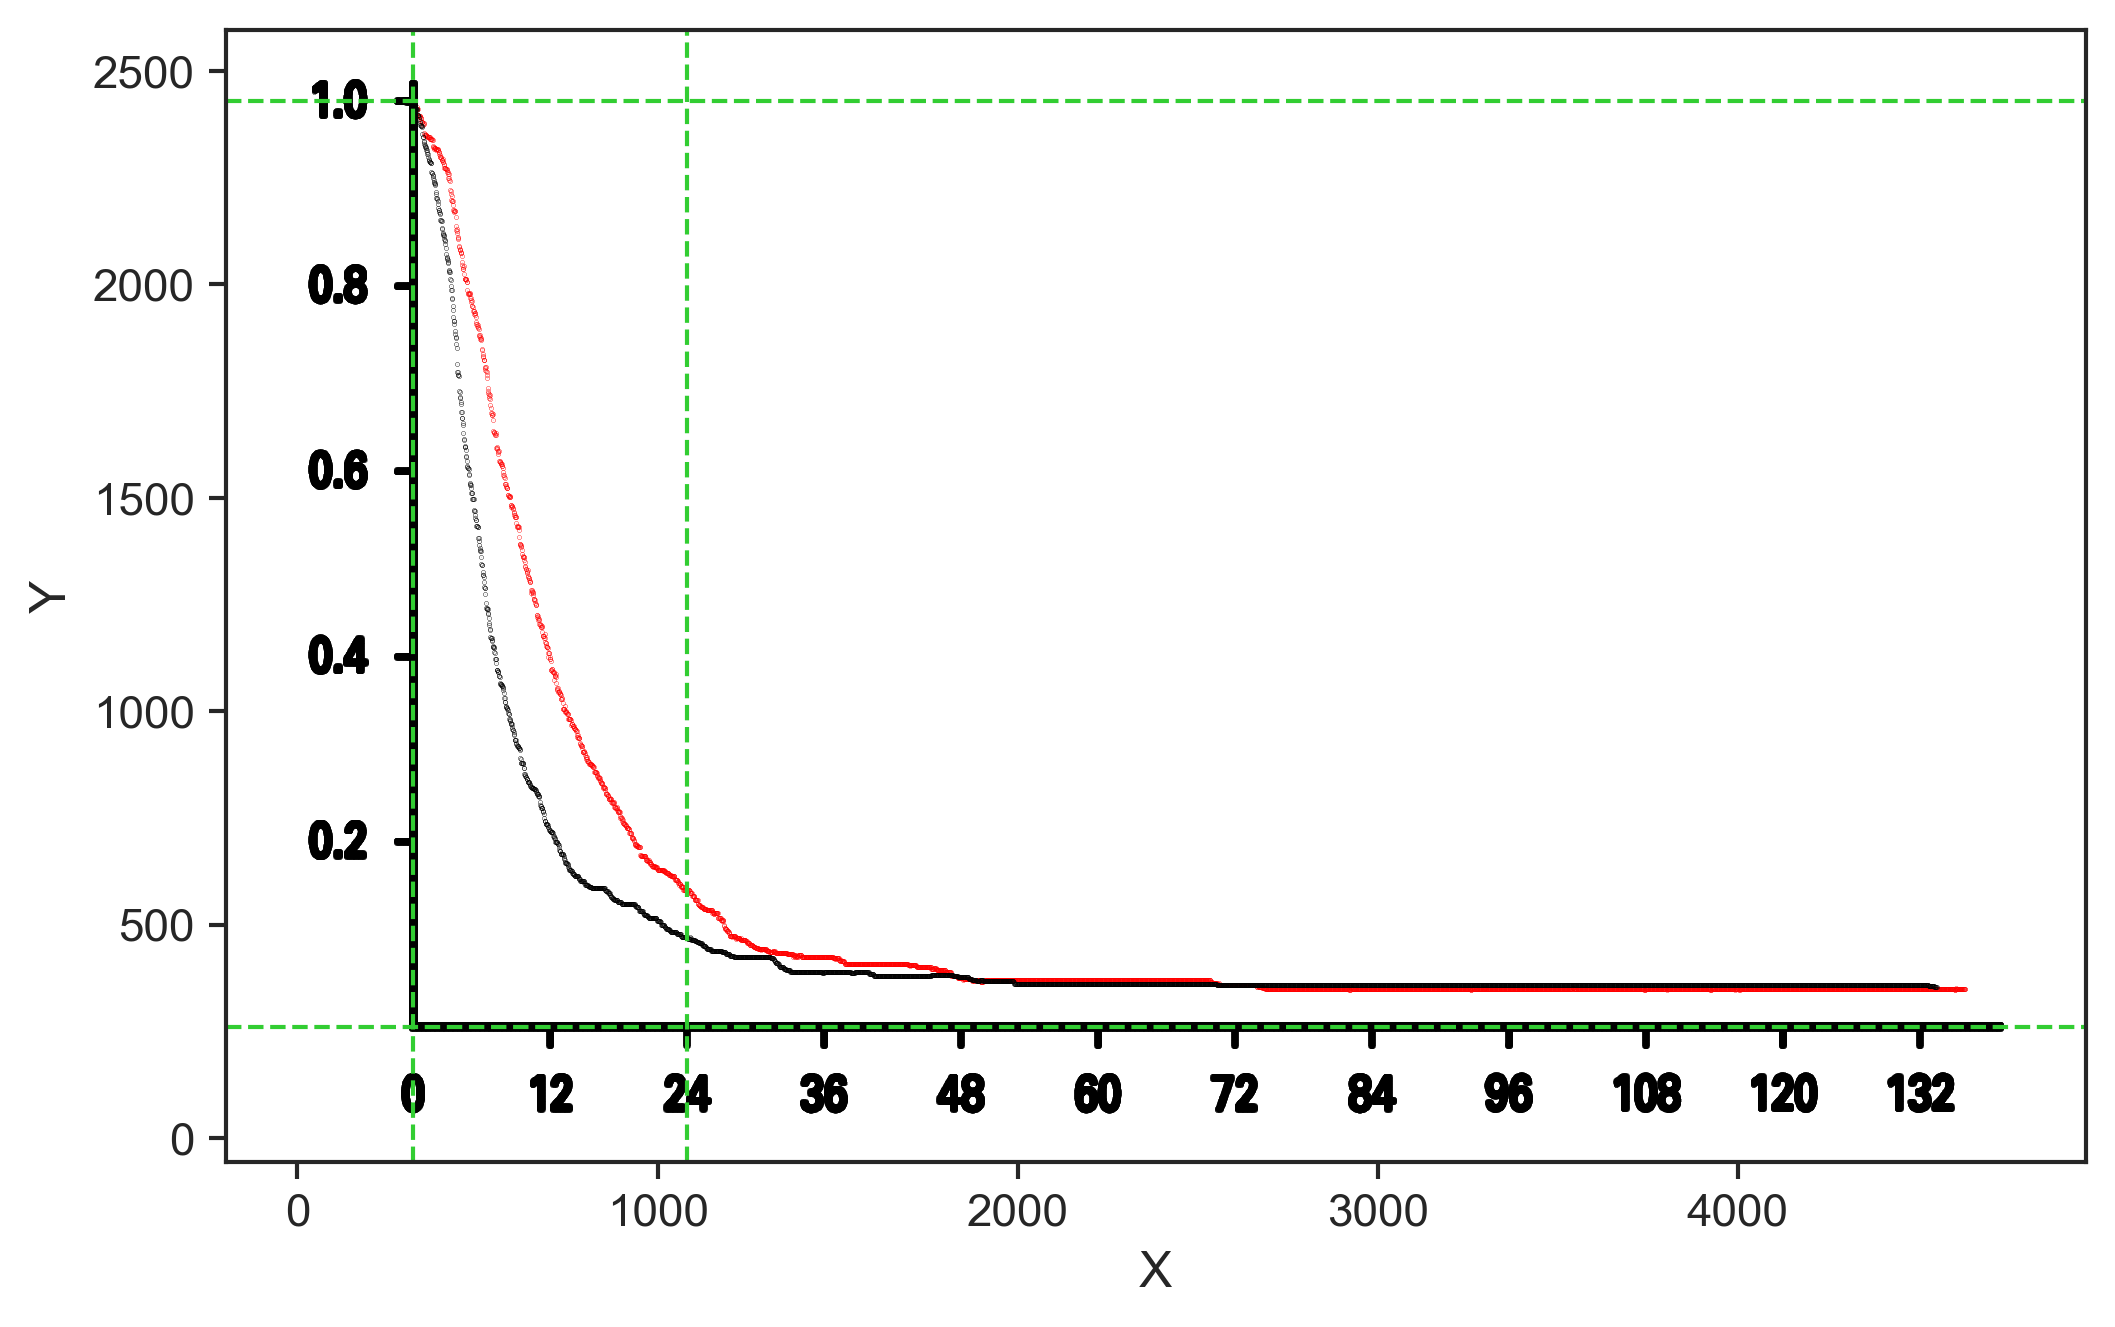

In [217]:
plt_df=df1.copy()
val1='X'
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(111)

plt_df=df1.copy()
plt_df=plt_df[['X','Y']].dropna()
x,y=plt_df['X'],plt_df['Y']
ax.scatter(x,y,s=0.01,c='red')

plt_df=df2.copy()
plt_df=plt_df[['X','Y']].dropna()
x2,y2=plt_df['X'],plt_df['Y']
ax.scatter(x2,y2,s=0.01,c='black')
plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

# Check axis 
sr1=2430
sr0=260
ax.axhline(y=sr1,c='limegreen',lw=1,ls='dashed')
ax.axhline(y=sr0,c='limegreen',lw=1,ls='dashed')

m0=320
m24=1083
ax.axvline(x=m0,c='limegreen',lw=1,ls='dashed')
ax.axvline(x=m24,c='limegreen',lw=1,ls='dashed')

plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

ax.set_xlabel(val1)
ax.set_ylabel(val2)

In [218]:
m12=m0+0.5*(m24-m0)
m36=m0+3*(m12-m0)

In [219]:
ms=[m0+i*(m12-m0)/12 for i in range(0,37)]
rs1=[df1[df1['X']==getNearestValue(list(df1['X']),m)]['Y'].values[0] for m in ms]
rs2=[df2[df2['X']==getNearestValue(list(df2['X']),m)]['Y'].values[0] for m in ms]

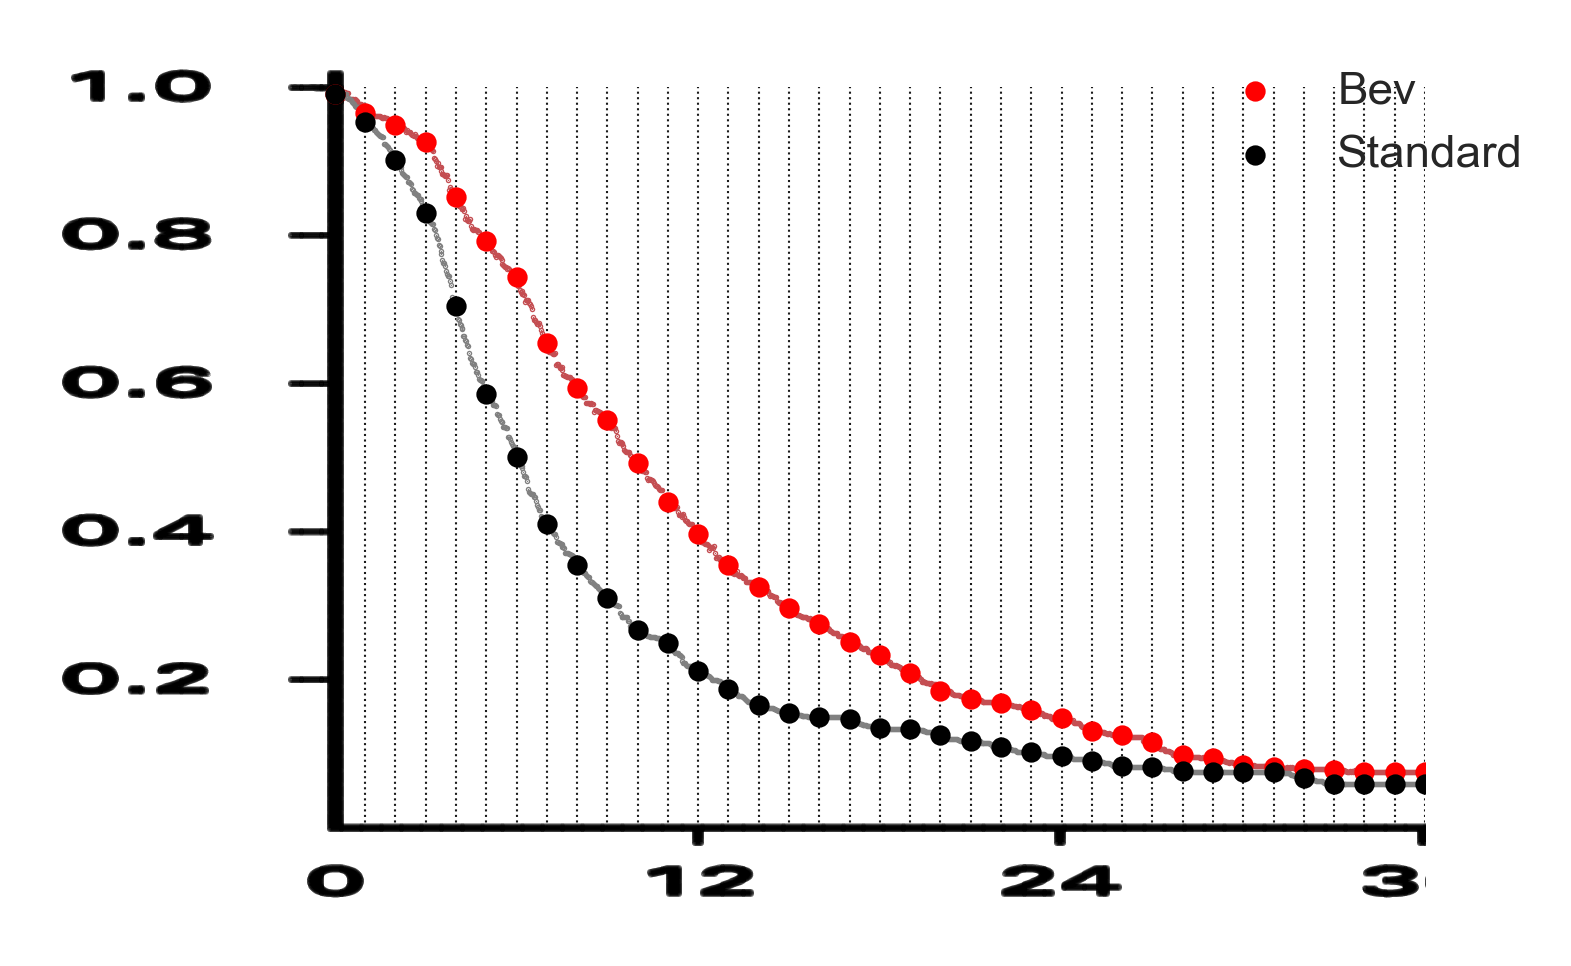

In [220]:
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=0.1,c='r')
ax.scatter(x2,y2,s=0.1,c='grey')
ax.scatter(x3,y3,s=0.001,c='black')
ax.scatter(ms,rs1,s=15,c='red',label='Bev')
ax.scatter(ms,rs2,s=15,c='black',label='Standard')

ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(0,m36)
ax.set_xlabel(val1)
ax.set_ylabel(val2)

ax.legend(bbox_to_anchor=(1.1,1) )

ax.set_axis_off()

In [221]:
xs=np.linspace(start=m0,stop=m36,num=1080)
ys_bev,ys_std=[],[]
for x in xs:
    y=df1[df1['X']==getNearestValue(list(df1['X']),x)]['Y'].values[0]
    ys_bev.append(y)
    
    y=df2[df2['X']==getNearestValue(list(df2['X']),x)]['Y'].values[0]
    ys_std.append(y)

In [222]:
table=pd.DataFrame({'xs':xs, "ys_bev":ys_bev,'ys_std':ys_std})
table['day']=table.index
table

xs       ys_bev  ys_std   day
0      320.000000  2409.285714  2410.0     0
1      321.060704  2409.285714  2410.0     1
2      322.121409  2409.285714  2410.0     2
3      323.182113  2409.285714  2410.0     3
4      324.242817  2409.285714  2410.0     4
...           ...          ...     ...   ...
1075  1460.257183   424.428571   387.0  1075
1076  1461.317887   424.428571   387.5  1076
1077  1462.378591   424.428571   388.0  1077
1078  1463.439296   424.428571   388.0  1078
1079  1464.500000   424.428571   388.0  1079

[1080 rows x 4 columns]

In [223]:
sr_bevs,sr_stds=[],[]
for idx in table.index:
    sr_bev=1-(sr1-table.loc[idx,'ys_bev'])/(sr1-sr0)
    sr_std=1-(sr1-table.loc[idx,'ys_std'])/(sr1-sr0)
    sr_bevs.append(sr_bev)
    sr_stds.append(sr_std)
    
table['survival_rate_bev']=sr_bevs
table['survival_rate_std']=sr_stds

In [224]:
# survival after 30 days
window=30
def_bevs=[]
def_stds=[]
risk_ratios=[]
for idx in table.index:
    if idx + window >= len(table):
        def_bevs.append(np.nan)
        def_stds.append(np.nan)
        risk_ratios.append(np.nan)
    else:
        def_bev=(table.loc[idx,'survival_rate_bev']-table.loc[idx+window,'survival_rate_bev'])/table.loc[idx,'survival_rate_bev']
        def_bevs.append(def_bev)
        def_std=(table.loc[idx,'survival_rate_std']-table.loc[idx+window,'survival_rate_std'])/table.loc[idx,'survival_rate_std']
        def_stds.append(def_std)
        
        if (def_bev==0)|(def_std==0):
            risk_ratios.append(np.nan)
        else:
            risk_ratios.append( np.log2(def_bev/def_std) )

table['prog_risk_bev']=def_bevs
table['prog_risk_std']=def_stds
table['prog_risk_ratio']=risk_ratios


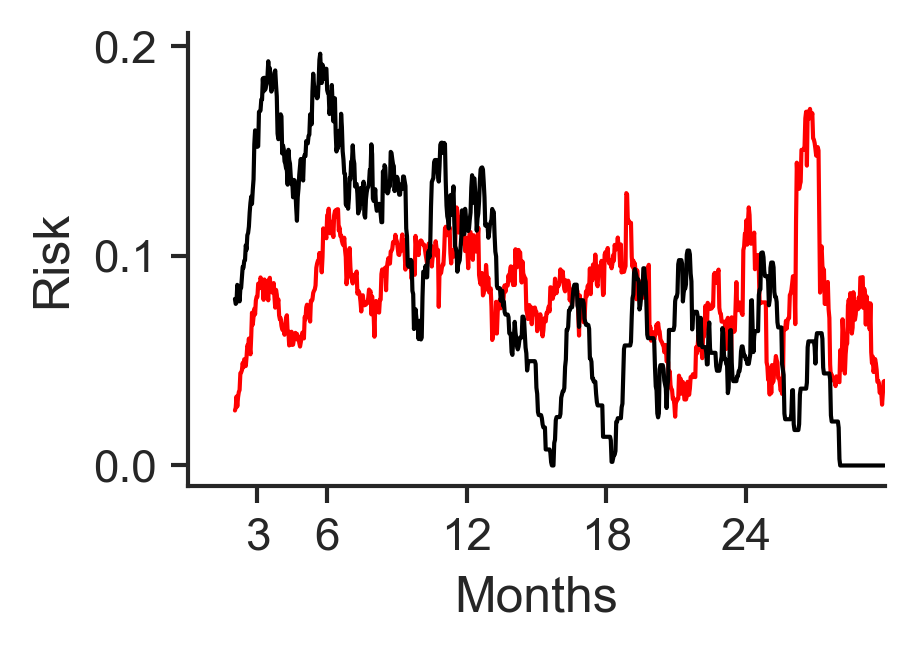

In [225]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev']
y2=plt_df2['prog_risk_std']
ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540,720])
ax.set_xticklabels([3,6,12,18,24])

ax.set_xlim(0,900)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

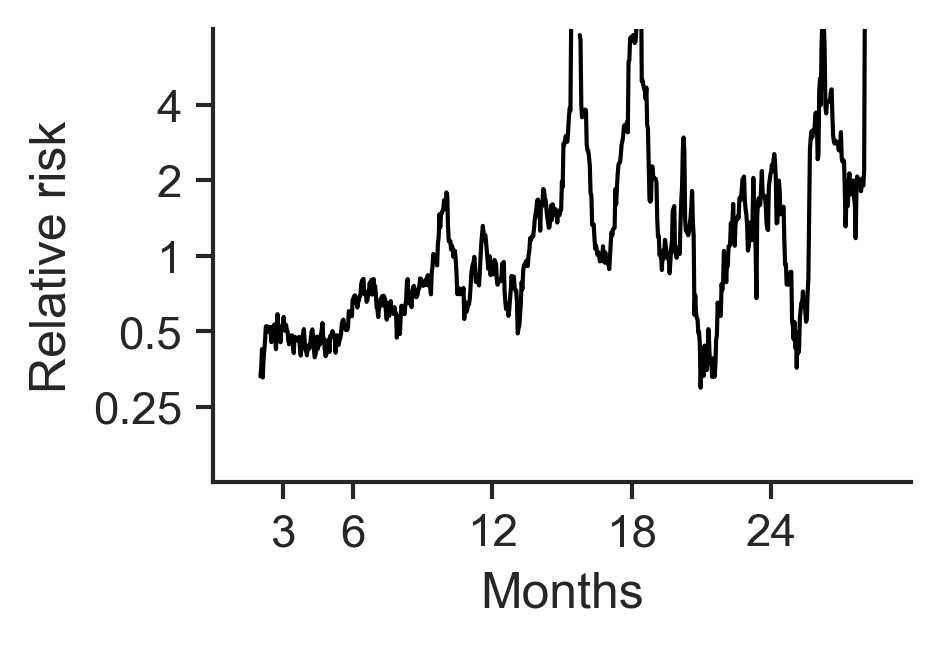

In [226]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio']
ax.plot(x,y,c='black',zorder=2)
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540,720])
ax.set_xticklabels([3,6,12,18,24])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,900)
ax.set_ylim(-3,3)

#ax.axvspan(xmin=30,xmax=12.6*30,color='lightgrey')
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

In [227]:
# Moving avarage
window2=2*30
ratio_aves=[]
ratio_sds=[]
ratio_bevs=[]
ratio_stds=[]

for idx in table.index:
    if idx < window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    elif idx > len(table.index)-window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    else:
        ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
        ratio_sds.append( np.nanstd( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) ) 
        ratio_bevs.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_bev'] ) )
        ratio_stds.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_std'] ) )

In [228]:
table['prog_risk_ratio_moving_average']=ratio_aves
table['prog_risk_bev_moving_average']=ratio_bevs
table['prog_risk_std_moving_average']=ratio_stds

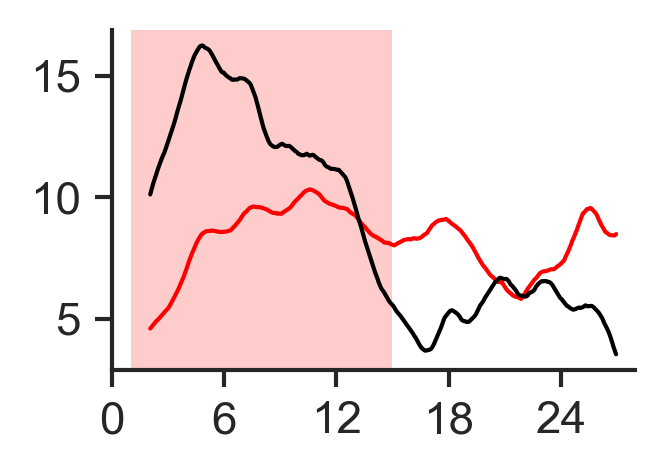

In [229]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.25,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev_moving_average']*100
y2=plt_df2['prog_risk_std_moving_average']*100

ax.plot(x,y1,c='red',zorder=2,label='Bev')
ax.plot(x,y2,c='black',zorder=2,label='Standard')

#ax.set_ylabel('Risk')
#ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])
ax.set_xlim(0,840)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

ax.axvspan(xmin=30,xmax=15*30,color=(1,0,0,0.2),linewidth=0)
#ax.legend(bbox_to_anchor=(1.2,1))
plt.savefig('../results/GOG218_KELIMhigh_pr_moving_average.pdf')

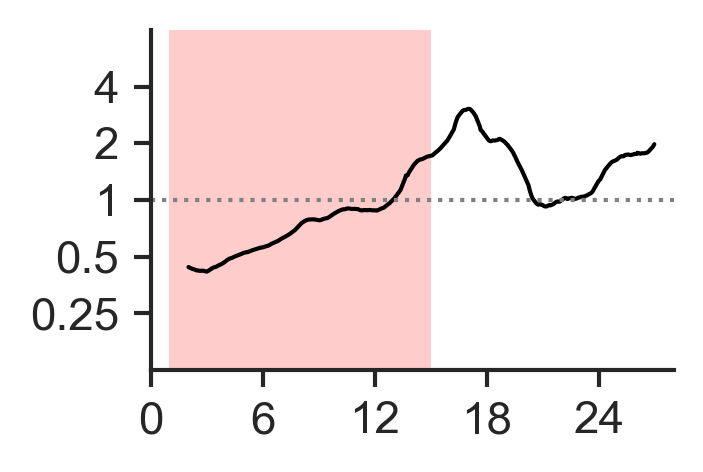

In [230]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.25,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio_moving_average']

ax.plot(plt_df2['day'],y,c='black',zorder=2)
ax.axhline(y=0,c='grey',ls='dotted')
#ax.set_ylabel('Relative risk')
#ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])
ax.set_xlim(0,840)

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_ylim(-3,3)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

ax.axvspan(xmin=30,xmax=15*30,color=(1,0,0,0.2),linewidth=0)
plt.savefig('../results/GOG218_KELIMhigh_rr_moving_average.pdf')

In [231]:
out_prefix='GOG218_KELIMhigh'

In [232]:
dict_rename={'xs':'X', 'ys_bev':'Y_bev', 'ys_std':'Y_std', 'prog_risk_ratio': 'log2_risk_ratio',
       'prog_risk_ratio_moving_average':'log2_risk_ratio_ma', 'prog_risk_bev_moving_average':'prog_risk_bev_ma',
       'prog_risk_std_moving_average':'prog_risk_std_ma'}

In [233]:
table_w=table.dropna(subset=['prog_risk_bev_moving_average','prog_risk_std_moving_average'])
table_w=table_w.set_index('day')
table_w=table_w.rename(columns=dict_rename)
table_w.to_csv('../results/'+out_prefix+'_table.tsv',sep='\t')

### KELIM low

In [234]:
df1=pd.read_csv('../data/GOG218_KELIMlow_bev_plus.tsv',sep='\t')
df1.head()

X       Y
0  328  2430.5
1  329  2430.5
2  330  2429.5
3  331  2428.0
4  332  2427.5

In [235]:
df2=pd.read_csv('../data/GOG218_KELIMlow_bev_minus.tsv',sep='\t')
df2.head()

X       Y
0  327  2442.0
1  328  2440.0
2  329  2440.0
3  330  2440.0
4  331  2440.0

In [236]:
df3=pd.read_csv('../data/GOG218_KELIMlow_axis_label.tsv',sep='\t')
df3.head()

X   Y
0  317  64
1  318  64
2  319  64
3  320  64
4  321  64

Text(0, 0.5, 'Y')

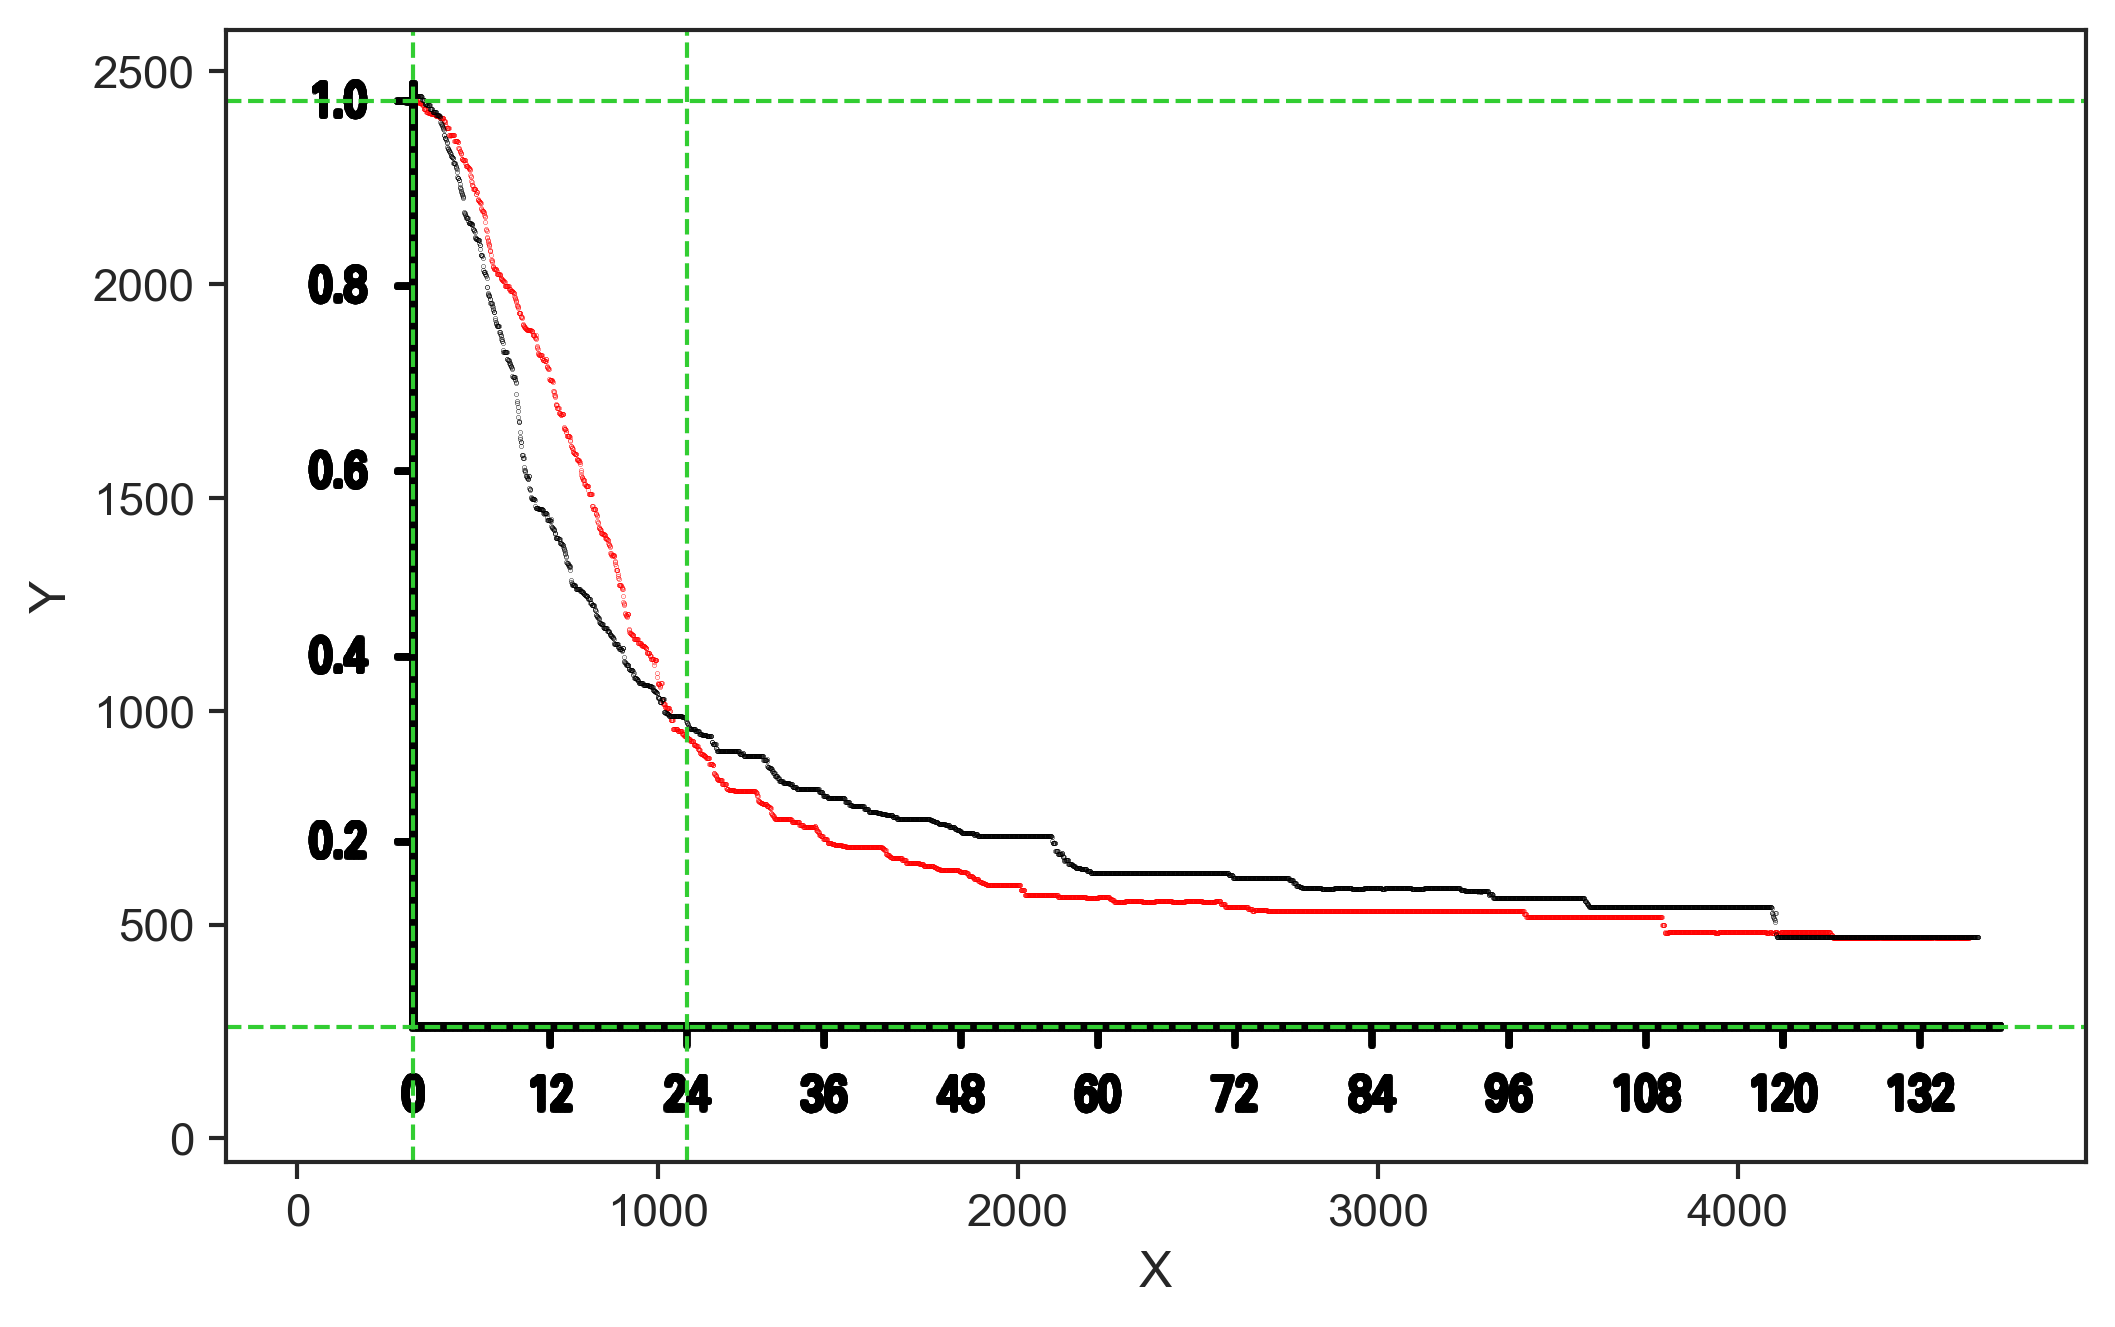

In [237]:
plt_df=df1.copy()
val1='X'
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(111)

plt_df=df1.copy()
plt_df=plt_df[['X','Y']].dropna()
x,y=plt_df['X'],plt_df['Y']
ax.scatter(x,y,s=0.01,c='red')

plt_df=df2.copy()
plt_df=plt_df[['X','Y']].dropna()
x2,y2=plt_df['X'],plt_df['Y']
ax.scatter(x2,y2,s=0.01,c='black')
plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

# Check axis 
sr1=2430
sr0=260
ax.axhline(y=sr1,c='limegreen',lw=1,ls='dashed')
ax.axhline(y=sr0,c='limegreen',lw=1,ls='dashed')

m0=320
m24=1083
ax.axvline(x=m0,c='limegreen',lw=1,ls='dashed')
ax.axvline(x=m24,c='limegreen',lw=1,ls='dashed')

plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

ax.set_xlabel(val1)
ax.set_ylabel(val2)

In [238]:
m12=m0+0.5*(m24-m0)
m36=m0+3*(m12-m0)

In [239]:
ms=[m0+i*(m12-m0)/12 for i in range(0,37)]
rs1=[df1[df1['X']==getNearestValue(list(df1['X']),m)]['Y'].values[0] for m in ms]
rs2=[df2[df2['X']==getNearestValue(list(df2['X']),m)]['Y'].values[0] for m in ms]

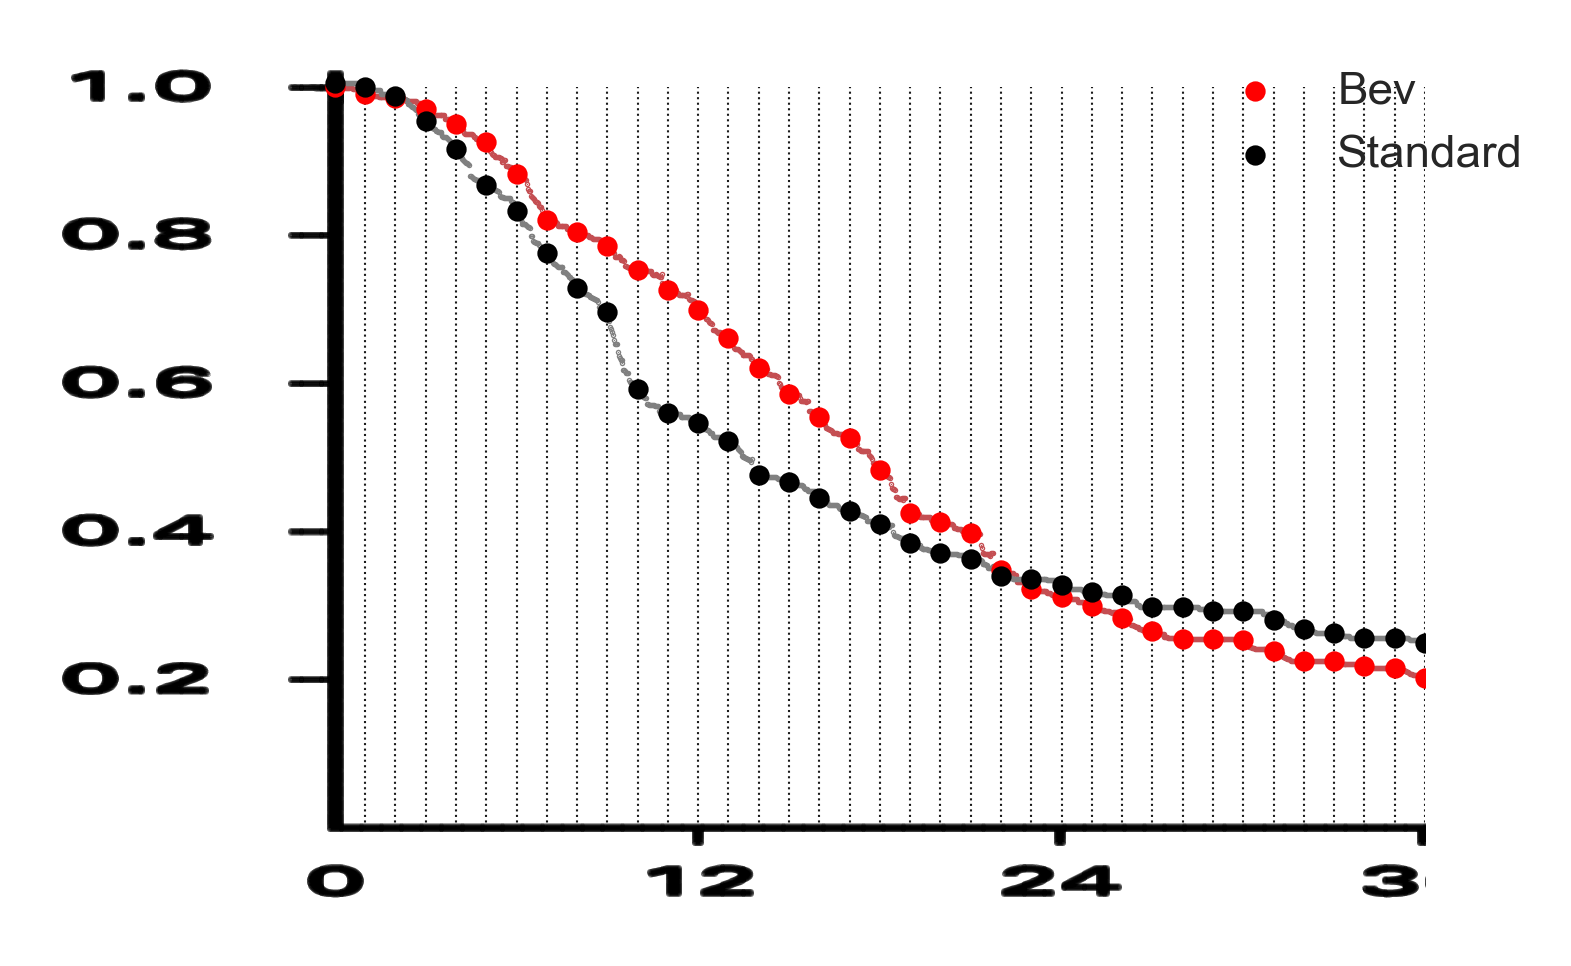

In [240]:
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=0.1,c='r')
ax.scatter(x2,y2,s=0.1,c='grey')
ax.scatter(x3,y3,s=0.001,c='black')
ax.scatter(ms,rs1,s=15,c='red',label='Bev')
ax.scatter(ms,rs2,s=15,c='black',label='Standard')

ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(0,m36)
ax.set_xlabel(val1)
ax.set_ylabel(val2)

ax.legend(bbox_to_anchor=(1.1,1) )

ax.set_axis_off()

In [241]:
xs=np.linspace(start=m0,stop=m36,num=1080)
ys_bev,ys_std=[],[]
for x in xs:
    y=df1[df1['X']==getNearestValue(list(df1['X']),x)]['Y'].values[0]
    ys_bev.append(y)
    
    y=df2[df2['X']==getNearestValue(list(df2['X']),x)]['Y'].values[0]
    ys_std.append(y)

In [242]:
table=pd.DataFrame({'xs':xs, "ys_bev":ys_bev,'ys_std':ys_std})
table['day']=table.index
table

xs  ys_bev  ys_std   day
0      320.000000  2430.5  2442.0     0
1      321.060704  2430.5  2442.0     1
2      322.121409  2430.5  2442.0     2
3      323.182113  2430.5  2442.0     3
4      324.242817  2430.5  2442.0     4
...           ...     ...     ...   ...
1075  1460.257183   700.0   801.5  1075
1076  1461.317887   699.5   801.0  1076
1077  1462.378591   699.5   801.0  1077
1078  1463.439296   699.5   801.0  1078
1079  1464.500000   699.5   801.0  1079

[1080 rows x 4 columns]

In [243]:
sr_bevs,sr_stds=[],[]
for idx in table.index:
    sr_bev=1-(sr1-table.loc[idx,'ys_bev'])/(sr1-sr0)
    sr_std=1-(sr1-table.loc[idx,'ys_std'])/(sr1-sr0)
    sr_bevs.append(sr_bev)
    sr_stds.append(sr_std)
    
table['survival_rate_bev']=sr_bevs
table['survival_rate_std']=sr_stds

In [244]:
# survival after 30 days
window=30
def_bevs=[]
def_stds=[]
risk_ratios=[]
for idx in table.index:
    if idx + window >= len(table):
        def_bevs.append(np.nan)
        def_stds.append(np.nan)
        risk_ratios.append(np.nan)
    else:
        def_bev=(table.loc[idx,'survival_rate_bev']-table.loc[idx+window,'survival_rate_bev'])/table.loc[idx,'survival_rate_bev']
        def_bevs.append(def_bev)
        def_std=(table.loc[idx,'survival_rate_std']-table.loc[idx+window,'survival_rate_std'])/table.loc[idx,'survival_rate_std']
        def_stds.append(def_std)
        
        if (def_bev==0)|(def_std==0):
            risk_ratios.append(np.nan)
        else:
            risk_ratios.append( np.log2(def_bev/def_std) )

table['prog_risk_bev']=def_bevs
table['prog_risk_std']=def_stds
table['prog_risk_ratio']=risk_ratios


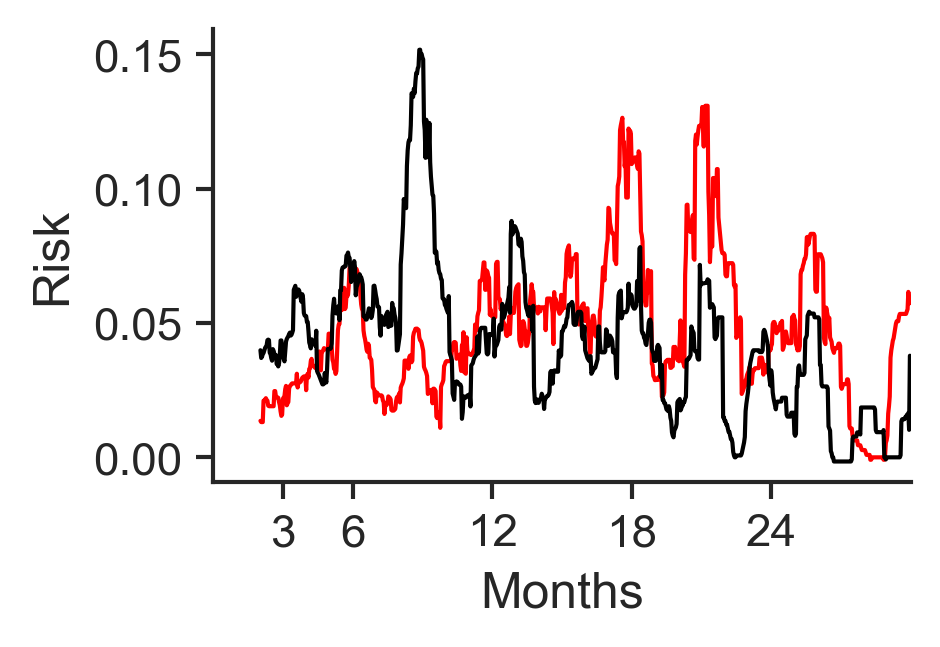

In [245]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev']
y2=plt_df2['prog_risk_std']
ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540,720])
ax.set_xticklabels([3,6,12,18,24])

ax.set_xlim(0,900)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

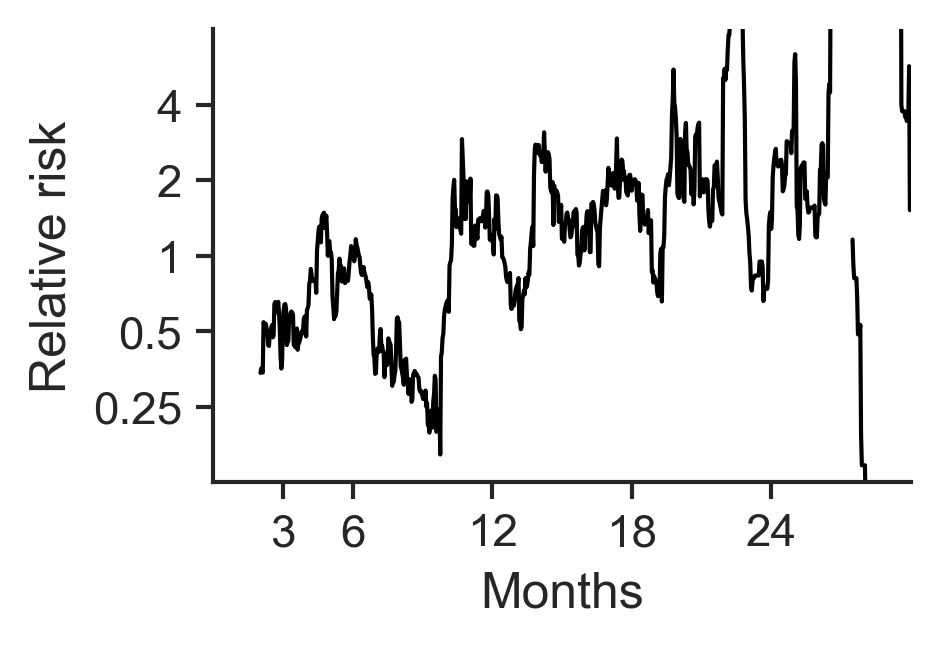

In [246]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio']
ax.plot(x,y,c='black',zorder=2)
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540,720])
ax.set_xticklabels([3,6,12,18,24])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,900)
ax.set_ylim(-3,3)

#ax.axvspan(xmin=30,xmax=12.6*30,color='lightgrey')
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

In [247]:
# Moving avarage
window2=2*30
ratio_aves=[]
ratio_sds=[]
ratio_bevs=[]
ratio_stds=[]

for idx in table.index:
    if idx < window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    elif idx > len(table.index)-window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    else:
        ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
        ratio_sds.append( np.nanstd( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) ) 
        ratio_bevs.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_bev'] ) )
        ratio_stds.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_std'] ) )

In [248]:
table['prog_risk_ratio_moving_average']=ratio_aves
table['prog_risk_bev_moving_average']=ratio_bevs
table['prog_risk_std_moving_average']=ratio_stds

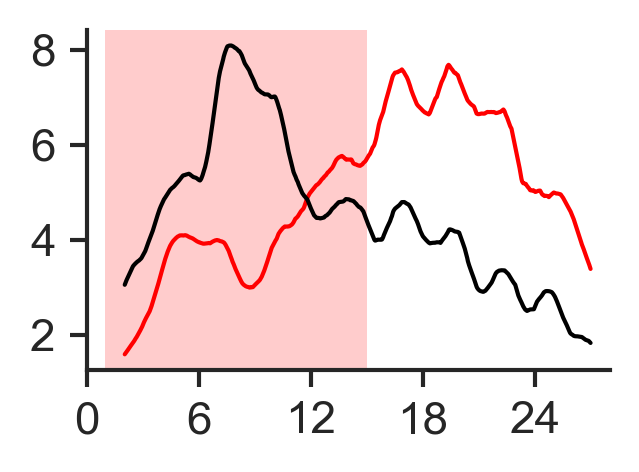

In [249]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.25,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev_moving_average']*100
y2=plt_df2['prog_risk_std_moving_average']*100

ax.plot(x,y1,c='red',zorder=2,label='Bev')
ax.plot(x,y2,c='black',zorder=2,label='Standard')

#ax.set_ylabel('Risk')
#ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720])
ax.set_yticks([2,4,6,8])
ax.set_xticklabels([0,6,12,18,24])
ax.set_xlim(0,840)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

ax.axvspan(xmin=30,xmax=15*30,color=(1,0,0,0.2),linewidth=0)
#ax.legend(bbox_to_anchor=(1.2,1))
plt.savefig('../results/GOG218_KELIMlow_pr_moving_average.pdf')

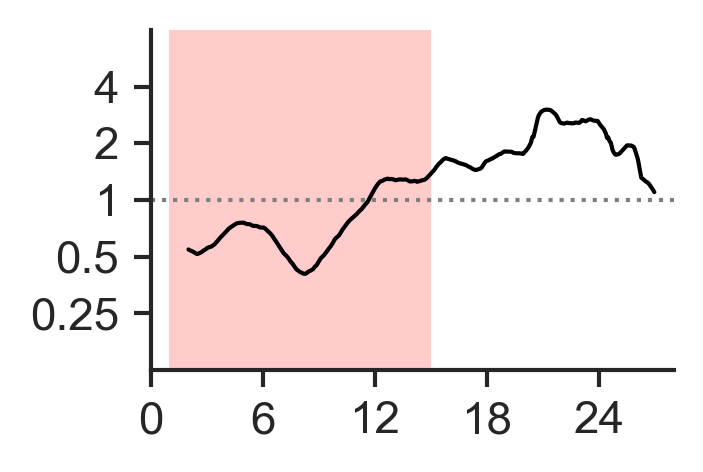

In [250]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.25,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<810)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio_moving_average']

ax.plot(plt_df2['day'],y,c='black',zorder=2)
ax.axhline(y=0,c='grey',ls='dotted')
#ax.set_ylabel('Relative risk')
#ax.set_xlabel('Months')
ax.set_xticks([0,180,360,540,720])
ax.set_xticklabels([0,6,12,18,24])
ax.set_xlim(0,840)

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_ylim(-3,3)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

ax.axvspan(xmin=30,xmax=15*30,color=(1,0,0,0.2),linewidth=0)

plt.savefig('../results/GOG218_KELIMlow_rr_moving_average.pdf')

In [251]:
out_prefix='GOG218_KELIMlow'

In [252]:
dict_rename={'xs':'X', 'ys_bev':'Y_bev', 'ys_std':'Y_std', 'prog_risk_ratio': 'log2_risk_ratio',
       'prog_risk_ratio_moving_average':'log2_risk_ratio_ma', 'prog_risk_bev_moving_average':'prog_risk_bev_ma',
       'prog_risk_std_moving_average':'prog_risk_std_ma'}

In [253]:
table_w=table.dropna(subset=['prog_risk_bev_moving_average','prog_risk_std_moving_average'])
table_w=table_w.set_index('day')
table_w=table_w.rename(columns=dict_rename)
table_w.to_csv('../results/'+out_prefix+'_table.tsv',sep='\t')

# BOOST

In [254]:
df1=pd.read_csv('../data/BOOST_bev_plus.tsv',sep='\t')
df1.head()

X            Y
0  316  2053.000000
1  317  2053.500000
2  318  2045.586207
3  319  2043.777778
4  320  2043.500000

In [255]:
df2=pd.read_csv('../data/BOOST_bev_minus.tsv',sep='\t')
df2.head()

X            Y
0  309  2057.955224
1  310  2057.000000
2  311  2057.000000
3  312  2056.926471
4  313  2049.095238

In [256]:
df3=pd.read_csv('../data/BOOST_axis_label.tsv',sep='\t')
df3.head()

X   Y
0  294  90
1  295  90
2  296  90
3  297  90
4  298  90

Text(0, 0.5, 'Y')

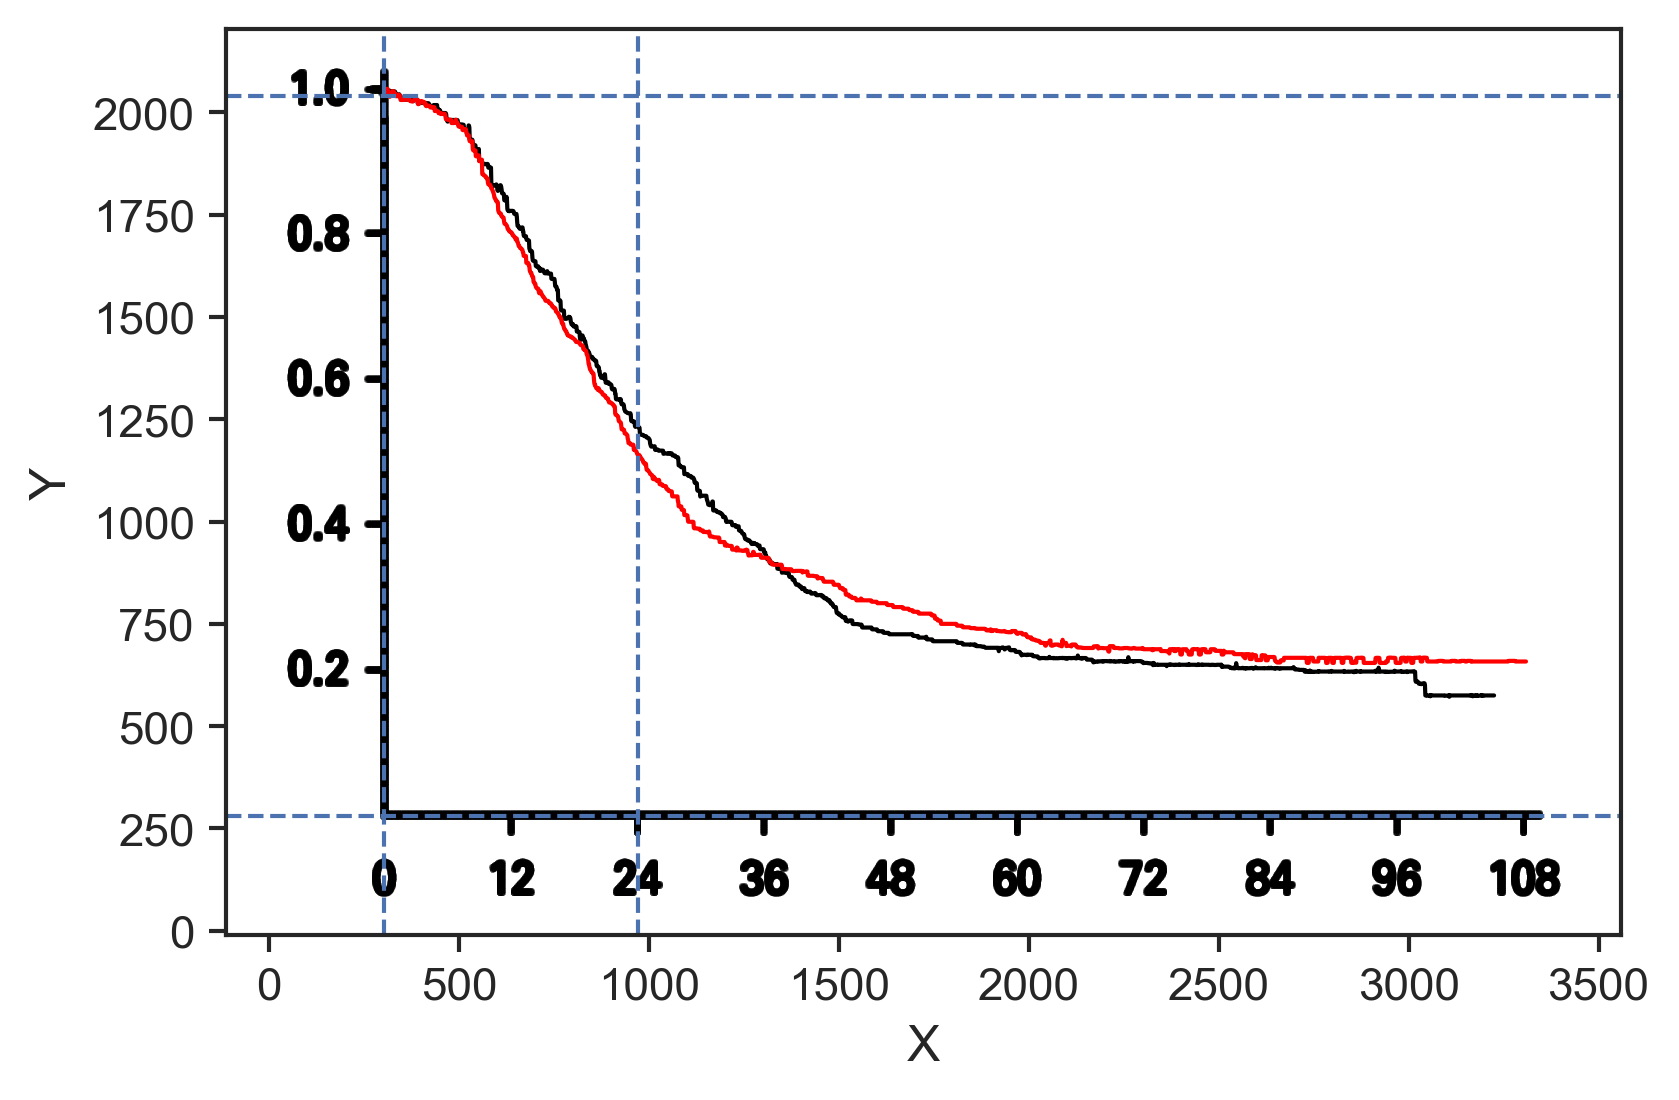

In [257]:
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(x,y,c='black')
ax.plot(x2,y2,c='red')
ax.scatter(x3,y3,s=0.001,c='black')

# Check axis 
sr1=2041
sr0=280
ax.axhline(y=sr1,ls='dashed')
ax.axhline(y=sr0,ls='dashed')

m0=302
m24=970
ax.axvline(x=m0,ls='dashed')
ax.axvline(x=m24,ls='dashed')

ax.set_xlabel(val1)
ax.set_ylabel(val2)

In [258]:
m48=m0+2*(m24-m0)
m60=m0+2.5*(m24-m0)

In [259]:
ms=[m0+i*(m24-m0)/24 for i in range(0,60)]

In [260]:
rs1=[df1[df1['X']==getNearestValue(list(df1['X']),m)]['Y'].values[0] for m in ms]
rs2=[df2[df2['X']==getNearestValue(list(df2['X']),m)]['Y'].values[0] for m in ms]

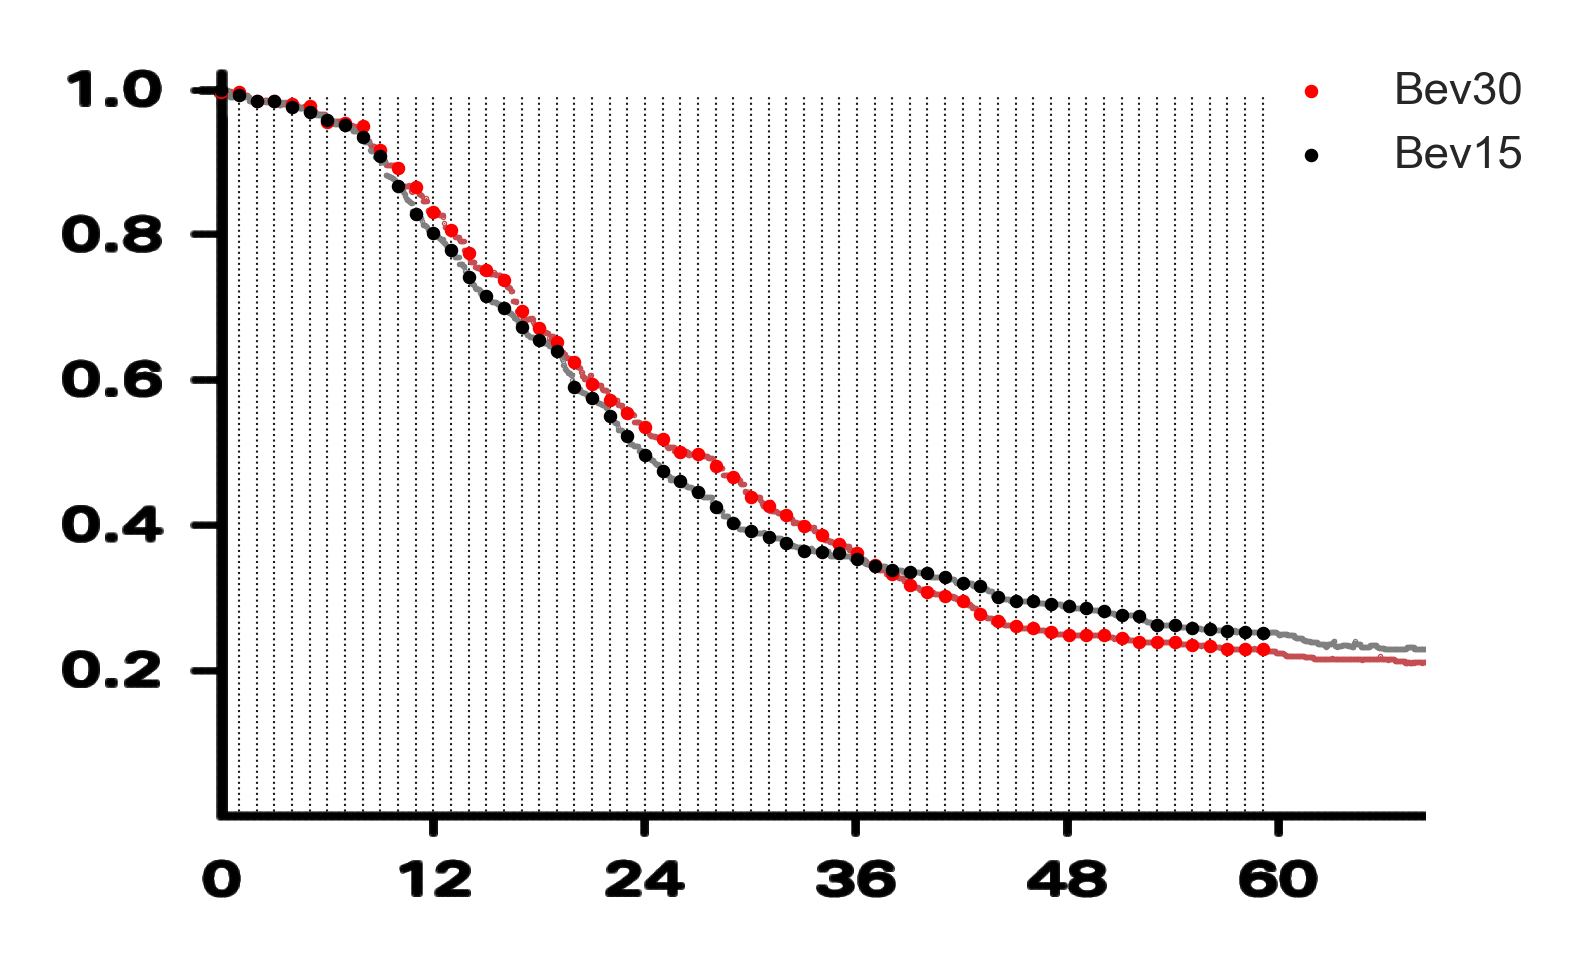

In [261]:
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=0.1,c='r')
ax.scatter(x2,y2,s=0.1,c='grey')
ax.scatter(x3,y3,s=0.001,c='black')
ax.scatter(ms,rs1,s=5,c='red',label='Bev30')
ax.scatter(ms,rs2,s=5,c='black',label='Bev15')

ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(0,2200)
ax.set_xlabel(val1)
ax.set_ylabel(val2)

ax.legend(bbox_to_anchor=(1.1,1) )

ax.set_axis_off()

In [262]:
xs=np.linspace(start=m0,stop=m60,num=1800)

In [263]:
ys_bev,ys_std=[],[]
for x in xs:
    y=df1[df1['X']==getNearestValue(list(df1['X']),x)]['Y'].values[0]
    ys_bev.append(y)
    
    y=df2[df2['X']==getNearestValue(list(df2['X']),x)]['Y'].values[0]
    ys_std.append(y)

In [264]:
table=pd.DataFrame({'xs':xs, "ys_bev30":ys_bev,'ys_bev15':ys_std})
table['day']=table.index


In [265]:
sr_bevs,sr_stds=[],[]
for idx in table.index:
    sr_bev=1-(sr1-table.loc[idx,'ys_bev30'])/(sr1-sr0)
    sr_std=1-(sr1-table.loc[idx,'ys_bev15'])/(sr1-sr0)
    sr_bevs.append(sr_bev)
    sr_stds.append(sr_std)
    
table['survival_rate_bev30']=sr_bevs
table['survival_rate_bev15']=sr_stds
table

xs  ys_bev30     ys_bev15   day  survival_rate_bev30  \
0      302.000000    2053.0  2057.955224     0             1.006814   
1      302.928293    2053.0  2057.955224     1             1.006814   
2      303.856587    2053.0  2057.955224     2             1.006814   
3      304.784880    2053.0  2057.955224     3             1.006814   
4      305.713174    2053.0  2057.955224     4             1.006814   
...           ...       ...          ...   ...                  ...   
1795  1968.286826     681.5   726.500000  1795             0.227995   
1796  1969.215120     681.5   726.000000  1796             0.227995   
1797  1970.143413     681.5   726.000000  1797             0.227995   
1798  1971.071707     681.5   725.500000  1798             0.227995   
1799  1972.000000     681.5   728.000000  1799             0.227995   

      survival_rate_bev15  
0                1.009628  
1                1.009628  
2                1.009628  
3                1.009628  
4                1.009628  
...                   ...  
1795             0.253549  
1796             0.253265  
1797             0.253265  
1798             0.252981  
1799             0.254401  

[1800 rows x 6 columns]

In [266]:
# survival after 30 days
window=30
def_bevs=[]
def_stds=[]
risk_ratios=[]
for idx in table.index:
    if idx + window >= len(table):
        def_bevs.append(np.nan)
        def_stds.append(np.nan)
        risk_ratios.append(np.nan)
    else:
        def_bev=(table.loc[idx,'survival_rate_bev30']-table.loc[idx+window,'survival_rate_bev30'])/table.loc[idx,'survival_rate_bev30']
        def_bevs.append(def_bev)
        def_std=(table.loc[idx,'survival_rate_bev15']-table.loc[idx+window,'survival_rate_bev15'])/table.loc[idx,'survival_rate_bev15']
        def_stds.append(def_std)
        
        if (def_bev==0)|(def_std==0):
            risk_ratios.append(np.nan)
        else:
            risk_ratios.append( np.log2(def_bev/def_std) )

table['prog_risk_bev30']=def_bevs
table['prog_risk_bev15']=def_stds
table['prog_risk_ratio']=risk_ratios

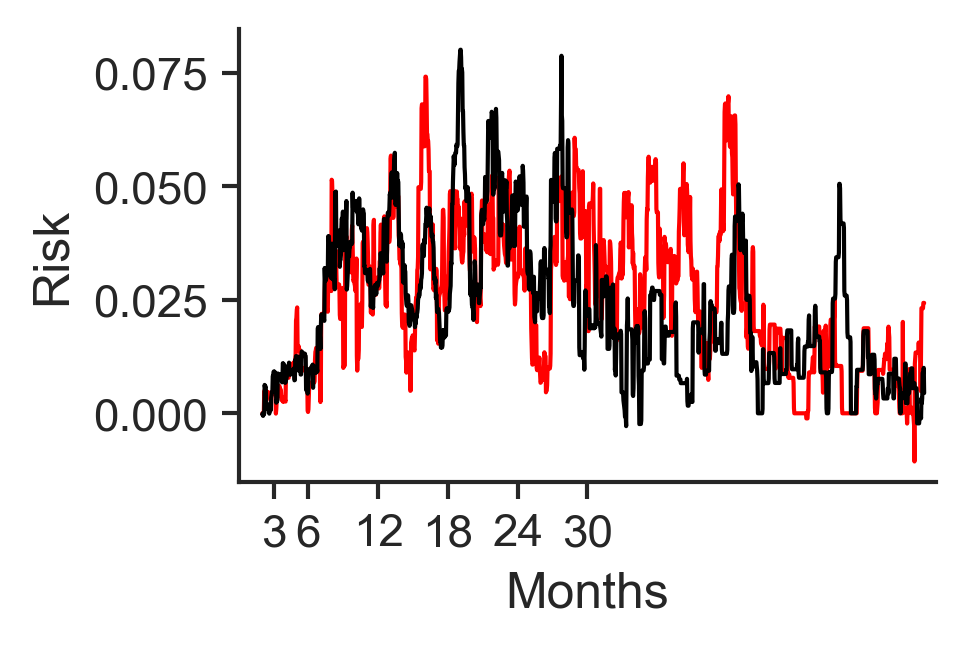

In [267]:
window2=60
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<1800)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev30']
y2=plt_df2['prog_risk_bev15']
ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540,720,900])
ax.set_xticklabels([3,6,12,18,24,30])

ax.set_xlim(0,1800)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

In [268]:
# Moving avarage
window2=2*30
ratio_aves=[]
ratio_bev30=[]
ratio_bev15=[]

for idx in table.index:
    if idx < window2 :
        ratio_aves.append(np.nan)
        ratio_bev30.append(np.nan)
        ratio_bev15.append(np.nan)
    elif idx > len(table.index)- window2:
        ratio_aves.append(np.nan)
        ratio_bev30.append(np.nan)
        ratio_bev15.append(np.nan)    
    else:
        ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ))
        ratio_bev30.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_bev30'] ))
        ratio_bev15.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_bev15'] ))

In [269]:
table['prog_risk_ratio_moving_average']=ratio_aves
table['prog_risk_bev30_moving_average']=ratio_bev30
table['prog_risk_bev15_moving_average']=ratio_bev15

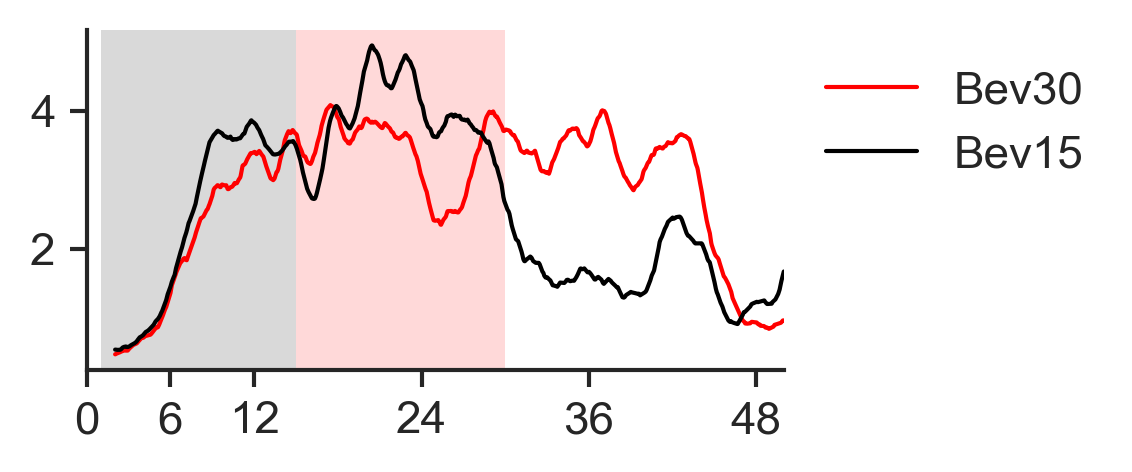

In [270]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<1500)]
ax.plot(plt_df2['day'],plt_df2['prog_risk_bev30_moving_average']*100,c='red',label='Bev30')
ax.plot(plt_df2['day'],plt_df2['prog_risk_bev15_moving_average']*100,c='black',label='Bev15')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticks([0,180,360,720,1080,1440])
ax.set_xticklabels([0,6,12,24,36,48])
ax.set_xlim(0,1500)

ax.axvspan(xmin=30,xmax=15*30,color=(0,0,0,0.15),linewidth=0,zorder=2)
ax.axvspan(xmin=15*30,xmax=30*30,color=(1,0,0,0.15),linewidth=0,zorder=2)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

ax.legend(bbox_to_anchor=(1,1))

plt.savefig('../results/BOOST_pr_moving_average.pdf')

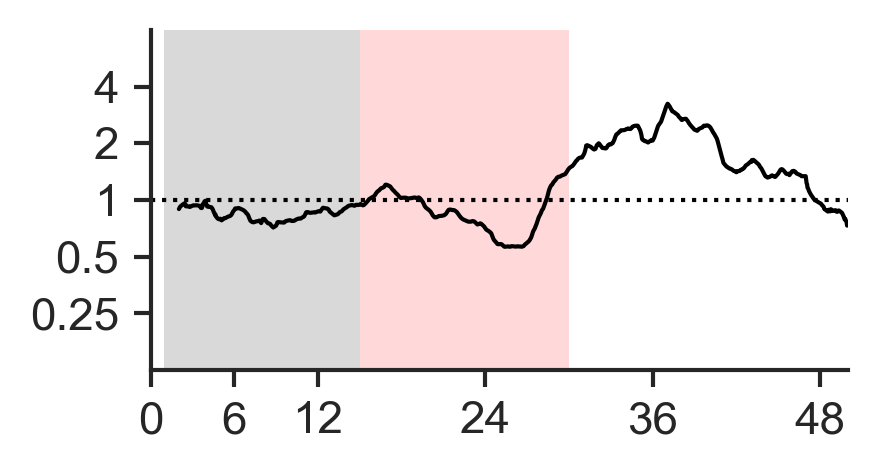

In [271]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,1.5))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<1500)]
ax.plot(plt_df2['day'],plt_df2['prog_risk_ratio_moving_average'],c='black')
ax.axhline(y=0,c='black',ls='dotted')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticks([0,180,360,720,1080,1440])
ax.set_xticklabels([0,6,12,24,36,48])
ax.set_xlim(0,1500)

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_ylim(-3,3)

ax.axvspan(xmin=30,xmax=15*30,color=(0,0,0,0.15),linewidth=0,zorder=2)
ax.axvspan(xmin=15*30,xmax=30*30,color=(1,0,0,0.15),linewidth=0,zorder=2)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig('../results/BOOST_rr_moving_average.pdf')

In [272]:
out_prefix='BOOST'

In [273]:
dict_rename={'xs':'X', 'ys_bev30':'Y_bev30', 'ys_bev15':'Y_bev15', 'prog_risk_ratio': 'log2_risk_ratio',
       'prog_risk_ratio_moving_average':'log2_risk_ratio_ma', 'prog_risk_bev30_moving_average':'prog_risk_bev30_ma',
       'prog_risk_bev15_moving_average':'prog_risk_bev15_ma'}

In [274]:
table_w=table.dropna(subset=['prog_risk_bev15_moving_average','prog_risk_bev30_moving_average'])
table_w=table_w.set_index('day')
table_w=table_w.rename(columns=dict_rename)
table_w.to_csv('../results/'+out_prefix+'_table.tsv',sep='\t')

# Reccurence

## GOG0213

In [275]:
df1=pd.read_csv('../data/GOG213_bev_plus.tsv',sep='\t')
df1.head()

X       Y
0  254  2519.0
1  255  2517.0
2  256  2517.0
3  257  2517.0
4  258  2517.0

In [276]:
df2=pd.read_csv('../data/GOG213_bev_minus.tsv',sep='\t')
df2.head()

X       Y
0  263  2510.0
1  264  2510.5
2  265  2510.5
3  266  2510.5
4  267  2510.5

In [277]:
df3=pd.read_csv('../data/GOG213_axis_label.tsv',sep='\t')
df3.head()

X   Y
0  1708  29
1  1710  29
2  1712  29
3  1717  29
4  1718  29

Text(0.5, 0, 'X')

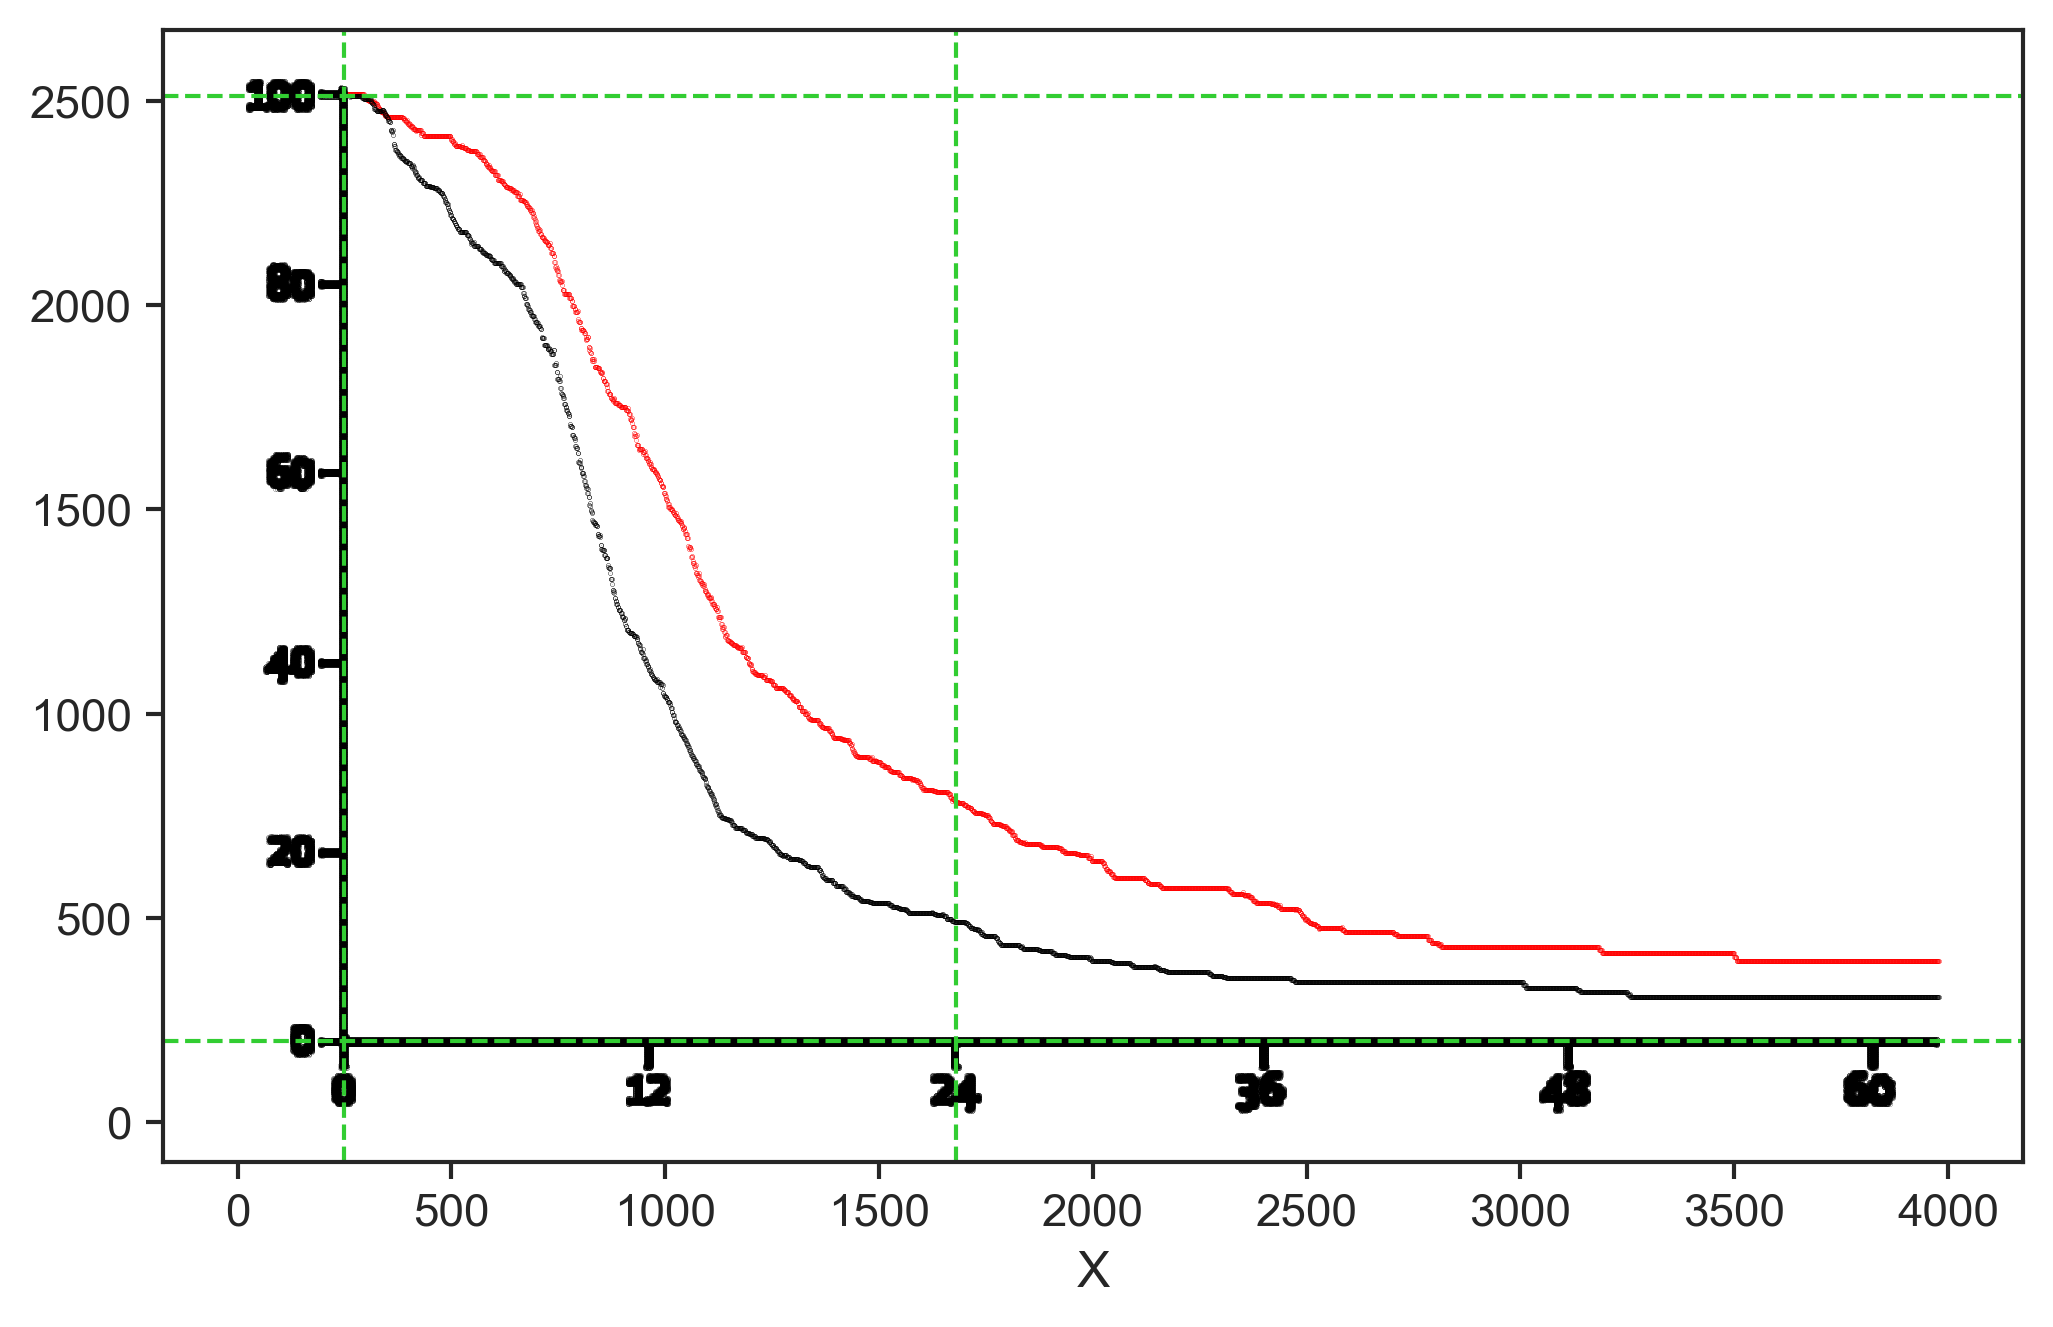

In [278]:
plt_df=df1.copy()
val1='X'
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(111)

plt_df=df1.copy()
plt_df=plt_df[['X','Y']].dropna()
x,y=plt_df['X'],plt_df['Y']
ax.scatter(x,y,s=0.01,c='red')

plt_df=df2.copy()
plt_df=plt_df[['X','Y']].dropna()
x2,y2=plt_df['X'],plt_df['Y']
ax.scatter(x2,y2,s=0.01,c='black')
plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

# Check axis 
sr1=2512
sr0=200
ax.axhline(y=sr1,c='limegreen',lw=1,ls='dashed')
ax.axhline(y=sr0,c='limegreen',lw=1,ls='dashed')

m0=250
m24=1679
ax.axvline(x=m0,c='limegreen',lw=1,ls='dashed')
ax.axvline(x=m24,c='limegreen',lw=1,ls='dashed')

plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

ax.set_xlabel(val1)
#ax.set_ylabel(val2)

In [279]:
m12=m0+0.5*(m24-m0)
m36=m0+3*(m12-m0)
m48=m0+4*(m12-m0)

In [280]:
ms=[m0+i*(m12-m0)/12 for i in range(0,37)]
rs1=[df1[df1['X']==getNearestValue(list(df1['X']),m)]['Y'].values[0] for m in ms]
rs2=[df2[df2['X']==getNearestValue(list(df2['X']),m)]['Y'].values[0] for m in ms]

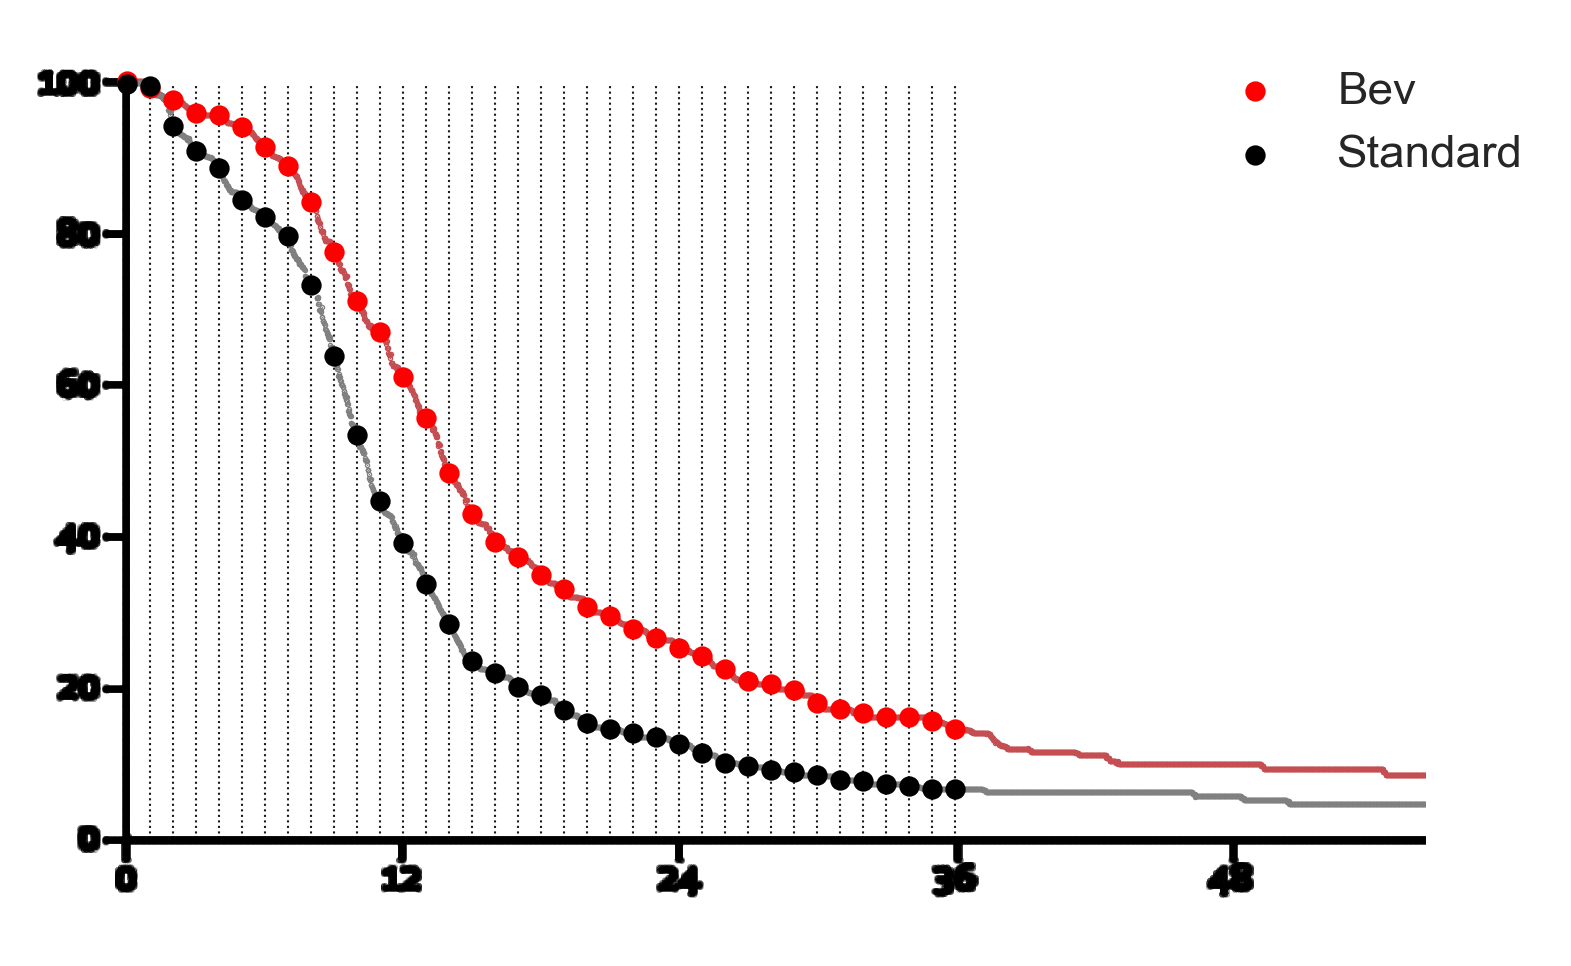

In [281]:
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=0.1,c='r')
ax.scatter(x2,y2,s=0.1,c='grey')
ax.scatter(x3,y3,s=0.001,c='black')
ax.scatter(ms,rs1,s=15,c='red',label='Bev')
ax.scatter(ms,rs2,s=15,c='black',label='Standard')

ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(0,m48+500)
ax.set_xlabel(val1)
ax.set_ylabel(val2)

ax.legend(bbox_to_anchor=(1.1,1) )

ax.set_axis_off()

In [282]:
xs=np.linspace(start=m0,stop=m48,num=1440)
ys_bev,ys_std=[],[]
for x in xs:
    y=df1[df1['X']==getNearestValue(list(df1['X']),x)]['Y'].values[0]
    ys_bev.append(y)
    
    y=df2[df2['X']==getNearestValue(list(df2['X']),x)]['Y'].values[0]
    ys_std.append(y)

In [283]:
table=pd.DataFrame({'xs':xs, "ys_bev":ys_bev,'ys_std':ys_std})
table['day']=table.index
table

xs  ys_bev  ys_std   day
0      250.000000  2519.0  2510.0     0
1      251.986101  2519.0  2510.0     1
2      253.972203  2519.0  2510.0     2
3      255.958304  2517.0  2510.0     3
4      257.944406  2517.0  2510.0     4
...           ...     ...     ...   ...
1435  3100.055594   428.5   330.0  1435
1436  3102.041696   428.5   330.0  1436
1437  3104.027797   428.5   330.0  1437
1438  3106.013899   428.5   330.0  1438
1439  3108.000000   428.5   330.0  1439

[1440 rows x 4 columns]

In [284]:
sr_bevs,sr_stds=[],[]
for idx in table.index:
    sr_bev=1-(sr1-table.loc[idx,'ys_bev'])/(sr1-sr0)
    sr_std=1-(sr1-table.loc[idx,'ys_std'])/(sr1-sr0)
    sr_bevs.append(sr_bev)
    sr_stds.append(sr_std)
    
table['survival_rate_bev']=sr_bevs
table['survival_rate_std']=sr_stds

In [285]:
# survival after 30 days
window=30
def_bevs=[]
def_stds=[]
risk_ratios=[]
for idx in table.index:
    if idx + window >= len(table):
        def_bevs.append(np.nan)
        def_stds.append(np.nan)
        risk_ratios.append(np.nan)
    else:
        def_bev=(table.loc[idx,'survival_rate_bev']-table.loc[idx+window,'survival_rate_bev'])/table.loc[idx,'survival_rate_bev']
        def_bevs.append(def_bev)
        def_std=(table.loc[idx,'survival_rate_std']-table.loc[idx+window,'survival_rate_std'])/table.loc[idx,'survival_rate_std']
        def_stds.append(def_std)
        
        if (def_bev==0)|(def_std==0):
            risk_ratios.append(np.nan)
        else:
            risk_ratios.append( np.log2(def_bev/def_std) )

table['prog_risk_bev']=def_bevs
table['prog_risk_std']=def_stds
table['prog_risk_ratio']=risk_ratios


In [286]:
window2=60

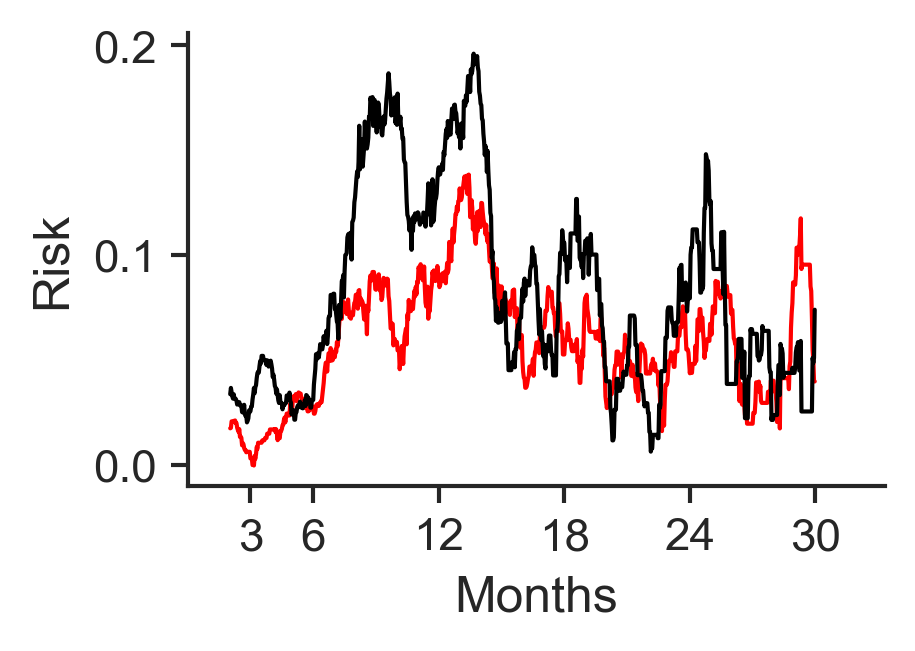

In [287]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev']
y2=plt_df2['prog_risk_std']
ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540,720,900])
ax.set_xticklabels([3,6,12,18,24,30])

ax.set_xlim(0,1000)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

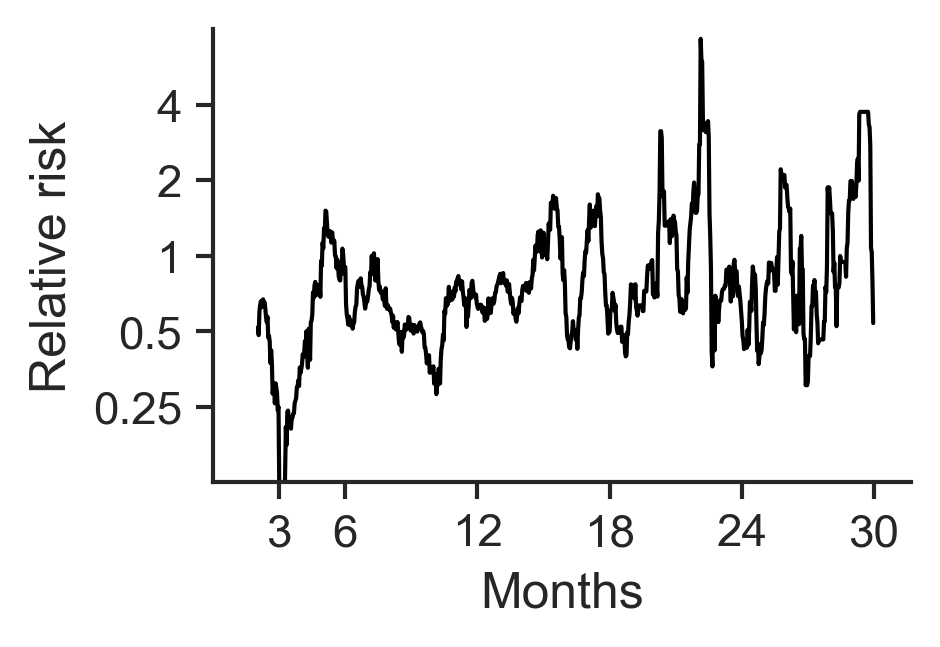

In [288]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio']
ax.plot(x,y,c='black',zorder=2)
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540,720,900])
ax.set_xticklabels([3,6,12,18,24,30])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,950)
ax.set_ylim(-3,3)

#ax.axvspan(xmin=30,xmax=12.6*30,color='lightgrey')
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

In [289]:
# Moving avarage
window2=2*30
ratio_aves=[]
ratio_sds=[]
ratio_bevs=[]
ratio_stds=[]

for idx in table.index:
    if idx < window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    elif idx > len(table.index)-window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    else:
        ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
        ratio_sds.append( np.nanstd( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) ) 
        ratio_bevs.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_bev'] ) )
        ratio_stds.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_std'] ) )

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_28788/3803783179.py:20: RuntimeWarning: Mean of empty slice
  ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
/Users/tshiro/.pyenv/versions/miniforge3-4.10/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [290]:
table['prog_risk_ratio_moving_average']=ratio_aves
table['prog_risk_bev_moving_average']=ratio_bevs
table['prog_risk_std_moving_average']=ratio_stds

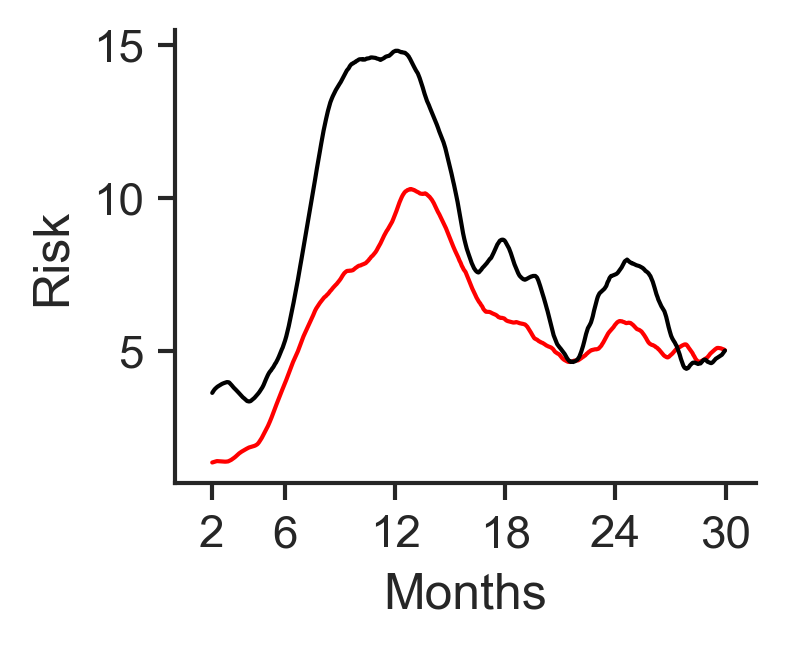

In [291]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev_moving_average']*100
y2=plt_df2['prog_risk_std_moving_average']*100

ax.plot(x,y1,c='red',zorder=2,label='Bev')
ax.plot(x,y2,c='black',zorder=2,label='Standard')

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([60,180,360,540,720,900])
ax.set_xticklabels([2,6,12,18,24,30])
ax.set_xlim(0,950)
ax.set_yticks([5,10,15])

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig('../results/GOG213_pr_moving_average.pdf')

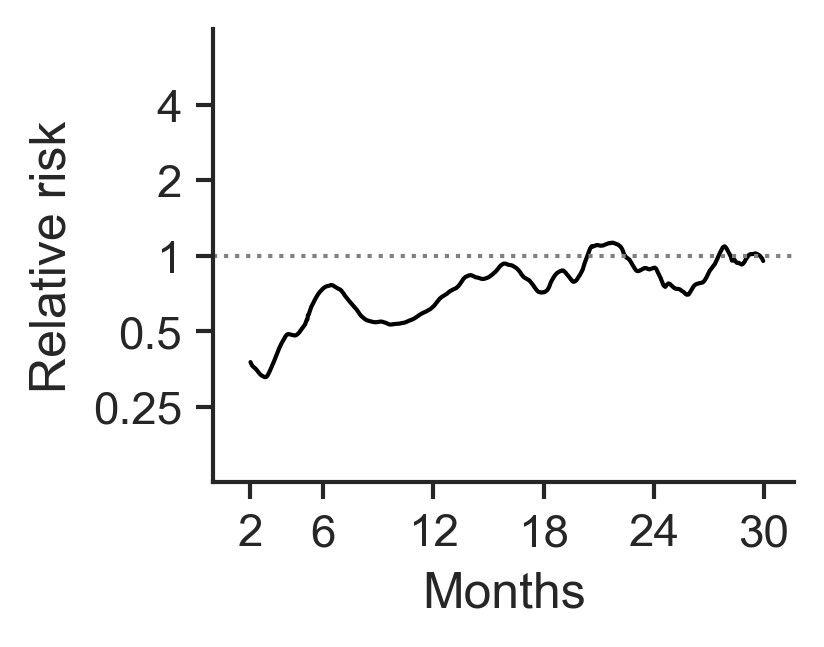

In [292]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<900)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio_moving_average']

ax.plot(plt_df2['day'],y,c='black',zorder=2)
ax.axhline(y=0,c='grey',ls='dotted')
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([60,180,360,540,720,900,1080])
ax.set_xticklabels([2,6,12,18,24,30,36])
ax.set_xlim(0,950)

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_ylim(-3,3)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig('../results/GOG213_rr_moving_average.pdf')

In [293]:
out_prefix='GOG213'

In [294]:
table_w=table.dropna(subset=['prog_risk_bev_moving_average','prog_risk_std_moving_average'])
table_w=table_w.set_index('day')
table_w=table_w.rename(columns=dict_rename)
table_w.to_csv('../results/'+out_prefix+'_table.tsv',sep='\t')

## OCEANS

In [295]:
df1=pd.read_csv('../data/OCEANS_bev_plus.tsv',sep='\t')
df1.head()

X       Y
0  304  2036.5
1  305  2036.5
2  306  2036.5
3  307  2036.5
4  308  2036.5

In [296]:
df2=pd.read_csv('../data/OCEANS_bev_minus.tsv',sep='\t')
df2.head()

X       Y
0  304  2038.0
1  305  2038.0
2  306  2038.0
3  307  2038.0
4  308  2038.0

In [297]:
df3=pd.read_csv('../data/OCEANS_axis_label.tsv',sep='\t')
df3.head()

X   Y
0  167  35
1  168  35
2  169  35
3  170  35
4  171  35

Text(0, 0.5, 'Y')

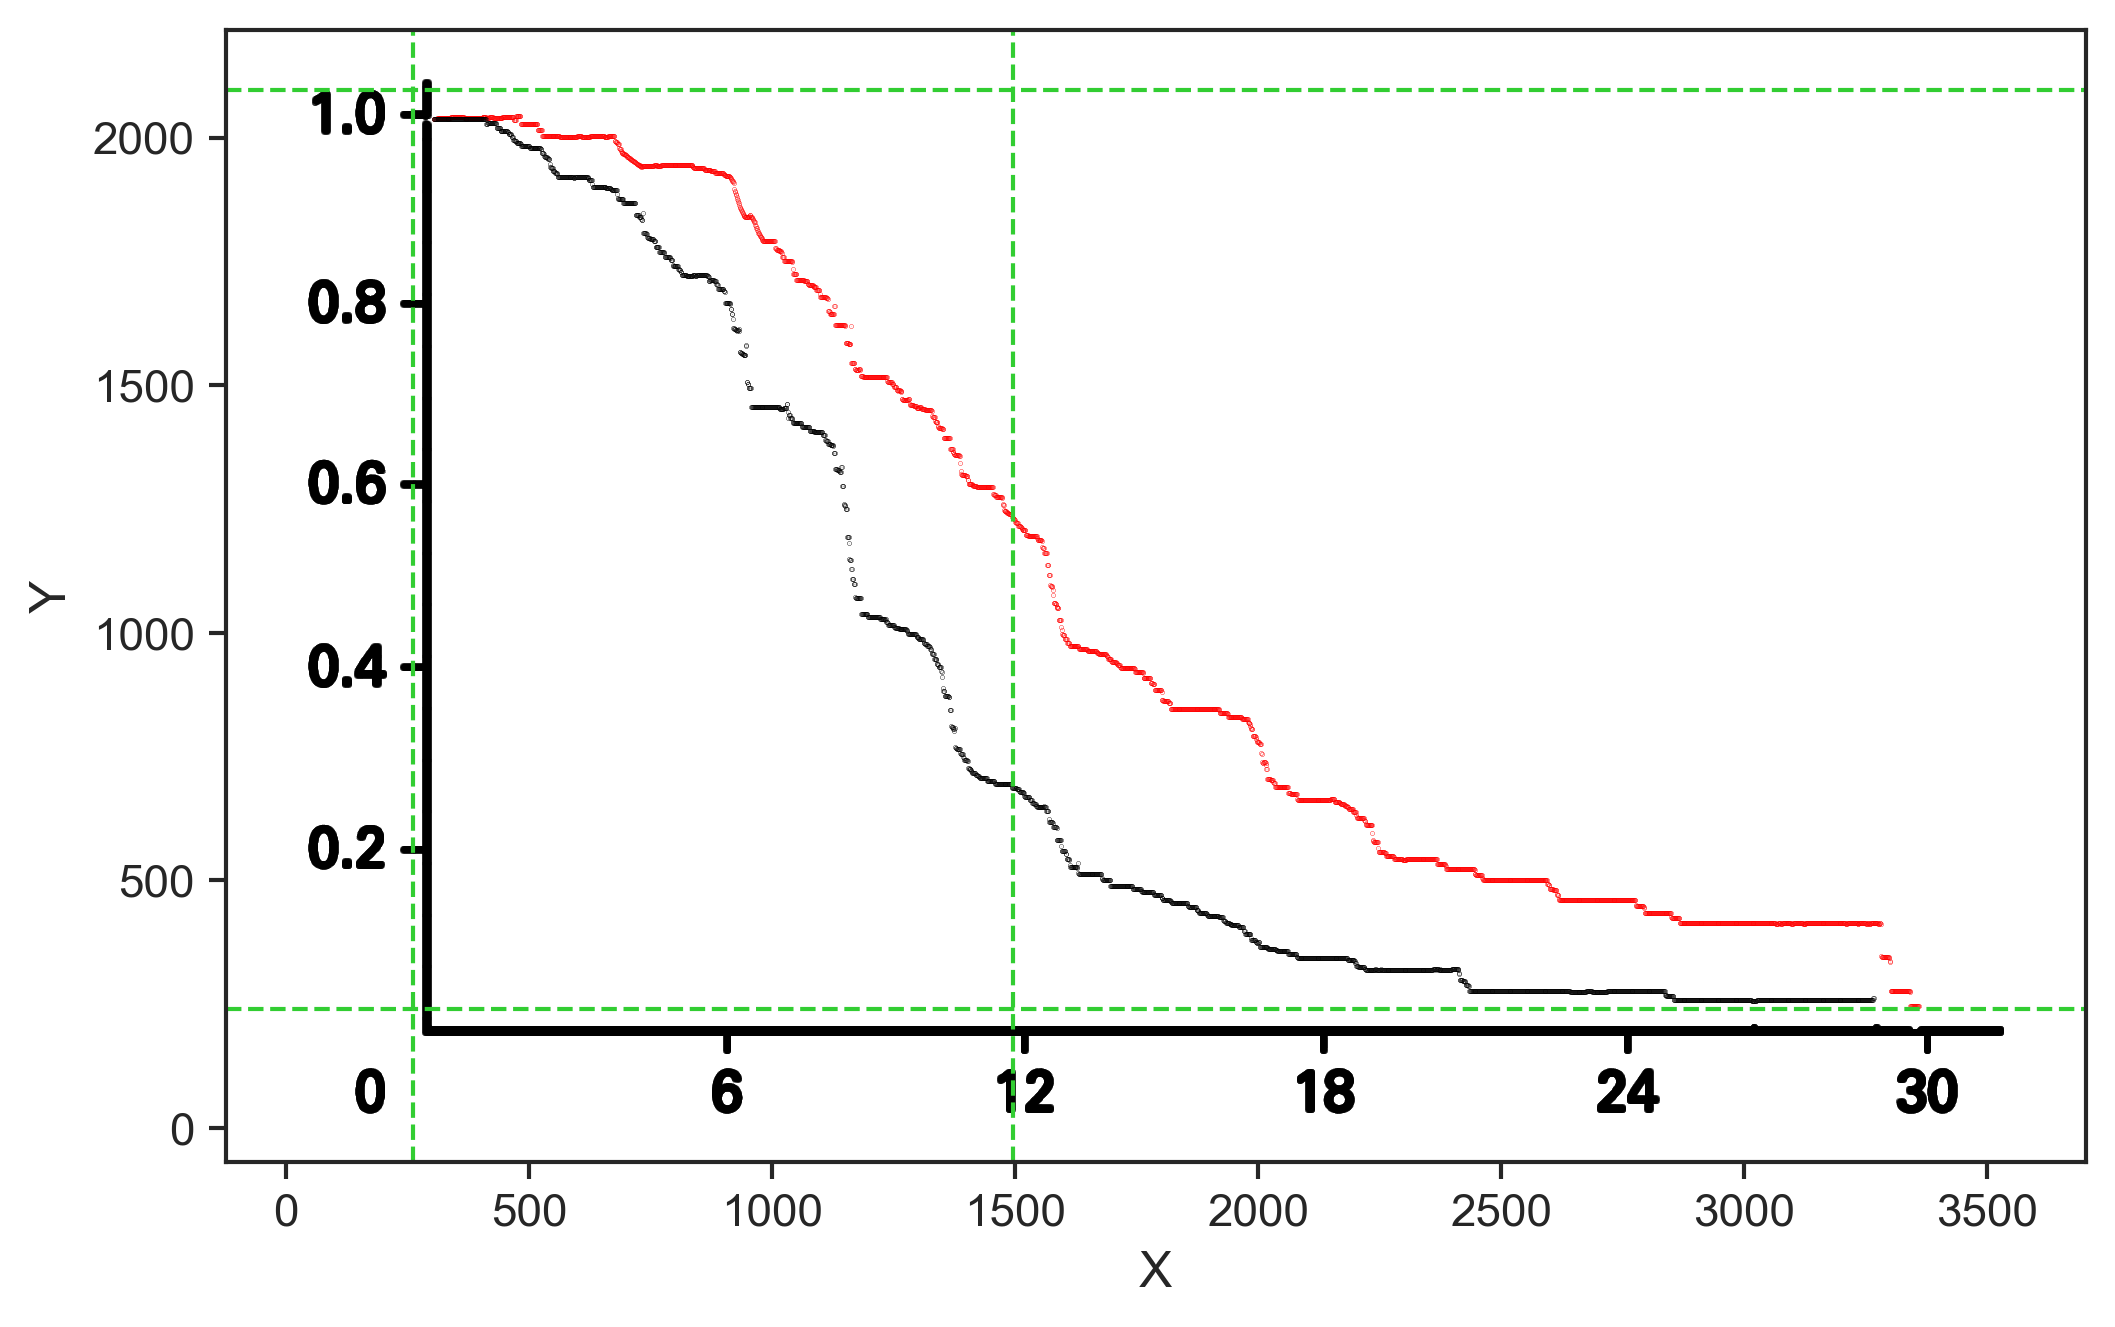

In [298]:
plt_df=df1.copy()
val1='X'
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(111)

plt_df=df1.copy()
plt_df=plt_df[['X','Y']].dropna()
x,y=plt_df['X'],plt_df['Y']
ax.scatter(x,y,s=0.01,c='red')

plt_df=df2.copy()
plt_df=plt_df[['X','Y']].dropna()
x2,y2=plt_df['X'],plt_df['Y']
ax.scatter(x2,y2,s=0.01,c='black')
plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

# Check axis 
sr1=2095
sr0=240
ax.axhline(y=sr1,c='limegreen',lw=1,ls='dashed')
ax.axhline(y=sr0,c='limegreen',lw=1,ls='dashed')

m0=260
m12=1496
ax.axvline(x=m0,c='limegreen',lw=1,ls='dashed')
ax.axvline(x=m12,c='limegreen',lw=1,ls='dashed')

plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

ax.set_xlabel(val1)
ax.set_ylabel(val2)

In [299]:
m24=m0+2*(m12-m0)
m36=m0+3*(m12-m0)

In [300]:
ms=[m0+i*(m12-m0)/12 for i in range(0,19)]
rs1=[df1[df1['X']==getNearestValue(list(df1['X']),m)]['Y'].values[0] for m in ms]
rs2=[df2[df2['X']==getNearestValue(list(df2['X']),m)]['Y'].values[0] for m in ms]

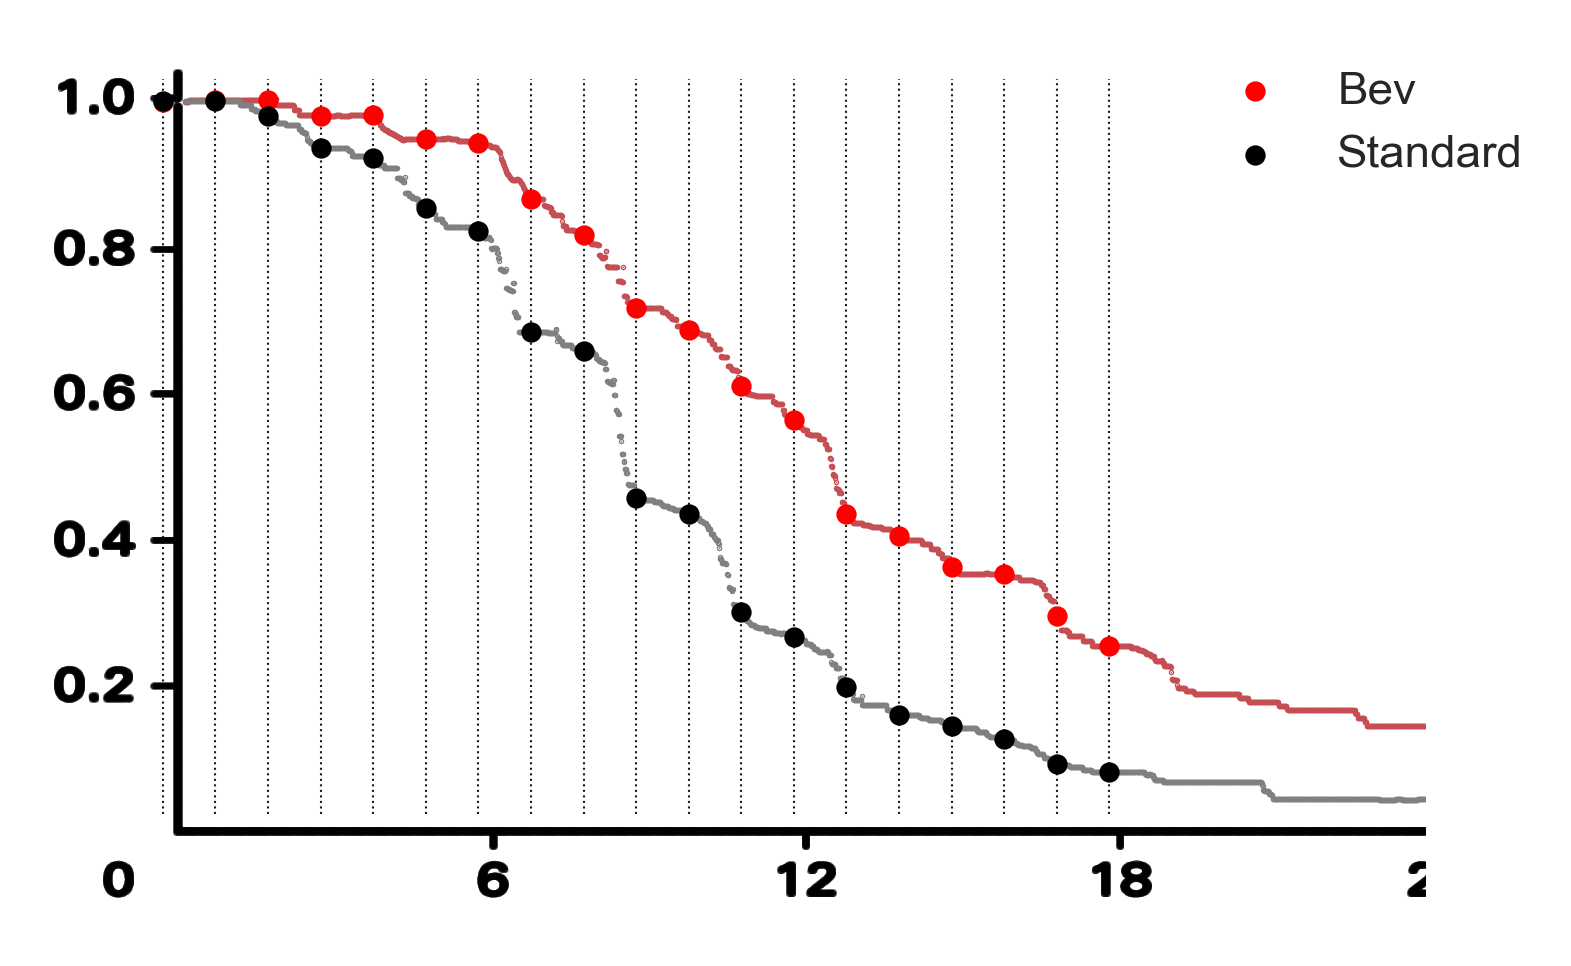

In [301]:
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=0.1,c='r')
ax.scatter(x2,y2,s=0.1,c='grey')
ax.scatter(x3,y3,s=0.001,c='black')
ax.scatter(ms,rs1,s=15,c='red',label='Bev')
ax.scatter(ms,rs2,s=15,c='black',label='Standard')

ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(0,m24)
ax.set_xlabel(val1)
ax.set_ylabel(val2)

ax.legend(bbox_to_anchor=(1.1,1) )

ax.set_axis_off()

In [302]:
xs=np.linspace(start=m0,stop=m24,num=720)
ys_bev,ys_std=[],[]
for x in xs:
    y=df1[df1['X']==getNearestValue(list(df1['X']),x)]['Y'].values[0]
    ys_bev.append(y)
    
    y=df2[df2['X']==getNearestValue(list(df2['X']),x)]['Y'].values[0]
    ys_std.append(y)

In [303]:
table=pd.DataFrame({'xs':xs, "ys_bev":ys_bev,'ys_std':ys_std})
table['day']=table.index
table

xs  ys_bev  ys_std  day
0     260.000000  2036.5  2038.0    0
1     263.438108  2036.5  2038.0    1
2     266.876217  2036.5  2038.0    2
3     270.314325  2036.5  2038.0    3
4     273.752434  2036.5  2038.0    4
..           ...     ...     ...  ...
715  2718.247566   461.0   276.5  715
716  2721.685675   461.0   276.5  716
717  2725.123783   461.0   276.5  717
718  2728.561892   461.0   276.5  718
719  2732.000000   461.0   276.5  719

[720 rows x 4 columns]

In [304]:
sr_bevs,sr_stds=[],[]
for idx in table.index:
    sr_bev=1-(sr1-table.loc[idx,'ys_bev'])/(sr1-sr0)
    sr_std=1-(sr1-table.loc[idx,'ys_std'])/(sr1-sr0)
    sr_bevs.append(sr_bev)
    sr_stds.append(sr_std)
    
table['survival_rate_bev']=sr_bevs
table['survival_rate_std']=sr_stds

In [305]:
# survival after 30 days
window=30
def_bevs=[]
def_stds=[]
risk_ratios=[]
for idx in table.index:
    if idx + window >= len(table):
        def_bevs.append(np.nan)
        def_stds.append(np.nan)
        risk_ratios.append(np.nan)
    else:
        def_bev=(table.loc[idx,'survival_rate_bev']-table.loc[idx+window,'survival_rate_bev'])/table.loc[idx,'survival_rate_bev']
        def_bevs.append(def_bev)
        def_std=(table.loc[idx,'survival_rate_std']-table.loc[idx+window,'survival_rate_std'])/table.loc[idx,'survival_rate_std']
        def_stds.append(def_std)
        
        if (def_bev==0)|(def_std==0):
            risk_ratios.append(np.nan)
        else:
            risk_ratios.append( np.log2(def_bev/def_std) )

table['prog_risk_bev']=def_bevs
table['prog_risk_std']=def_stds
table['prog_risk_ratio']=risk_ratios


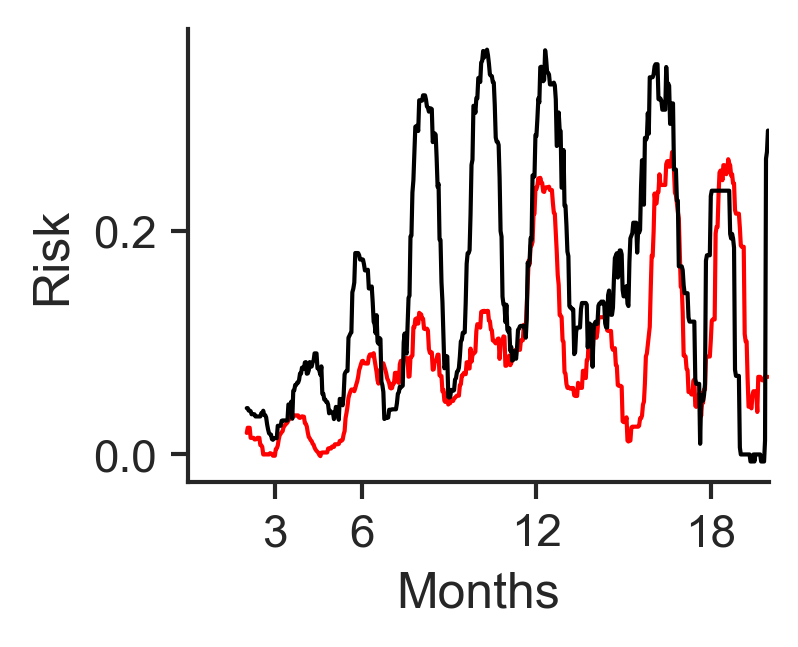

In [306]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<600)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev']
y2=plt_df2['prog_risk_std']
ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540,720])
ax.set_xticklabels([3,6,12,18,24])

ax.set_xlim(0,600)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

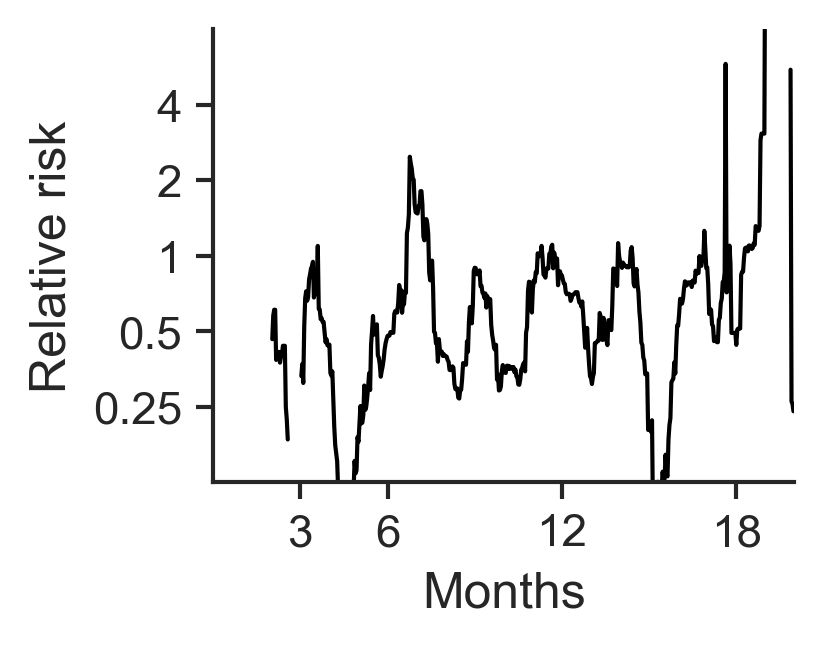

In [307]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<600)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio']
ax.plot(x,y,c='black',zorder=2)
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540,720])
ax.set_xticklabels([3,6,12,18,24])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,600)
ax.set_ylim(-3,3)

#ax.axvspan(xmin=30,xmax=12.6*30,color='lightgrey')
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

In [308]:
# Moving avarage
window2=2*30
ratio_aves=[]
ratio_sds=[]
ratio_bevs=[]
ratio_stds=[]

for idx in table.index:
    if idx < window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    elif idx > len(table.index)-window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    else:
        ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
        ratio_sds.append( np.nanstd( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) ) 
        ratio_bevs.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_bev'] ) )
        ratio_stds.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_std'] ) )

In [309]:
table['prog_risk_ratio_moving_average']=ratio_aves
table['prog_risk_bev_moving_average']=ratio_bevs
table['prog_risk_std_moving_average']=ratio_stds

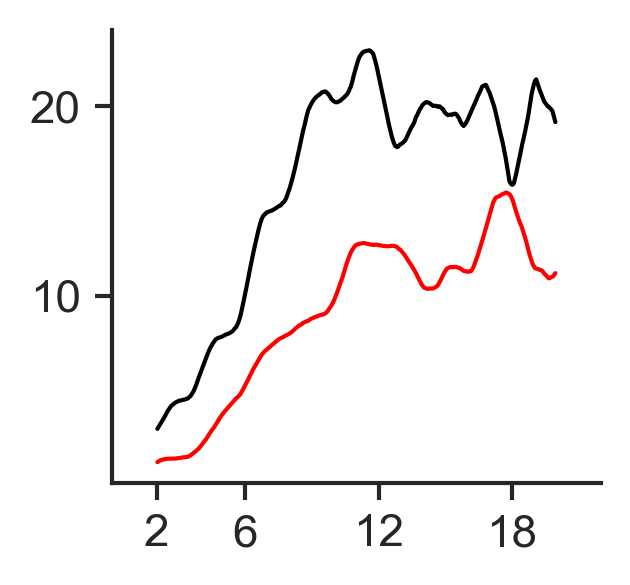

In [310]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.1,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<600)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev_moving_average']*100
y2=plt_df2['prog_risk_std_moving_average']*100

ax.plot(x,y1,c='red',zorder=2,label='Bev')
ax.plot(x,y2,c='black',zorder=2,label='Standard')

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticks([60,180,360,540])
ax.set_xticklabels([2,6,12,18])
ax.set_xlim(0,660)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

#ax.legend(bbox_to_anchor=(1.2,1))

plt.savefig('../results/OCEANS_pr_moving_average.pdf')

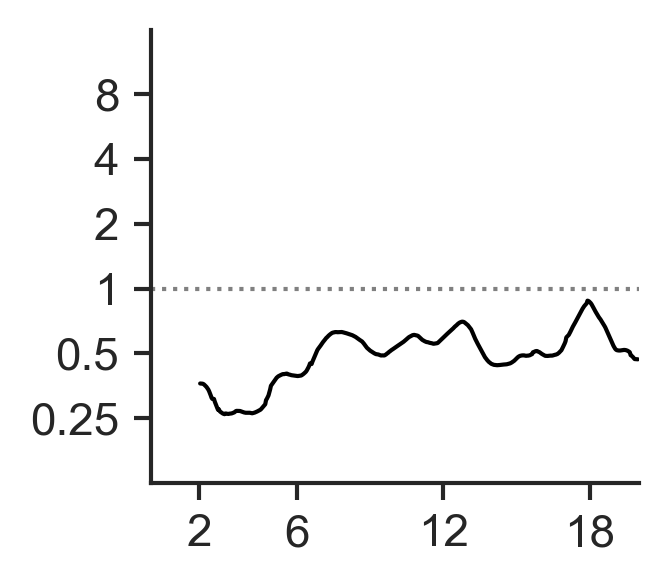

In [311]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.1,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<600)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio_moving_average']

ax.plot(plt_df2['day'],y,c='black',zorder=2)
ax.axhline(y=0,c='grey',ls='dotted')
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_ylabel('')
ax.set_xlabel('')

ax.set_xticks([60,180,360,540])
ax.set_xticklabels([2,6,12,18])
ax.set_xlim(0,600)

ax.set_yticks([-2,-1,0,1,2,3])
ax.set_yticklabels([0.25,0.5,1,2,4,8])
ax.set_ylim(-3,4)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig('../results/OCEANS_rr_moving_average.pdf')

In [312]:
out_prefix='OCEANS'

In [313]:
table_w=table.dropna(subset=['prog_risk_bev_moving_average','prog_risk_std_moving_average'])
table_w=table_w.set_index('day')
table_w=table_w.rename(columns=dict_rename)
table_w.to_csv('../results/'+out_prefix+'_table.tsv',sep='\t')

## AURELIA

In [314]:
df1=pd.read_csv('../data/AURELIA_bev_plus.tsv',sep='\t')
df1.head()

X     Y
0  288  2213
1  289  2213
2  290  2213
3  291  2213
4  292  2213

In [315]:
df2=pd.read_csv('../data/OCEANS_bev_minus.tsv',sep='\t')
df2.head()

X       Y
0  304  2038.0
1  305  2038.0
2  306  2038.0
3  307  2038.0
4  308  2038.0

In [316]:
df3=pd.read_csv('../data/AURELIA_axis_label.tsv',sep='\t')
df3.head()

X   Y
0  145  78
1  146  78
2  152  78
3  159  78
4  162  78

Text(0, 0.5, 'Y')

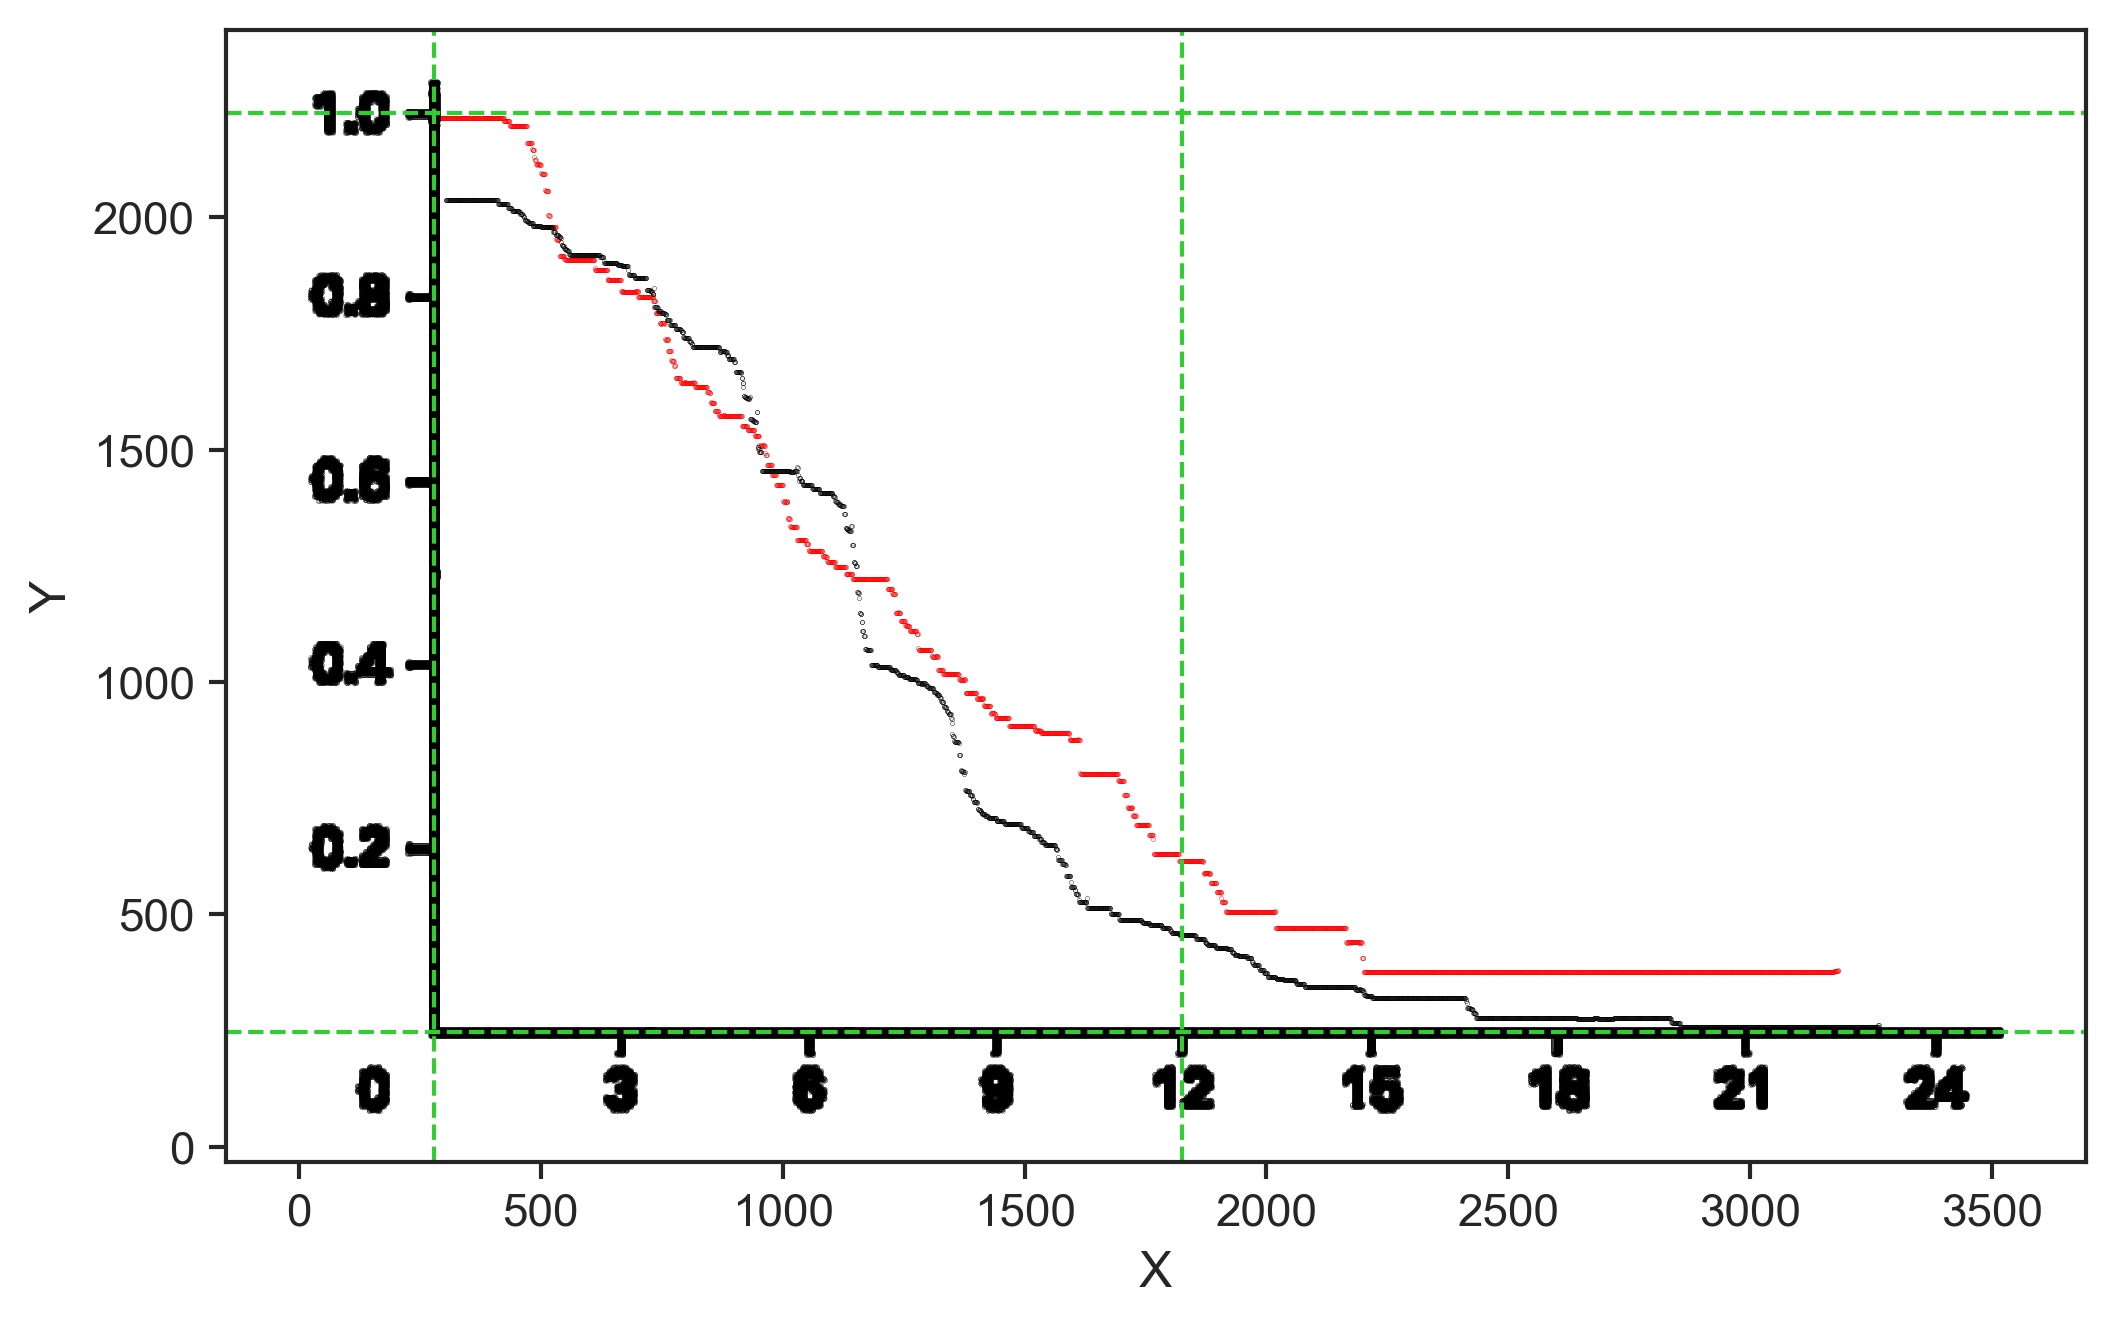

In [317]:
plt_df=df1.copy()
val1='X'
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(111)

plt_df=df1.copy()
plt_df=plt_df[['X','Y']].dropna()
x,y=plt_df['X'],plt_df['Y']
ax.scatter(x,y,s=0.01,c='red')

plt_df=df2.copy()
plt_df=plt_df[['X','Y']].dropna()
x2,y2=plt_df['X'],plt_df['Y']
ax.scatter(x2,y2,s=0.01,c='black')
plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

# Check axis 
sr1=2225
sr0=248
ax.axhline(y=sr1,c='limegreen',lw=1,ls='dashed')
ax.axhline(y=sr0,c='limegreen',lw=1,ls='dashed')

m0=280
m12=1826
ax.axvline(x=m0,c='limegreen',lw=1,ls='dashed')
ax.axvline(x=m12,c='limegreen',lw=1,ls='dashed')

plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

ax.set_xlabel(val1)
ax.set_ylabel(val2)

In [318]:
m24=m0+2*(m12-m0)

In [319]:
ms=[m0+i*(m12-m0)/12 for i in range(0,22)]
rs1=[df1[df1['X']==getNearestValue(list(df1['X']),m)]['Y'].values[0] for m in ms]
rs2=[df2[df2['X']==getNearestValue(list(df2['X']),m)]['Y'].values[0] for m in ms]

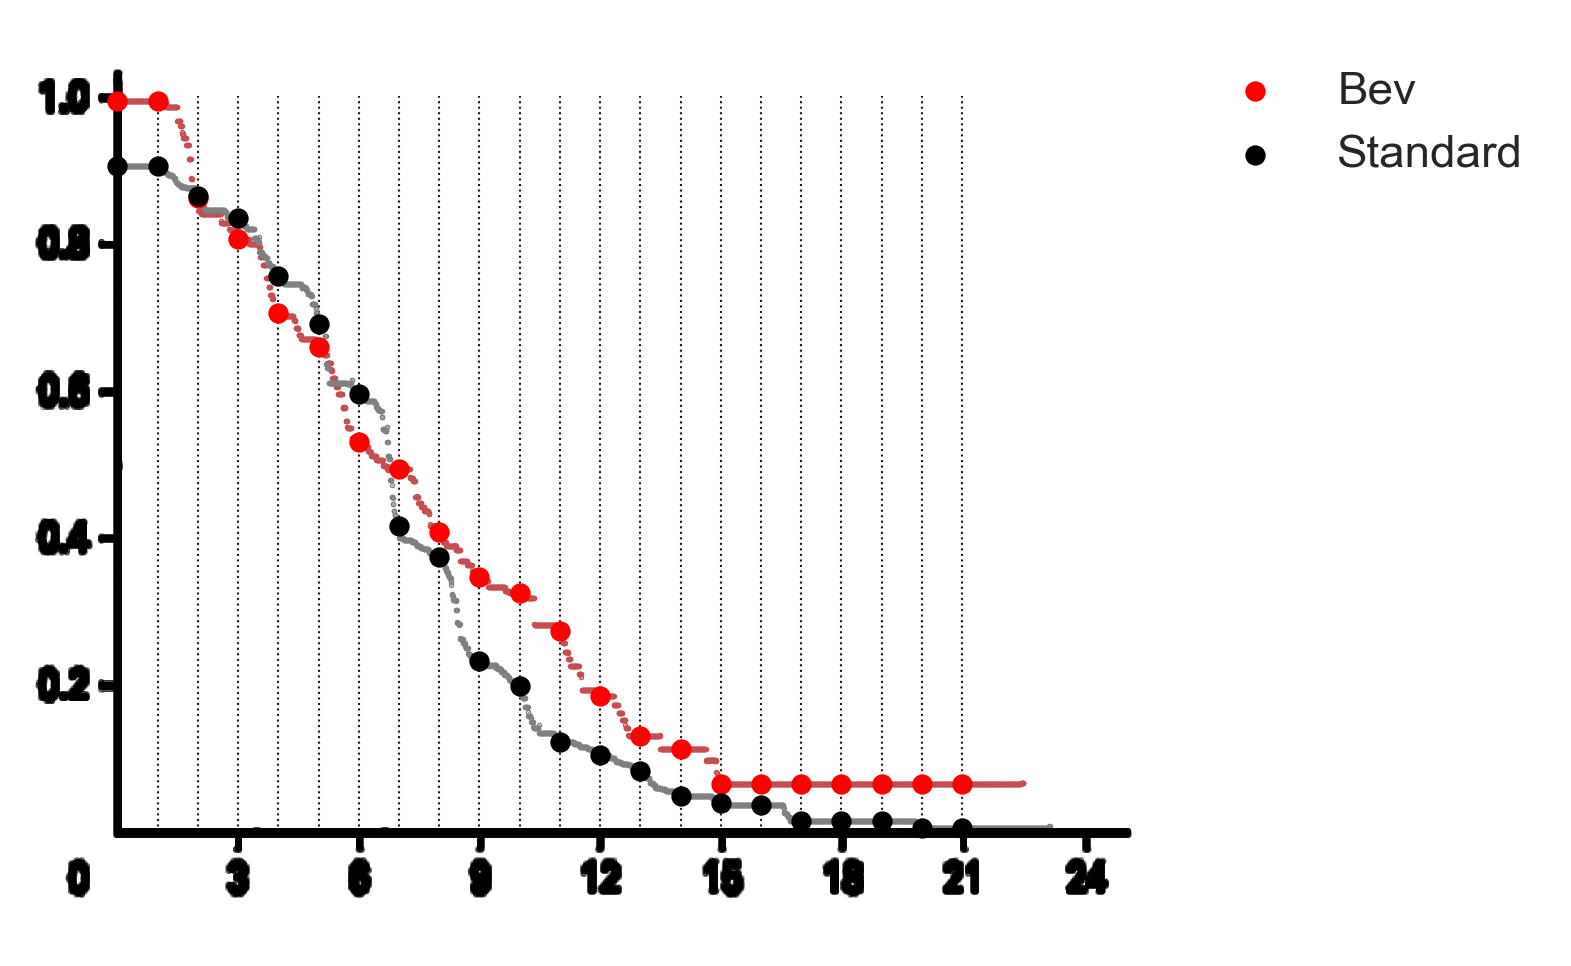

In [320]:
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=0.1,c='r')
ax.scatter(x2,y2,s=0.1,c='grey')
ax.scatter(x3,y3,s=0.001,c='black')
ax.scatter(ms,rs1,s=15,c='red',label='Bev')
ax.scatter(ms,rs2,s=15,c='black',label='Standard')

ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(0,m36+500)
ax.set_xlabel(val1)
ax.set_ylabel(val2)

ax.legend(bbox_to_anchor=(1.1,1) )

ax.set_axis_off()

In [321]:
xs=np.linspace(start=m0,stop=m24,num=720)
ys_bev,ys_std=[],[]
for x in xs:
    y=df1[df1['X']==getNearestValue(list(df1['X']),x)]['Y'].values[0]
    ys_bev.append(y)
    
    y=df2[df2['X']==getNearestValue(list(df2['X']),x)]['Y'].values[0]
    ys_std.append(y)

In [322]:
table=pd.DataFrame({'xs':xs, "ys_bev":ys_bev,'ys_std':ys_std})
table['day']=table.index
table

xs  ys_bev  ys_std  day
0     280.000000    2213  2038.0    0
1     284.300417    2213  2038.0    1
2     288.600834    2213  2038.0    2
3     292.901252    2213  2038.0    3
4     297.201669    2213  2038.0    4
..           ...     ...     ...  ...
715  3354.798331     380   263.0  715
716  3359.098748     380   263.0  716
717  3363.399166     380   263.0  717
718  3367.699583     380   263.0  718
719  3372.000000     380   263.0  719

[720 rows x 4 columns]

In [323]:
sr_bevs,sr_stds=[],[]
for idx in table.index:
    sr_bev=1-(sr1-table.loc[idx,'ys_bev'])/(sr1-sr0)
    sr_std=1-(sr1-table.loc[idx,'ys_std'])/(sr1-sr0)
    sr_bevs.append(sr_bev)
    sr_stds.append(sr_std)
    
table['survival_rate_bev']=sr_bevs
table['survival_rate_std']=sr_stds

In [324]:
# survival after 30 days
window=30
def_bevs=[]
def_stds=[]
risk_ratios=[]
for idx in table.index:
    if idx + window >= len(table):
        def_bevs.append(np.nan)
        def_stds.append(np.nan)
        risk_ratios.append(np.nan)
    else:
        def_bev=(table.loc[idx,'survival_rate_bev']-table.loc[idx+window,'survival_rate_bev'])/table.loc[idx,'survival_rate_bev']
        def_bevs.append(def_bev)
        def_std=(table.loc[idx,'survival_rate_std']-table.loc[idx+window,'survival_rate_std'])/table.loc[idx,'survival_rate_std']
        def_stds.append(def_std)
        
        if (def_bev==0)|(def_std==0):
            risk_ratios.append(np.nan)
        else:
            risk_ratios.append( np.log2(def_bev/def_std) )

table['prog_risk_bev']=def_bevs
table['prog_risk_std']=def_stds
table['prog_risk_ratio']=risk_ratios


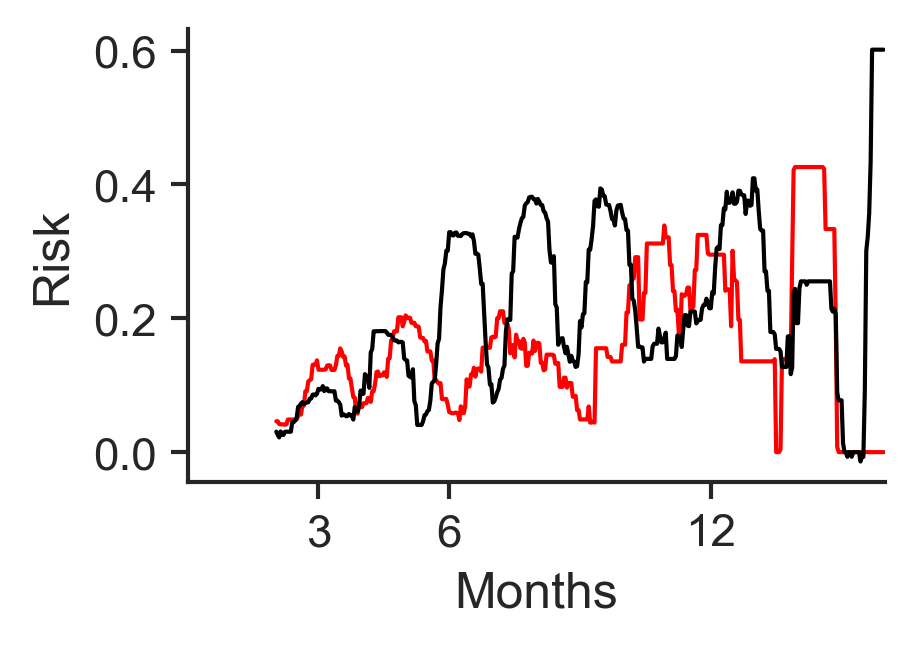

In [325]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<480)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev']
y2=plt_df2['prog_risk_std']
ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360])
ax.set_xticklabels([3,6,12])

ax.set_xlim(0,480)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

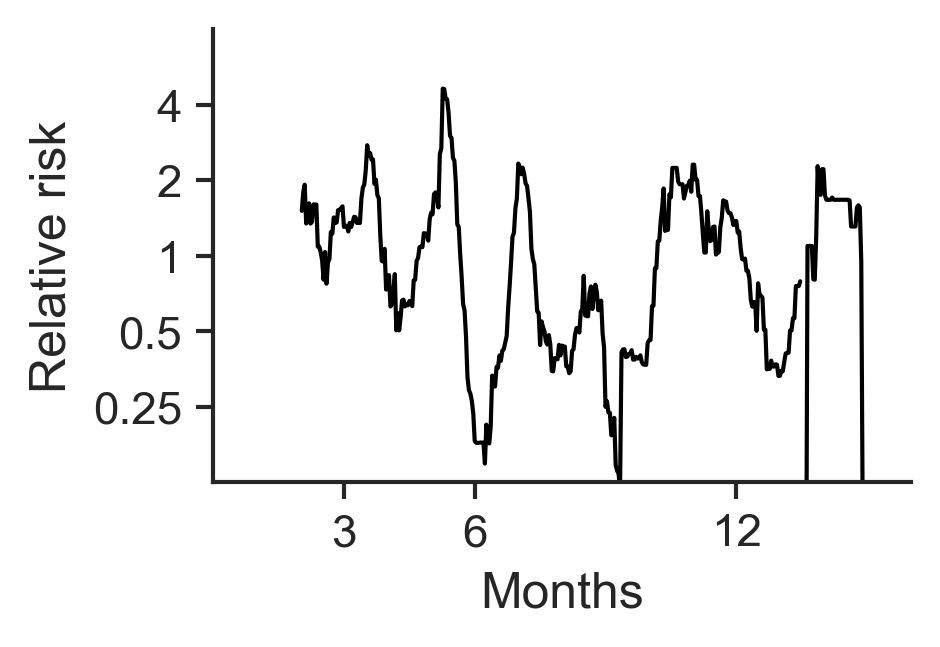

In [326]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<480)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio']
ax.plot(x,y,c='black',zorder=2)
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540])
ax.set_xticklabels([3,6,12,18])

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,480)
ax.set_ylim(-3,3)

#ax.axvspan(xmin=30,xmax=12.6*30,color='lightgrey')
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

In [327]:
# Moving avarage
window2=2*30
ratio_aves=[]
ratio_sds=[]
ratio_bevs=[]
ratio_stds=[]

for idx in table.index:
    if idx < window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    elif idx > len(table.index)-window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    else:
        ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
        ratio_sds.append( np.nanstd( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) ) 
        ratio_bevs.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_bev'] ) )
        ratio_stds.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_std'] ) )

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_28788/3803783179.py:20: RuntimeWarning: Mean of empty slice
  ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
/Users/tshiro/.pyenv/versions/miniforge3-4.10/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [328]:
table['prog_risk_ratio_moving_average']=ratio_aves
table['prog_risk_bev_moving_average']=ratio_bevs
table['prog_risk_std_moving_average']=ratio_stds

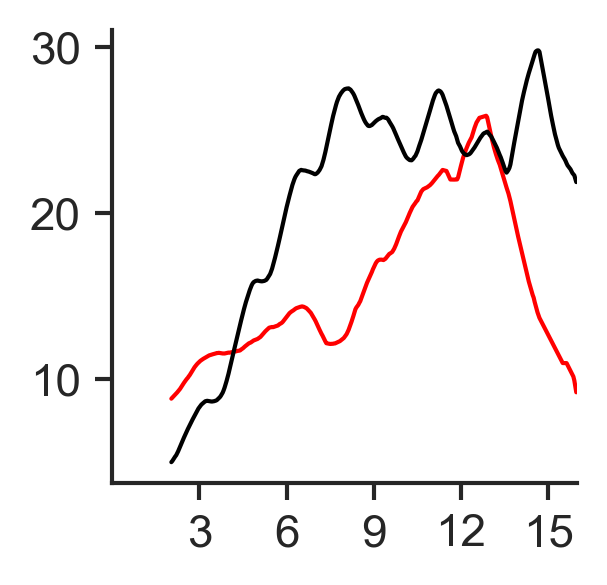

In [329]:
plt_df=table.copy()
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<480)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev_moving_average']*100
y2=plt_df2['prog_risk_std_moving_average']*100

ax.plot(x,y1,c='red',zorder=2,label='Bev')
ax.plot(x,y2,c='black',zorder=2,label='Standard')

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticks([90,180,270,360,450])
ax.set_xticklabels([3,6,9,12,15])
ax.set_xlim(0,480)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

#ax.legend(bbox_to_anchor=(1.2,1))

plt.savefig('../results/AURELIA_pr_moving_average.pdf')

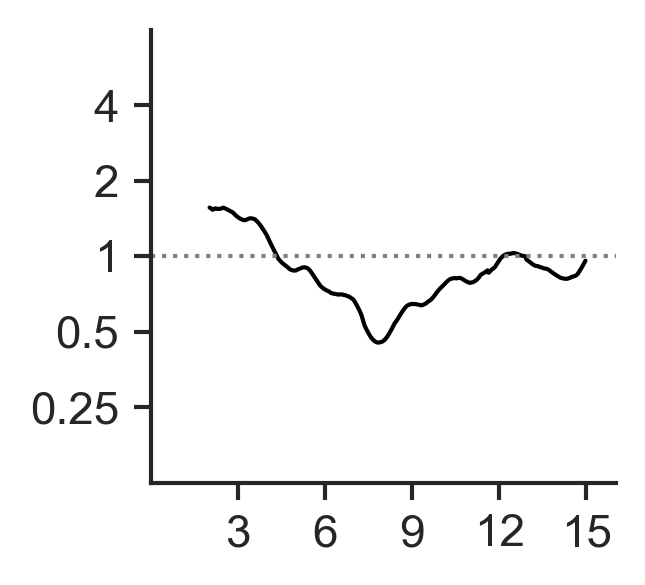

In [330]:
plt_df=table.copy()
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<450)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio_moving_average']

ax.plot(plt_df2['day'],y,c='black',zorder=2)
ax.axhline(y=0,c='grey',ls='dotted')
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticks([90,180,270,360,450])
ax.set_xticklabels([3,6,9,12,15])
ax.set_xlim(0,480)

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_ylim(-3,3)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)
plt.savefig('../results/AURELIA_rr_moving_average.pdf')

In [331]:
out_prefix='AURELIA'

In [332]:
table_w=table.dropna(subset=['prog_risk_bev_moving_average','prog_risk_std_moving_average'])
table_w=table_w.set_index('day')
table_w=table_w.rename(columns=dict_rename)
table_w.to_csv('../results/'+out_prefix+'_table.tsv',sep='\t')

## MITO16B

In [333]:
df1=pd.read_csv('../data/MITO16B_bev_plus.tsv',sep='\t')
df1.head()

X     Y
0  248  2536
1  249  2535
2  250  2536
3  251  2535
4  252  2529

In [334]:
df2=pd.read_csv('../data/MITO16B_bev_minus.tsv',sep='\t')
df2.head()

X     Y
0  252  2536
1  253  2536
2  254  2536
3  255  2536
4  256  2536

In [335]:
df3=pd.read_csv('../data/MITO16B_axis_label.tsv',sep='\t')
df3.head()

X   Y
0  3632  60
1  3633  60
2  3634  60
3  3635  60
4  3636  60

Text(0, 0.5, 'Y')

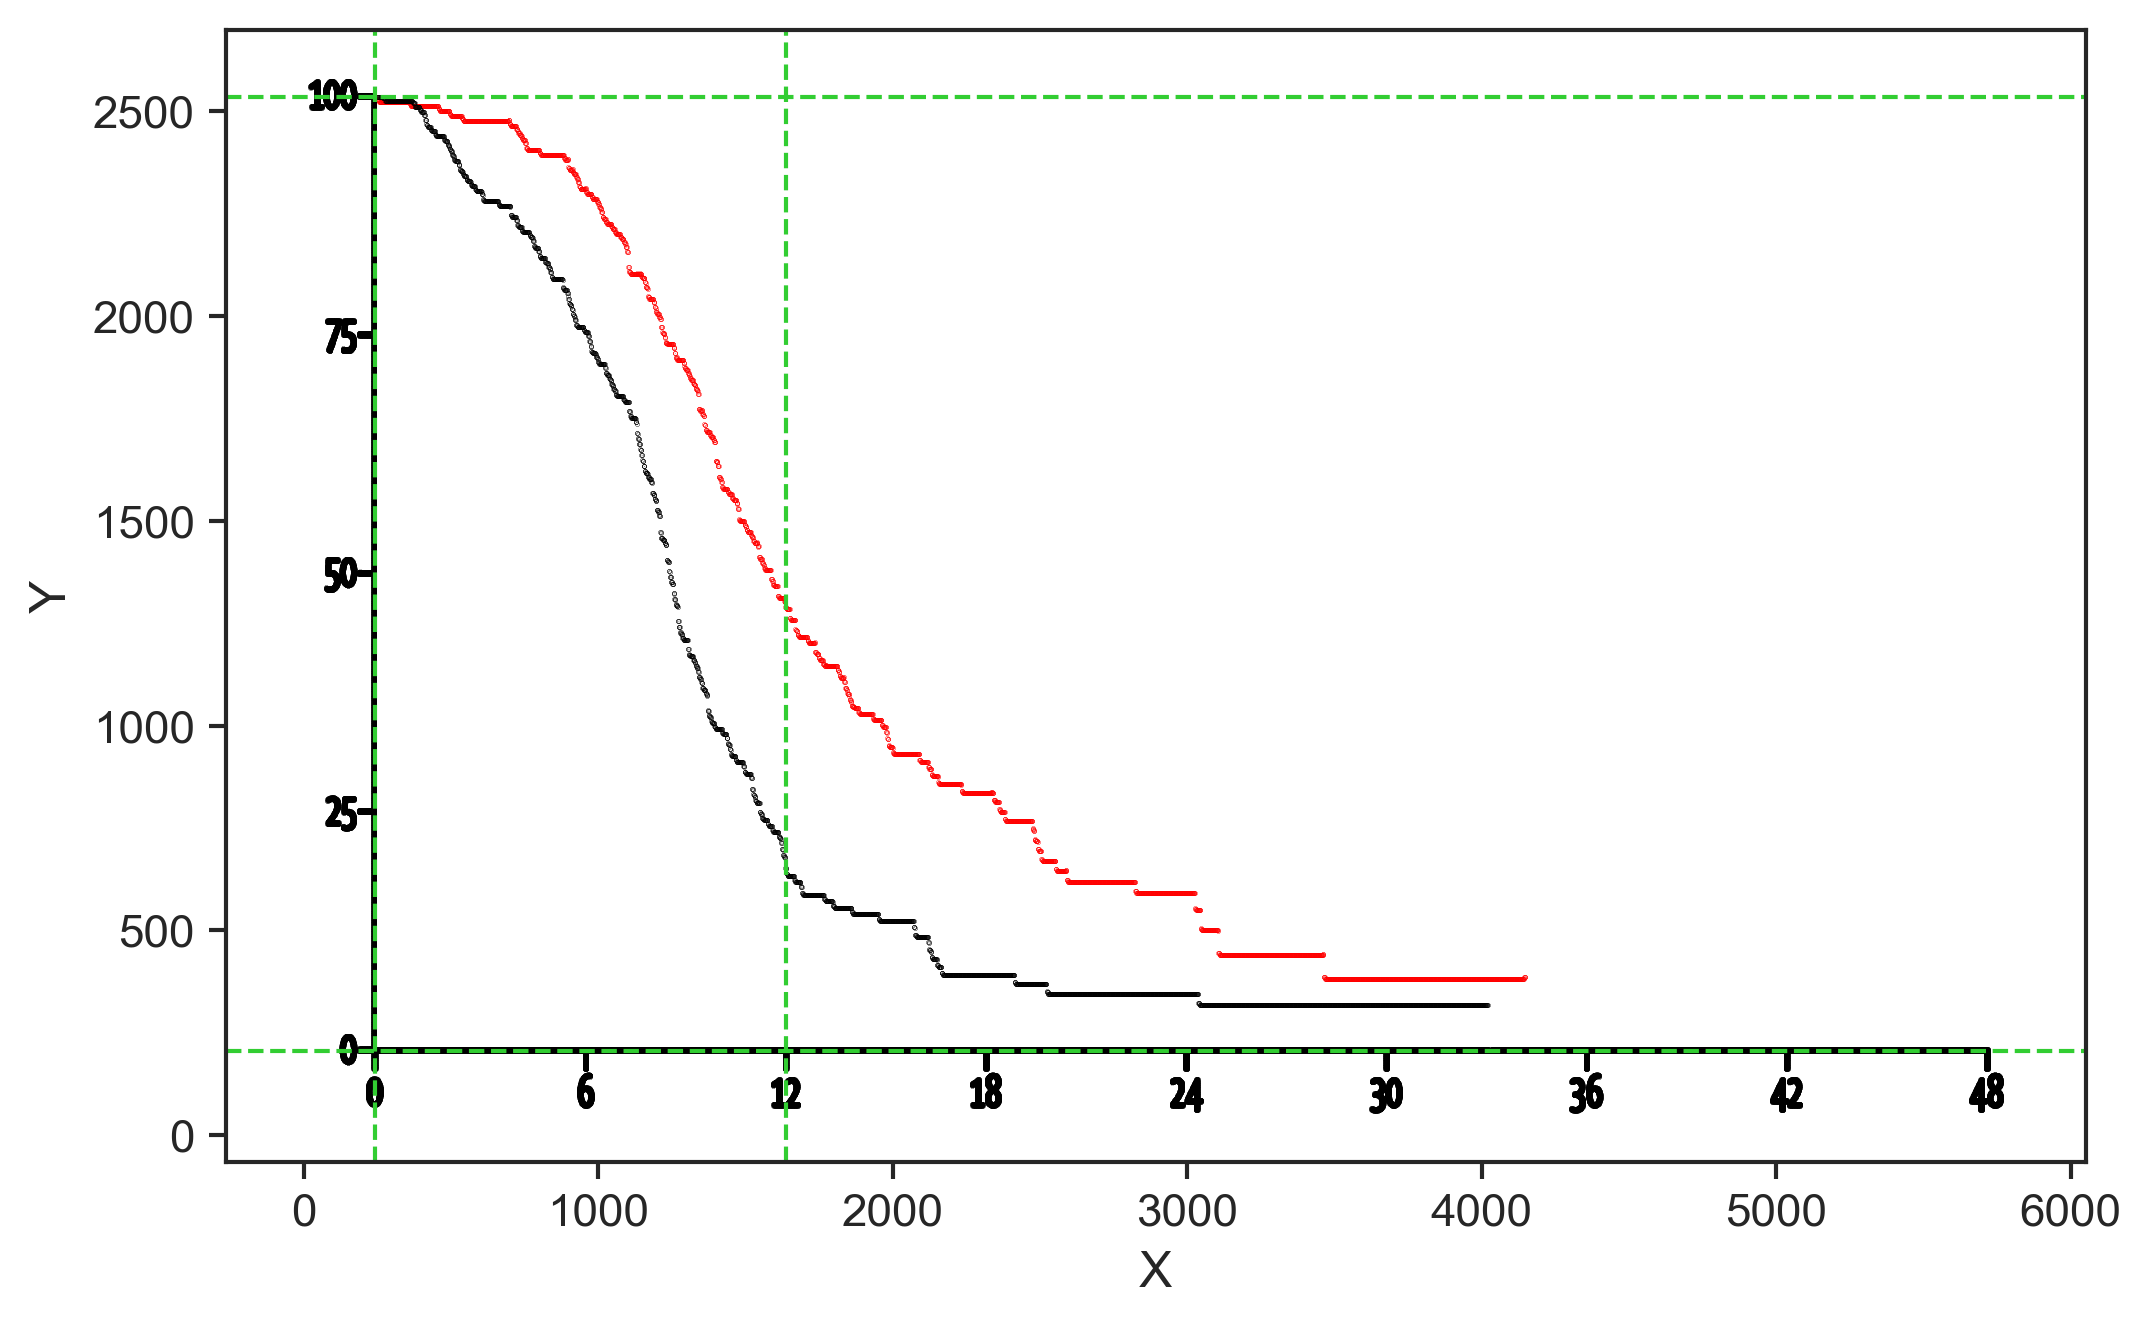

In [336]:
plt_df=df1.copy()
val1='X'
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(111)

plt_df=df1.copy()
plt_df=plt_df[['X','Y']].dropna()
x,y=plt_df['X'],plt_df['Y']
ax.scatter(x,y,s=0.01,c='red')

plt_df=df2.copy()
plt_df=plt_df[['X','Y']].dropna()
x2,y2=plt_df['X'],plt_df['Y']
ax.scatter(x2,y2,s=0.01,c='black')
plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

# Check axis 
sr1=2535
sr0=205
ax.axhline(y=sr1,c='limegreen',lw=1,ls='dashed')
ax.axhline(y=sr0,c='limegreen',lw=1,ls='dashed')

m0=242
m12=1639
ax.axvline(x=m0,c='limegreen',lw=1,ls='dashed')
ax.axvline(x=m12,c='limegreen',lw=1,ls='dashed')

plt_df=df3.copy()
plt_df=plt_df[['X','Y']].dropna()
x3,y3=plt_df['X'],plt_df['Y']
ax.scatter(x3,y3,s=0.001,c='black')

ax.set_xlabel(val1)
ax.set_ylabel(val2)

In [337]:
m24=m0+2*(m12-m0)

In [338]:
ms=[m0+i*(m12-m0)/12 for i in range(0,25)]
rs1=[df1[df1['X']==getNearestValue(list(df1['X']),m)]['Y'].values[0] for m in ms]
rs2=[df2[df2['X']==getNearestValue(list(df2['X']),m)]['Y'].values[0] for m in ms]

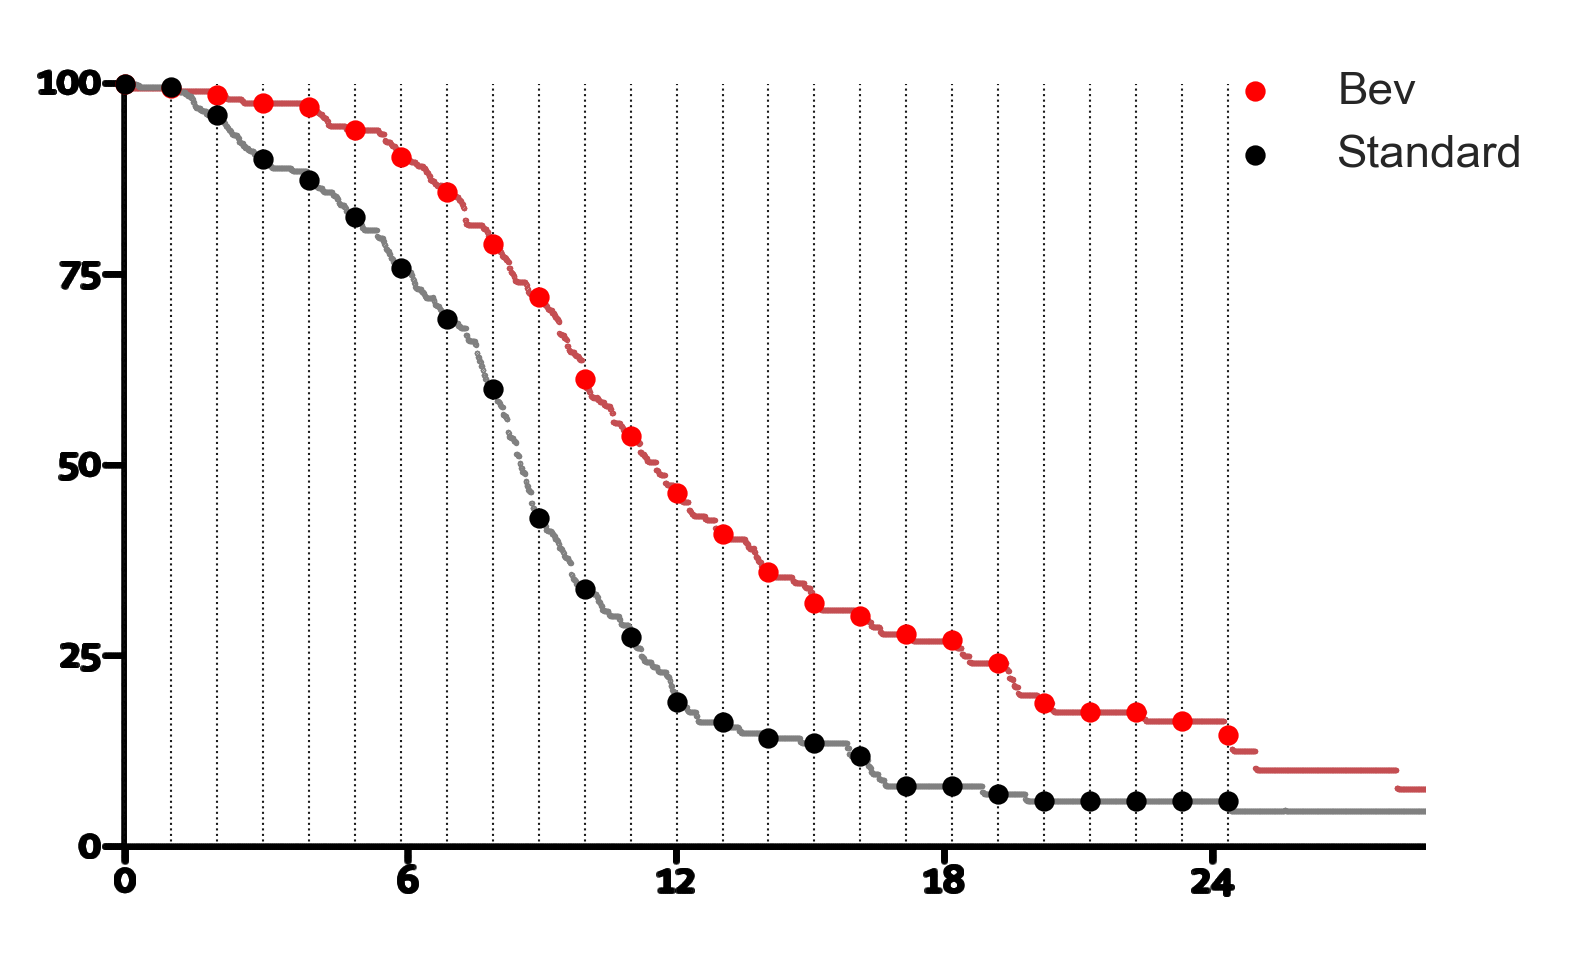

In [339]:
plt_df=df1.copy()
val1,val2='X','Y'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

plt_df=df2.copy()
plt_df=plt_df[[val1,val2]].dropna()
x2,y2=plt_df[val1],plt_df[val2]

plt_df=df3.copy()
plt_df=plt_df[[val1,val2]].dropna()
x3,y3=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=0.1,c='r')
ax.scatter(x2,y2,s=0.1,c='grey')
ax.scatter(x3,y3,s=0.001,c='black')
ax.scatter(ms,rs1,s=15,c='red',label='Bev')
ax.scatter(ms,rs2,s=15,c='black',label='Standard')

ax.vlines(ms,ymin=sr0,ymax=sr1,ls='dotted',lw=0.5,color='k',zorder=0)

ax.set_xlim(0,m24+500)
ax.set_xlabel(val1)
ax.set_ylabel(val2)

ax.legend(bbox_to_anchor=(1.1,1) )

ax.set_axis_off()

In [340]:
xs=np.linspace(start=m0,stop=m24,num=900)
ys_bev,ys_std=[],[]
for x in xs:
    y=df1[df1['X']==getNearestValue(list(df1['X']),x)]['Y'].values[0]
    ys_bev.append(y)
    
    y=df2[df2['X']==getNearestValue(list(df2['X']),x)]['Y'].values[0]
    ys_std.append(y)

In [341]:
table=pd.DataFrame({'xs':xs, "ys_bev":ys_bev,'ys_std':ys_std})
table['day']=table.index
table

xs  ys_bev  ys_std  day
0     242.000000    2536    2536    0
1     245.107898    2536    2536    1
2     248.215795    2536    2536    2
3     251.323693    2535    2536    3
4     254.431591    2528    2536    4
..           ...     ...     ...  ...
895  3023.568409     591     345  895
896  3026.676307     554     345  896
897  3029.784205     553     345  897
898  3032.892102     549     345  898
899  3036.000000     549     345  899

[900 rows x 4 columns]

In [342]:
sr_bevs,sr_stds=[],[]
for idx in table.index:
    sr_bev=1-(sr1-table.loc[idx,'ys_bev'])/(sr1-sr0)
    sr_std=1-(sr1-table.loc[idx,'ys_std'])/(sr1-sr0)
    sr_bevs.append(sr_bev)
    sr_stds.append(sr_std)
    
table['survival_rate_bev']=sr_bevs
table['survival_rate_std']=sr_stds

In [343]:
# survival after 30 days
window=30
def_bevs=[]
def_stds=[]
risk_ratios=[]
for idx in table.index:
    if idx + window >= len(table):
        def_bevs.append(np.nan)
        def_stds.append(np.nan)
        risk_ratios.append(np.nan)
    else:
        def_bev=(table.loc[idx,'survival_rate_bev']-table.loc[idx+window,'survival_rate_bev'])/table.loc[idx,'survival_rate_bev']
        def_bevs.append(def_bev)
        def_std=(table.loc[idx,'survival_rate_std']-table.loc[idx+window,'survival_rate_std'])/table.loc[idx,'survival_rate_std']
        def_stds.append(def_std)
        
        if (def_bev==0)|(def_std==0):
            risk_ratios.append(np.nan)
        else:
            risk_ratios.append( np.log2(def_bev/def_std) )

table['prog_risk_bev']=def_bevs
table['prog_risk_std']=def_stds
table['prog_risk_ratio']=risk_ratios


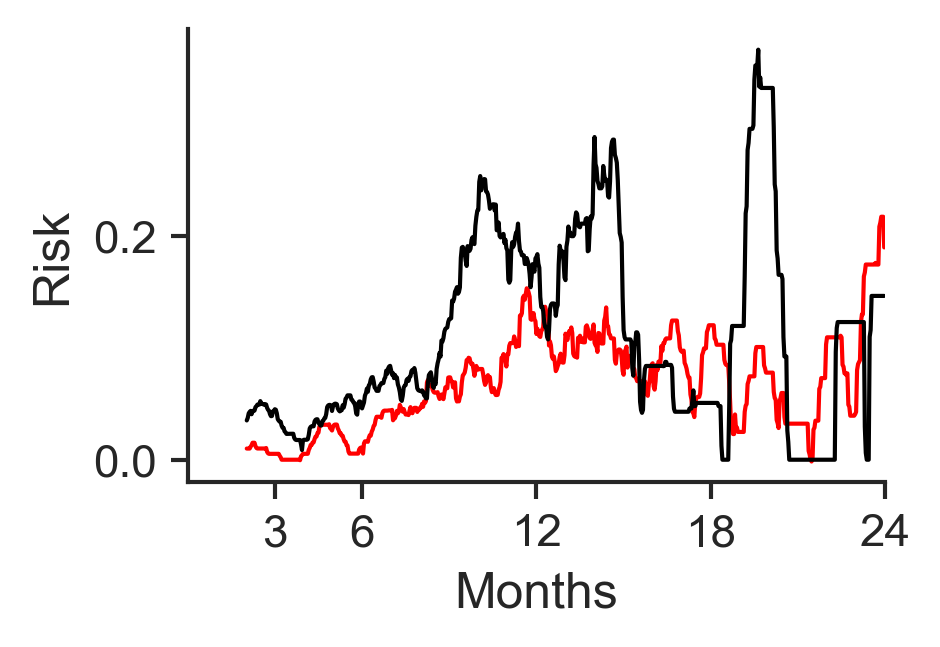

In [344]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<720)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev']
y2=plt_df2['prog_risk_std']
ax.plot(x,y1,c='red',zorder=2)
ax.plot(x,y2,c='black',zorder=2)

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540,720])
ax.set_xticklabels([3,6,12,18,24])

ax.set_xlim(0,720)
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

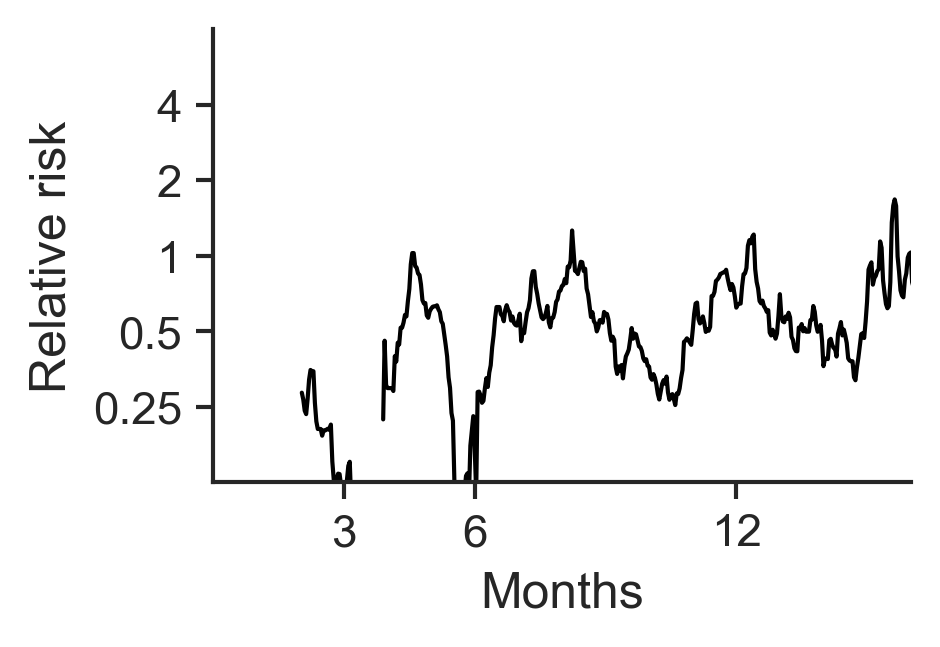

In [345]:
plt_df=table.copy()
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<720)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio']
ax.plot(x,y,c='black',zorder=2)
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_xticks([90,180,360,540,720])
ax.set_xticklabels([3,6,12,18,24])

ax.set_xlim(0,720)
ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_xlim(0,480)
ax.set_ylim(-3,3)

#ax.axvspan(xmin=30,xmax=12.6*30,color='lightgrey')
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

In [346]:
# Moving avarage
window2=2*30
ratio_aves=[]
ratio_sds=[]
ratio_bevs=[]
ratio_stds=[]

for idx in table.index:
    if idx < window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    elif idx > len(table.index)-window2:
        ratio_aves.append(np.nan)
        ratio_sds.append(np.nan)
        ratio_bevs.append(np.nan)
        ratio_stds.append(np.nan)
    else:
        ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
        ratio_sds.append( np.nanstd( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) ) 
        ratio_bevs.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_bev'] ) )
        ratio_stds.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_std'] ) )

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_28788/3803783179.py:20: RuntimeWarning: Mean of empty slice
  ratio_aves.append( np.nanmean( table.iloc[idx-window2:idx+window2,:]['prog_risk_ratio'] ) )
/Users/tshiro/.pyenv/versions/miniforge3-4.10/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [347]:
table['prog_risk_ratio_moving_average']=ratio_aves
table['prog_risk_bev_moving_average']=ratio_bevs
table['prog_risk_std_moving_average']=ratio_stds

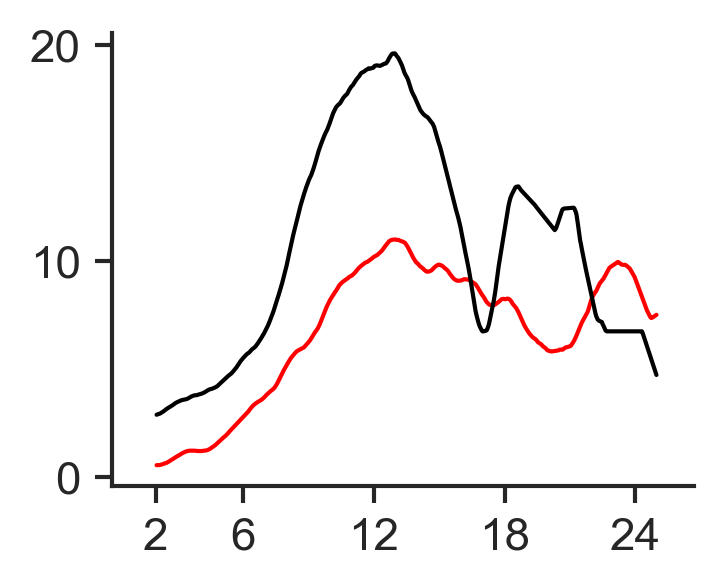

In [352]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<750)]
x=plt_df2['day']
y1=plt_df2['prog_risk_bev_moving_average']*100
y2=plt_df2['prog_risk_std_moving_average']*100

ax.plot(x,y1,c='red',zorder=2,label='Bev')
ax.plot(x,y2,c='black',zorder=2,label='Standard')

ax.set_ylabel('Risk')
ax.set_xlabel('Months')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticks([60,180,360,540,720])
ax.set_xticklabels([2,6,12,18,24])

ax.set_xlim(0,800)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig('../results/MITO16B_pr_moving_average.pdf')

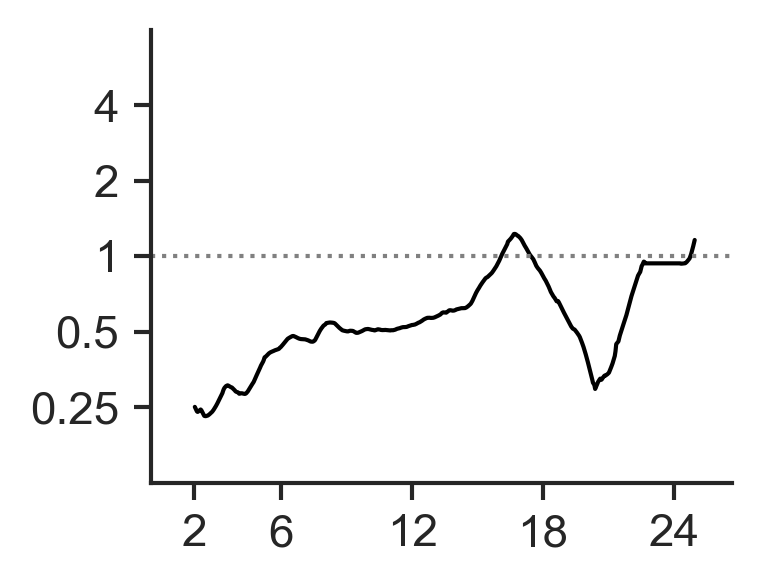

In [353]:
plt_df=table.copy()
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
plt_df2=plt_df[ (plt_df['day']>window2)&(plt_df['day']<750)]
x=plt_df2['day']
y=plt_df2['prog_risk_ratio_moving_average']

ax.plot(plt_df2['day'],y,c='black',zorder=2)
ax.axhline(y=0,c='grey',ls='dotted')
ax.set_ylabel('Relative risk')
ax.set_xlabel('Months')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticks([60,180,360,540,720])
ax.set_xticklabels([2,6,12,18,24])
ax.set_xlim(0,800)

ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([0.25,0.5,1,2,4])
ax.set_ylim(-3,3)

ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)

plt.savefig('../results/MITO16B_rr_moving_average.pdf')

In [350]:
out_prefix='MITO16B'

In [351]:
table_w=table.dropna(subset=['prog_risk_bev_moving_average','prog_risk_std_moving_average'])
table_w=table_w.set_index('day')
table_w=table_w.rename(columns=dict_rename)
table_w.to_csv('../results/'+out_prefix+'_table.tsv',sep='\t')